## Deep Deterministic Policy Gradient (DDPG)

In [ ]:
try :
    import gymnasium as gym
    from gymnasium.spaces import Box, Discrete
    from gymnasium import spaces
except ImportError:
    %pip install gymnasium
    import gymnasium as gym
    from gymnasium.spaces import Box, Discrete
    from gymnasium import spaces

try:
    from mpi4py import MPI
except ImportError:
    %pip install mpi4py
    from mpi4py import MPI

try:
    import torchviz
except ImportError:
    %pip install torchviz
    import torchviz
# Third-party imports
import numpy as np
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.optim import Adam
# Standard library imports
import os
from typing import Any
import time
from copy import deepcopy
import itertools
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

In [ ]:
if not os.path.isfile("trajectory.csv"):
    !wget https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/TBP/SAC/trajectory.csv

In [ ]:
if not os.path.isdir('utils'):
    %mkdir utils
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/logx.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/mpi_tools.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/serialization_utils.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/run_utils.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/user_config.py
# spinning up utilities
# import utils
from utils.logx import EpochLogger
from utils.logx import colorize
from utils.run_utils import setup_logger_kwargs

# DDPG Core

In [ ]:
def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def mlp(sizes, activation, output_activation=nn.Identity, device=torch.device("cpu")):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers).to(device)

def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])

class MLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit, device=torch.device("cpu")):
        super().__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, nn.Tanh, device)
        self.act_limit = act_limit

    def forward(self, obs):
        # Return output from network scaled to action space limits.
        return self.act_limit * self.pi(obs)

class MLPQFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, device=torch.device("cpu")):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation, device=device)

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1))
        return torch.squeeze(q, -1) # Critical to ensure q has right shape.

class MLPActorCritic(nn.Module):

    def __init__(self, observation_space, action_space, hidden_sizes=(256,256),
                 activation=nn.Tanh, device=torch.device("cpu")):
        super().__init__()

        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        # build policy and value functions
        self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit, device).to(device)
        self.q = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation, device).to(device)

    def act(self, obs):
        with torch.no_grad():
            return self.pi(obs).cpu().numpy()

In [ ]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for DDPG agents.
    """

    def __init__(self, obs_dim, act_dim, size, device=torch.device("cpu")):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        # print(obs)
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32, device=device) for k,v in batch.items()}

In [ ]:
class DDPG:
    def __init__(self, env_fn, actor_critic, ac_kwargs_, seed_=0,
                 steps_per_epoch=30000, epochs_=100, replay_size=int(1e6),
                 gamma_=0.99, polyak=0.995, pi_lr=1e-3, q_lr=1e-3,
                 batch_size=1024, start_steps=5000, update_after=1000,
                 update_every=2000, act_noise=0.1, num_test_episodes=10,
                 max_ep_len=6000, save_freq=1, logger_kwargs_=None, device=torch.device("cpu")):

        torch.manual_seed(seed_)
        np.random.seed(seed_)

        self.env, self.test_env = env_fn(), env_fn()
        obs_dim = self.env.observation_space.shape
        act_dim = self.env.action_space.shape[0]
        self.act_limit = self.env.action_space.high[0]

        self.ac = actor_critic(self.env.observation_space, self.env.action_space, **ac_kwargs_, device=device)
        self.ac_targ = deepcopy(self.ac)
        for p in self.ac_targ.parameters():
            p.requires_grad = False

        self.replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size, device=device)
        self.gamma = gamma_
        self.polyak = polyak
        self.pi_optimizer = Adam(self.ac.pi.parameters(), lr=pi_lr)
        self.q_optimizer = Adam(self.ac.q.parameters(), lr=q_lr)
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs_
        self.start_steps = start_steps
        self.update_after = update_after
        self.update_every = update_every
        self.act_noise = act_noise
        self.num_test_episodes = num_test_episodes
        self.max_ep_len = max_ep_len
        self.save_freq = save_freq
        self.logger = EpochLogger(**logger_kwargs_)
        self.logger.save_config(locals())
        self.logger.setup_pytorch_saver(self.ac)
        # Count variables (protip: try to get a feel for how different size networks behave!)
        var_counts = tuple(count_vars(module) for module in [self.ac.pi, self.ac.q])
        self.logger.log('\nNumber of parameters: \t pi: %d, \t q: %d\n'%var_counts)

    def compute_loss_q(self, data_):
        o, a, r, o2, d = data_['obs'], data_['act'], data_['rew'], data_['obs2'], data_['done']
        # print(o)
        q = self.ac.q(o, a)
        # print('after o')
        with torch.no_grad():
            q_pi_targ = self.ac_targ.q(o2, self.ac_targ.pi(o2))
            backup = r + self.gamma * (1 - d) * q_pi_targ
        loss_q = ((q - backup) ** 2).mean()

        # Useful info for logging
        loss_info = dict(QVals=q.detach().cpu().numpy())

        return loss_q, loss_info

    def compute_loss_pi(self, data_):
        o = data_['obs']
        q_pi = self.ac.q(o, self.ac.pi(o))
        return -q_pi.mean()

    def update(self, data_):
        self.q_optimizer.zero_grad()
        # print('loss q')
        loss_q, loss_info = self.compute_loss_q(data_)
        loss_q.backward()
        self.q_optimizer.step()

        for p in self.ac.q.parameters():
            p.requires_grad = False

        self.pi_optimizer.zero_grad()
        loss_pi = self.compute_loss_pi(data_)
        loss_pi.backward()
        self.pi_optimizer.step()

        for p in self.ac.q.parameters():
            p.requires_grad = True


        # Record things
        self.logger.store(LossQ=loss_q.item(), LossPi=loss_pi.item(), **loss_info)

        with torch.no_grad():
            for p, p_targ in zip(self.ac.parameters(), self.ac_targ.parameters()):
                p_targ.data.mul_(self.polyak)
                p_targ.data.add_((1 - self.polyak) * p.data)

    def get_action(self, o, noise_scale):
        a = self.ac.act(torch.as_tensor(o, dtype=torch.float32, device=device))
        a += noise_scale * np.random.randn(self.env.action_space.shape[0])
        return np.clip(a, -self.act_limit, self.act_limit)

    def train(self, epochs_=None):
        if epochs_ is None:
            epochs_ = self.epochs
        total_steps = self.steps_per_epoch * epochs_
        start_time = time.time()
        o, _ = self.env.reset()
        ep_ret, ep_len = 0, 0

        for t in range(total_steps):
            if t > self.start_steps:
                a = self.get_action(o, self.act_noise)
            else:
                a = self.env.action_space.sample()
                # print(a)

            o2, r, d, _, _ = self.env.step(a)
            self.replay_buffer.store(o, a, r, o2, d)
            reward_array.append(r)
            o = o2
            ep_ret += r
            ep_len += 1

            if d or (ep_len == self.max_ep_len):
                # print('done')
                self.logger.store(EpRet=ep_ret, EpLen=ep_len)
                o, _ = self.env.reset()
                ep_ret, ep_len = 0, 0

            if t >= self.update_after and t % self.update_every == 0:
                print(colorize("updating  🥰☺️", 'blue', bold=True))
                for _ in range(500):
                    batch = self.replay_buffer.sample_batch(self.batch_size)
                    self.update(batch)


            if (t+1) % self.steps_per_epoch == 0:
                epoch = (t+1) // self.steps_per_epoch
                print(f"Epoch {epoch} completed in {time.time() - start_time:.2f} sec")
                # if self.logger:
                #     self.logger.log_tabular('Epoch', epoch)
                #     self.logger.dump_tabular()

                if epoch % self.save_freq == 0 and self.logger:
                    self.logger.save_state({'env': self.env}, None)

                # Log info about epoch
                self.logger.log_tabular('Epoch', epoch)
                self.logger.log_tabular('EpRet', with_min_and_max=True)
                # try:
                self.logger.log_tabular('EpLen', average_only=True)
                # except:
                # self.logger.log_tabular('EpLen', with_min_and_max=True)
                self.logger.log_tabular('TotalEnvInteracts', t)
                self.logger.log_tabular('QVals', with_min_and_max=True)
                self.logger.log_tabular('LossPi', average_only=True)
                self.logger.log_tabular('LossQ', average_only=True)
                self.logger.log_tabular('Time', time.time()-start_time)
                self.logger.dump_tabular()
                self.test()

    def test(self, fun_mode=False, save_data=False):
        o, _ = self.env.reset()
        state_array = []
        action_array = []
        noise = 0
        while True:
            a = self.get_action(o, noise)
            action_array.append(a)
            o, _, d, _, position = self.env.step(a)
            state_array.append(position)
            if d:
                break
        dt = self.env.dt
        time = np.arange(0, len(state_array)*dt, dt)
        state_array = np.array(state_array)
        action_array = np.array(action_array)
        # save trajectory and actions to csv
        if not os.path.exists('results/') and save_data:
            os.makedirs('results/')

        # numpy to pandas with header
        state_df = pd.DataFrame(state_array, columns=['x', 'y', 'xdot', 'ydot'])
        action_df = pd.DataFrame(action_array, columns=['ax', 'ay'])

        # save to csv
        if save_data:
            state_df.to_csv('results/state.csv', index=False)
            action_df.to_csv('results/action.csv', index=False)
            print(colorize("Data saved to results folder 😜", 'green', bold=True))

        df = pd.read_csv('trajectory.csv')
        # df to numpy array
        data = df.to_numpy()
        print(data.shape)
        trajectory = np.delete(data, 2, 1)
        trajectory = np.delete(trajectory, -1, 1)

        if fun_mode:
            # Use XKCD style for hand-drawn look
            with plt.xkcd():
                plt.plot(state_array[:,0], state_array[:,1], label='State')
                plt.plot(trajectory[:,0], trajectory[:,1], label='Trajectory')
                plt.legend()
                plt.show()
            with plt.xkcd():
                plt.plot(time, action_array)
                plt.xlabel("Time (sec)")
                plt.ylabel("action (N)")
                plt.show()
        else:
            plt.plot(state_array[:,0], state_array[:,1], label='State')
            plt.plot(trajectory[:,0], trajectory[:,1], label='Trajectory')
            plt.legend()
            # axis equalor
            plt.axis('equal')

            plt.show()


            plt.plot(action_array)
            plt.xlabel("Time (sec)")
            plt.ylabel("action (N)")
            plt.show()

    # save actor critic
    def save(self, filepath='model/'):
        if not os.path.isdir(filepath):
            os.mkdir(filepath)
        # Check the device of the model
        if device == 'cuda':
            torch.save(self.ac.pi.state_dict(), filepath + 'actor_cuda.pth')
            torch.save(self.ac.q.state_dict(), filepath + 'q_cuda.pth')
        else:
            torch.save(self.ac.pi.state_dict(), filepath + 'actor_cpu.pth')
            torch.save(self.ac.q.state_dict(), filepath + 'q_cpu.pth')
        print(colorize(f"Model saved successfully! 🥰😎", 'blue', bold=True))

    # load actor critic
    def load(self, filepath='model/', load_device=torch.device("cpu"),from_device_to_load='cpu'):
        self.start_steps = 0 # does not distarct the loaded model
        # check if the model is available
        if os.path.isfile(filepath + 'actor_cpu.pth') or os.path.isfile(filepath + 'actor_cuda.pth'):
             # Check the device of the model
            if from_device_to_load == 'cpu':
                actor_file = 'actor_cpu.pth'
                q_file = 'q_cpu.pth'
            else:
                actor_file = 'actor_cuda.pth'
                q_file = 'q_cuda.pth'

            if from_device_to_load == 'cpu' and load_device.type == 'cuda':
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file, map_location=torch.device('cuda')))
                self.ac.q.load_state_dict(torch.load(filepath + q_file, map_location=torch.device('cuda')))
            elif from_device_to_load == 'cuda' and load_device.type == 'cpu':
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file, map_location=torch.device('cpu')))
                self.ac.q.load_state_dict(torch.load(filepath + q_file, map_location=torch.device('cpu')))
            else:
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file))
                self.ac.q.load_state_dict(torch.load(filepath + q_file))
            print(colorize(f"Model loaded successfully and device is {load_device}! 🥰😎", 'blue', bold=True))
        else:
            print(colorize("Model not found! 😱🥲", 'red', bold=True))



## Three body problem environment

In [ ]:
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
print(data.shape)
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 6)


(9999, 4)

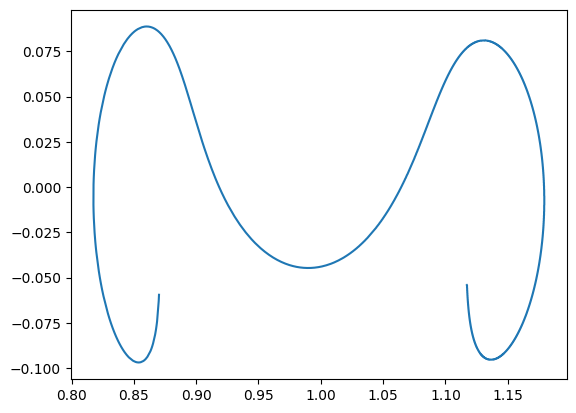

In [ ]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [ ]:
# three body problem env
class ThreeBodyEnv(gym.Env):
    def __init__(self, trajectory_, error_range=0.1, final_range=0.1):
        self.trajectory = trajectory_
        self.state = np.zeros(4)
        self.dt = 0.001
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-4, high=4, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory_[0]
        self.steps = 0
        self.max_steps = 6000
        self.final_range = final_range
        self.error_range = error_range
        self.reward_range = (-float('inf'), float('inf'))
        self.render_logic = False
        # second player
        self.second_player = False
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        # force = action[0] * env.state[2:] + action[1] * env.state[:2]
        a_x = action[0]/100
        a_y = action[1]/100
        # add second player action
        a_x_2 = action[2]/100 if self.second_player else 0
        a_y_2 = action[3]/100 if self.second_player else 0


        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x + a_x_2
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*y/(r2**3) + a_y + a_y_2

        x = x + xdot*self.dt
        y = y + ydot*self.dt

        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        # plot position
        if self.render_logic:
            plt.plot(x, y, 'ro')
            plt.plot(self.trajectory[:,0], self.trajectory[:,1])
            plt.show()

        distance = np.linalg.norm(self.trajectory[:,0:2] - self.position[0:2], axis=1) # just add position and delete velocity
        nearest_idx = np.argmin(distance)
        reward = 100*(1 - np.linalg.norm(self.state, axis=0) - (a_x/10)**2 - (a_y/10)**2 + (a_x_2/10)**2 + (a_y_2/10)**2) - 100
        done = self.steps >= self.max_steps
        states_array.append(self.state)
        if np.linalg.norm(self.position[0:2] - self.trajectory[-1, 0:2]) < self.final_range:
            done = True
            reward = 1000
            print(colorize("done 🥺", 'green', bold=True))
        if self.steps > 20000:
            done = True
            reward = -1000
            print("end time")
        if self.error_calculation() > self.error_range:
            print(self.state)
            done = True
            reward = -1000 + (nearest_idx/10000)*1000
            print('idx', nearest_idx/100000, 'state', np.linalg.norm(self.state, axis=0))
            print(colorize("too much error 🥲😱", 'red', bold=True))



        # print(self.state, reward, done, self.position)
        return 1000*self.state, reward, done, False, self.position

    def position2state(self):
        # find the nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory[:,0:2] - self.position[0:2], axis=1) # just add position and delete velocity
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]
        # self.state = self.state * np.array([10, 10, 1, 1])

    def error_calculation(self):
        normalized_error = self.state * np.array([1, 1, 0.0, 0.0]) # reduce the effect of velocity error
        return np.linalg.norm(normalized_error)

    def reset(self,
              *,
              seed: 5 = None,
              return_info: bool = False,
              options: 6 = None):
        self.position = self.trajectory[0]
        self.steps = 0
        self.position2state()
        return 1000*self.state, {}

In [ ]:
# Define variables directly
env = ThreeBodyEnv(trajectory)
hid = 32
l = 2
gamma = 0.99
seed = 0
epochs = 50
exp_name = 'ddpg'
steps_per_epoch_=30000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ac_kwargs = dict(hidden_sizes=[hid]*l)
states_array = []
logger_kwargs = setup_logger_kwargs(exp_name, seed)
reward_array=[]
ddpg = DDPG(lambda : ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), MLPActorCritic, ac_kwargs,seed_=seed, steps_per_epoch=steps_per_epoch_, epochs_=epochs, logger_kwargs_=logger_kwargs, device=device, batch_size=1024, start_steps=5000, update_after=1000, update_every=2000)

Logging data to /content/data/ddpg/ddpg_s0/progress.txt
Saving config:

{
    "ac_kwargs_":	{
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "act_dim":	2,
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	1024,
    "device":	"cuda",
    "env_fn":	"<function <lambda> at 0x7c467c4b63e0>",
    "epochs_":	50,
    "exp_name":	"ddpg",
    "gamma_":	0.99,
    "logger_kwargs_":	{
        "exp_name":	"ddpg",
        "output_dir":	"/content/data/ddpg/ddpg_s0"
    },
    "max_ep_len":	6000,
    "num_test_episodes":	10,
    "obs_dim":	[
        4
    ],
    "p":	"Parameter containing:\ntensor([-0.1749], device='cuda:0')",
    "pi_lr":	0.001,
    "polyak":	0.995,
    "q_lr":	0.001,
    "replay_size":	1000000,
    "save_freq":	1,
    "seed_":	0,
    "self":	{
        "<__main__.DDPG object at 0x7c4692a6d8d0>":	{
            "ac":	{
                "MLPActorCritic(\n  (pi): MLPActor(\n    (pi): Sequential(\n      (0): Linear(in_features=4, ou

In [ ]:
ddpg.load()

Model loaded successfully and device is cpu! 🥰😎


In [ ]:
# print(ddpg.ac.pi)
# dot = torchviz.make_dot(ddpg.ac.pi(torch.randn(1, ddpg.obs_dim[0], device=device)), params=dict(ddpg.ac.pi.named_parameters()), show_attrs=True)
# dot.graph_attr.update(size="10,10")
# dot

[-0.00991837  0.00127525 -0.02086413 -0.00163295]
idx 0.02224 state 0.023194371574341975
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00073299  0.00999849  0.02644896  0.02973299]
idx 0.05979 state 0.04103785104810198
too much error 🥲😱
[0.00915752 0.00404645 0.0246045  0.00676599]
idx 0.0139 state 0.02741156792694077
too much error 🥲😱
[0.00916176 0.00405227 0.02462435 0.0067705 ]
idx 0.0139 state 0.027432770337128536
too much error 🥲😱
updating  🥰☺️
[0.00834658 0.00551866 0.02922453 0.00967014]
idx 0.01226 state 0.03236828378675594
too much error 🥲😱
[0.00847058 0.00534146 0.0291455  0.00905577]
idx 0.01231 state 0.032120849738009404
too much error 🥲😱
[0.0084702  0.00534807 0.02916912 0.00908789]
idx 0.01231 state 0.03215234831211357
too much error 🥲😱
updating  🥰☺️
[0.00893842 0.00453698 0.0294521  0.00466342]
idx 0.01327 state 0.031458753862334064
too much error 🥲😱
updating  🥰☺️
[0.00056064 0.00999559 0.12291697 0.02984948]
idx 0.04603 state 0.1268849838960431
too much error 🥲😱
upd

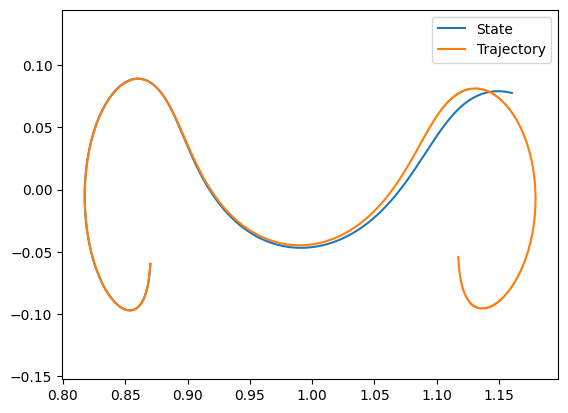

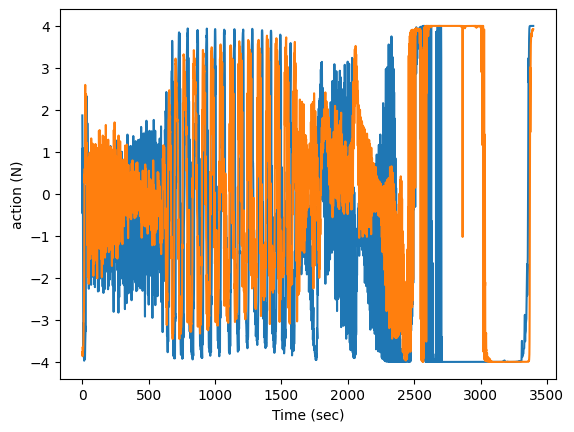

[0.00733441 0.00696846 0.05716635 0.04874875]
idx 0.06471 state 0.07580755224248147
too much error 🥲😱
updating  🥰☺️
[-0.00999981  0.00010193 -0.02947991  0.00316502]
idx 0.02082 state 0.03129039932709924
too much error 🥲😱
updating  🥰☺️
[-1.00025058e-02  3.79759275e-05 -3.82976232e-02  7.01145364e-03]
idx 0.02049 state 0.0401985073213893
too much error 🥲😱
updating  🥰☺️
[-0.00690781 -0.00724935 -0.05584481  0.01908937]
idx 0.04413 state 0.059860824603212265
too much error 🥲😱
updating  🥰☺️
[-0.00170495 -0.00987738 -0.08024916 -0.01794808]
idx 0.04576 state 0.08284039683781143
too much error 🥲😱
updating  🥰☺️
[-0.00901208 -0.00434098 -0.04542978  0.00208415]
idx 0.03902 state 0.04656468361861806
too much error 🥲😱
updating  🥰☺️
[-0.00926147 -0.00385094 -0.04365322  0.01018926]
idx 0.04046 state 0.045935058536208224
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00782617  0.00623187 -0.01665828  0.04528512]
idx 0.04965 state 0.04927804117010482
too much error 🥲😱
[-0.00963006 -0.00272484 -0

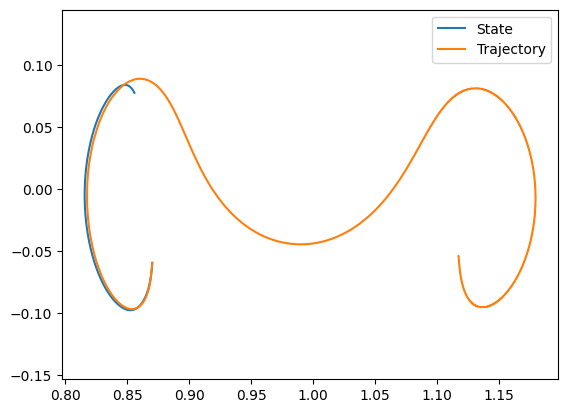

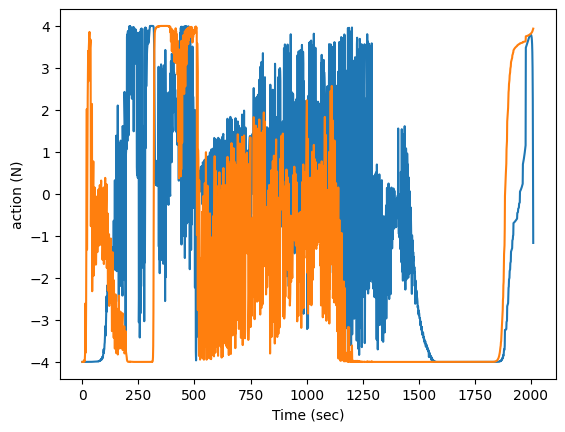

[ 0.00457612 -0.00904219 -0.06103472 -0.11544502]
idx 0.03136 state 0.13097897812505857
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[0.00984171 0.00181601 0.01020129 0.0084889 ]
idx 0.07245 state 0.016621818803115272
too much error 🥲😱
[-0.00878087 -0.00485496 -0.03905891 -0.00915711]
idx 0.01293 state 0.04135366036273596
too much error 🥲😱
[-0.00876312 -0.00486238 -0.03902759 -0.00915274]
idx 0.01293 state 0.04132021957379787
too much error 🥲😱
updating  🥰☺️
[-0.00897079 -0.00446873 -0.03482251 -0.00678794]
idx 0.0134 state 0.03686635698552003
too much error 🥲😱
[-0.00984719  0.00184774 -0.03212005 -0.01074519]
idx 0.02372 state 0.03532050393451447
too much error 🥲😱
updating  🥰☺️
[-0.00915059 -0.00404241 -0.05074824 -0.01064622]
idx 0.03969 state 0.05280909419368242
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00907398 -0.00424341 -0.04845095  0.00336927]
idx 0.04166 state 0.04959022118516917
too much error 🥲😱
updating  🥰☺️
[ 0.00751796 -0.00660117  0.00895196 -0.0495

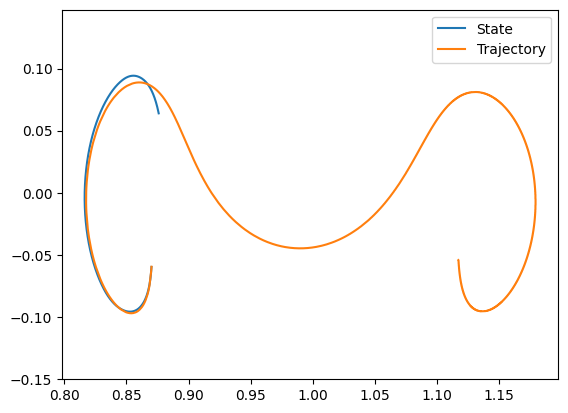

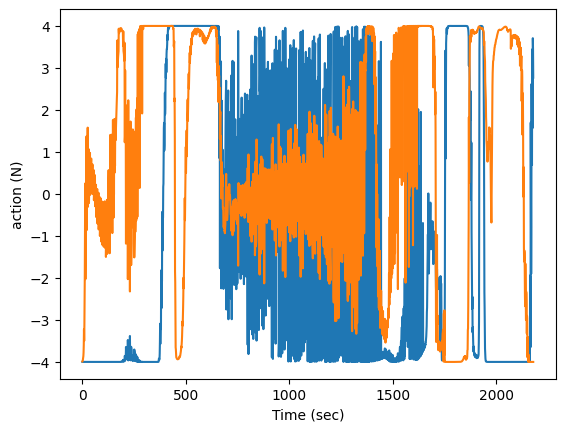

[-0.00882731 -0.00487937 -0.05344142 -0.01271806]
idx 0.03805 state 0.05585216174614162
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.0100059  -0.00070357 -0.04119994  0.00273021]
idx 0.09874 state 0.042491196605308895
too much error 🥲😱
updating  🥰☺️
[-0.00917028 -0.00404343 -0.04613461 -0.00426873]
idx 0.0394 state 0.04740324887418858
too much error 🥲😱
updating  🥰☺️
[-0.00858579 -0.00518681 -0.0484579   0.0135759 ]
idx 0.04271 state 0.0513136623784208
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00868436 -0.00498466 -0.02878524 -0.00790405]
idx 0.03819 state 0.031485380245421475
too much error 🥲😱
updating  🥰☺️
[ 0.00700618 -0.00713553 -0.1000612  -0.17909516]
idx 0.02989 state 0.20539552745648862
too much error 🥲😱
updating  🥰☺️
[-0.00880394 -0.00477952 -0.04417237  0.01264056]
idx 0.04251 state 0.04702483857965043
too much error 🥲😱
updating  🥰☺️
[-0.00399106 -0.00918224 -0.02827869 -0.04017086]
idx 0.03451 state 0.050136053875186236
too much error 🥲😱
updating  🥰

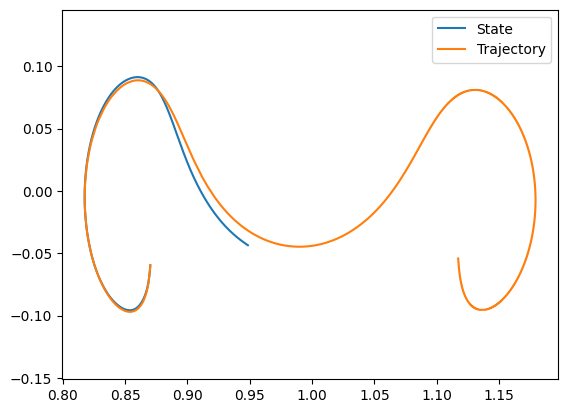

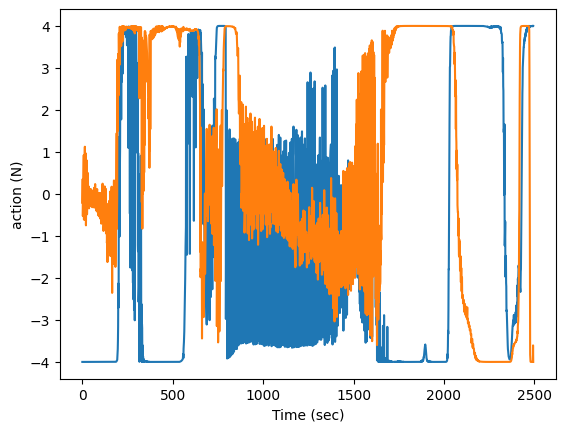

[-0.00488325 -0.00876537 -0.07390557  0.0122637 ]
idx 0.04495 state 0.0755851138657707
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00861884 -0.00511463 -0.056132   -0.01766329]
idx 0.03774 state 0.059692859172695185
too much error 🥲😱
updating  🥰☺️
[ 0.00854575 -0.00523937  0.04957023 -0.00745719]
idx 0.05182 state 0.051120430237619245
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[0.0062217  0.00783876 0.0745233  0.06698682]
idx 0.0639 state 0.10070308783705713
too much error 🥲😱
updating  🥰☺️
[ 0.00771777 -0.00636295  0.03533885 -0.03840594]
idx 0.04926 state 0.05314039751080951
too much error 🥲😱
updating  🥰☺️
[-0.00639058  0.00770284  0.03581032  0.08195638]
idx 0.04805 state 0.08999666701315552
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00650224  0.00761216  0.00536086  0.02691696]
idx 0.05689 state 0.02921447519985295
too much error 🥲😱
updating  🥰☺️
[ 0.00757407 -0.00653038  0.02583942 -0.04646351]
idx 0.0488 state 0.05409756140689593
too much error 🥲😱
updating  🥰☺️
upd

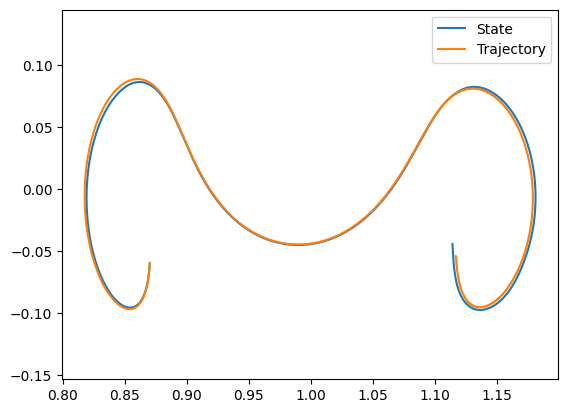

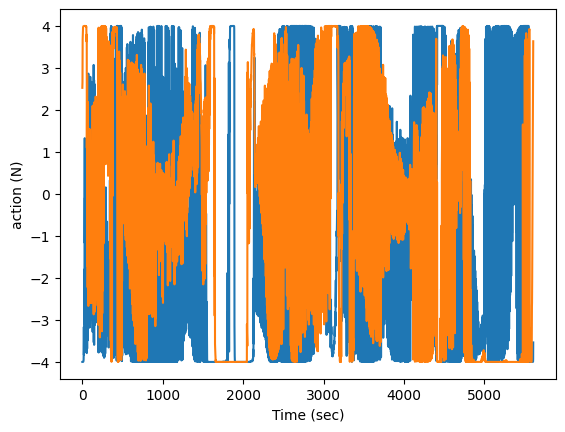

[-2.77297440e-03  9.91314093e-03 -4.33240998e-06  1.08171311e-02]
idx 0.09998 state 0.014932183167148361
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00792158 -0.00618899  0.03099473 -0.0449419 ]
idx 0.04906 state 0.05551128437369133
too much error 🥲😱
updating  🥰☺️
[-0.008374    0.00551279 -0.06053463  0.04836869]
idx 0.05036 state 0.07813121286802419
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00821047  0.00571479 -0.02340124  0.00766127]
idx 0.05432 state 0.026577879886437512
too much error 🥲😱
updating  🥰☺️
[-0.00873008  0.00489928 -0.02466605  0.02766583]
idx 0.05116 state 0.03839309598385939
too much error 🥲😱
updating  🥰☺️
[-0.00867836  0.00502488 -0.03467682  0.0161326 ]
idx 0.05388 state 0.03953866185226203
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00652318  0.00758501 -0.01917488  0.00060448]
idx 0.05685 state 0.02163621443611252
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 6 complete

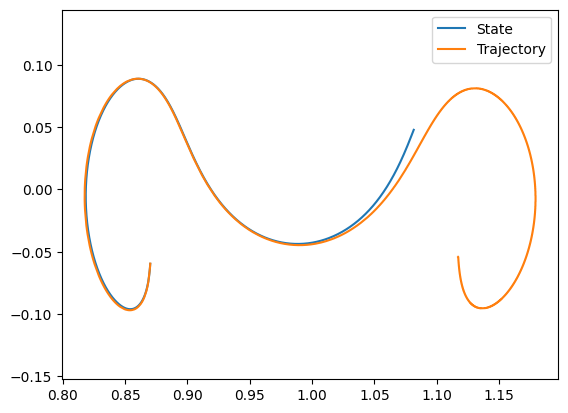

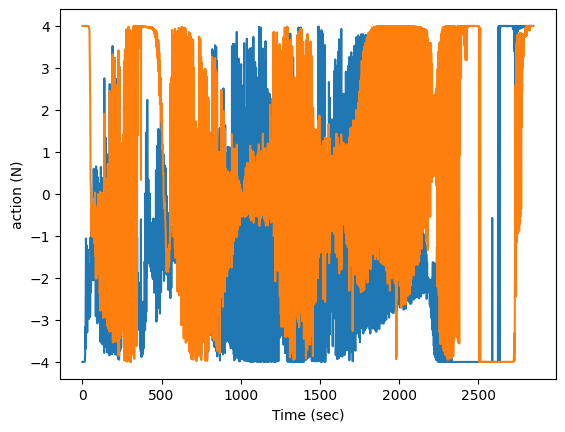

[-0.00894945  0.00461732 -0.02836621  0.01783741]
idx 0.0527 state 0.03498895858474874
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00891011  0.00458698 -0.02821397  0.01897706]
idx 0.05257 state 0.035448373622923336
too much error 🥲😱
updating  🥰☺️
[-0.00854771  0.00520361 -0.02733044  0.01645548]
idx 0.0529 state 0.03343465913889775
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00880144  0.0047683  -0.03033175  0.03193496]
idx 0.05091 state 0.045167006208209404
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00973297 -0.00231253 -0.02059902  0.00280937]
idx 0.0714 state 0.023071425336612692
too much error 🥲😱
updating  🥰☺️
[-0.00865128  0.00502072 -0.02845937  0.02267203]
idx 0.05179 state 0.03773603960244465
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00850587  0.00526363 -0.02343933  0.01509281]
idx 0.05338 state 0.02961842275295171
too much error 🥲😱
updating  🥰☺️
[-0.00873003  0.00494462 -0.02641192  0.01936099]
idx 0.05241 state 0.03425054785593295
too much error 🥲

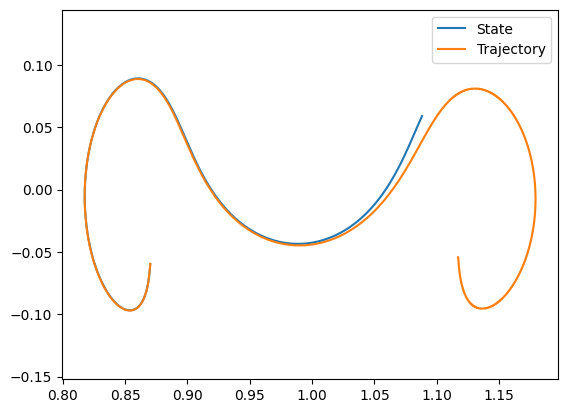

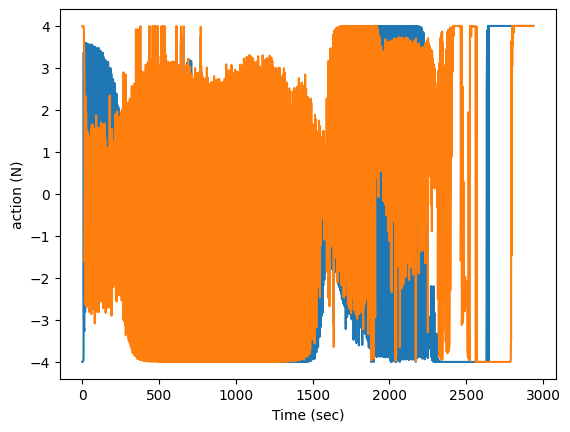

[-0.0086226   0.00510479 -0.02080904  0.01301125]
idx 0.05379 state 0.026508809136391746
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00867184  0.00500982 -0.02142278  0.01374207]
idx 0.05338 state 0.027351036087014526
too much error 🥲😱
updating  🥰☺️
[-0.00854835  0.00520052 -0.01384447  0.01222181]
idx 0.05408 state 0.021003844757531268
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[0.00120189 0.00998771 0.00580223 0.01417741]
idx 0.09998 state 0.018326579836769556
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00977041 -0.00213962  0.01144303  0.01873712]
idx 0.07886 state 0.024125944031186605
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00934589 -0.00356511 -0.02067095 -0.00029636]
idx 0.06904 state 0.022965880619401222
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00931805  0.0036589  -0.00636978  0.01535533]
idx 0.08155 state 0.01940551036712655
too much error 🥲😱
updating  🥰☺️
[-0.00770868  0.00639338 -0.00334787  0.02574864]
idx 0.0556

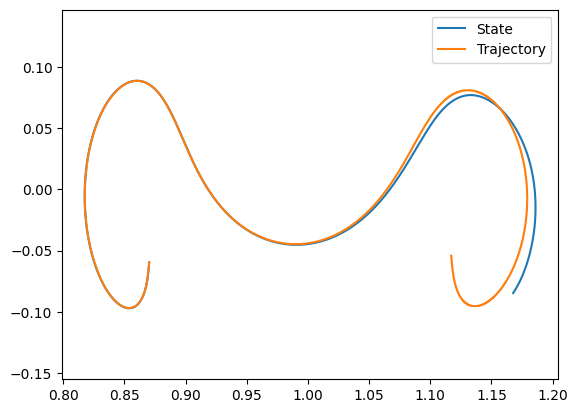

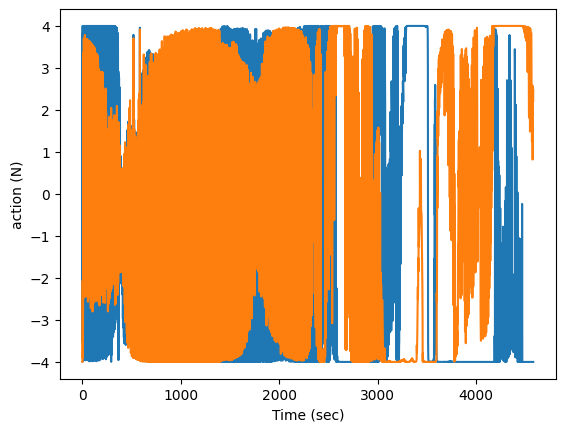

[ 0.00798579 -0.00603105  0.00789926  0.00891654]
idx 0.08424 state 0.01555793822201773
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[-0.0082276   0.00569881 -0.02023762  0.0113086 ]
idx 0.05379 state 0.025251048078776216
too much error 🥲😱
updating  🥰☺️
[-0.00795047  0.00606732 -0.0078154   0.01742563]
idx 0.05522 state 0.021558189771675965
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[0.00909701 0.00422306 0.05365626 0.01676491]
idx 0.09515 state 0.05710206705284034
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
Epoch 9 completed in 565.75 sec
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |       -1.94e+03 |
|          StdEpRet |         1.4e+03 |
|          MaxEpRet |            -130 |
|          MinEpRet |       -4.35e+03 |
|             EpLen |        4.43e+03 |
| TotalEnvInteracts |         2.7e+

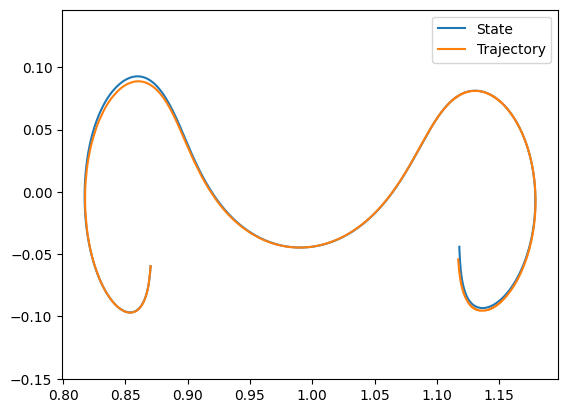

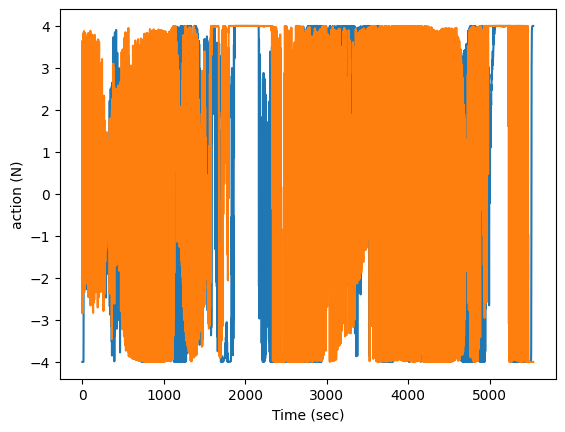

[0.0008969  0.01025473 0.0040578  0.01162634]
idx 0.09998 state 0.016049968986579104
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[0.00083258 0.01010872 0.0040285  0.0115142 ]
idx 0.09998 state 0.01586458524525762
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[-0.00315983  0.00958221 -0.00382095  0.01910625]
idx 0.09998 state 0.021942004322203536
too much error 🥲😱
updating  🥰☺️
Epoch 10 completed in 628.85 sec
---------------------------------------
|             Epoch |              10 |
|      AverageEpRet |       -1.59e+03 |
|          StdEpRet |        1.51e+03 |
|          MaxEpRet |            -104 |
|          MinEpRet |       -4.21e+03 |
|             EpLen |        4.88e+03 |
| TotalEnvInteracts |           3e+05 |
|      AverageQVals |           -56.2 |
|          StdQVals |             137 |
|          MaxQVals |   

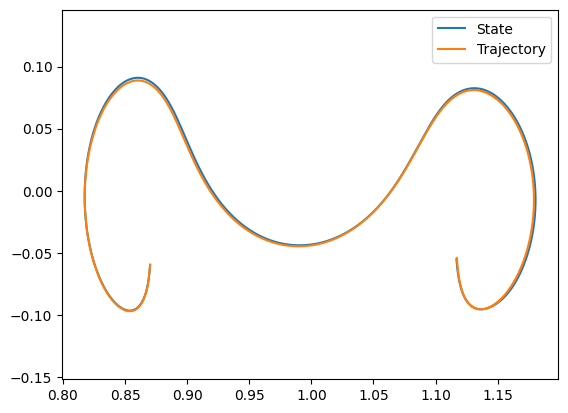

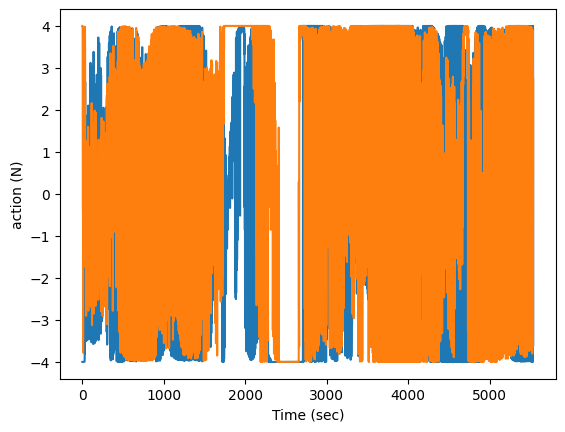

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00185311  0.00996286 -0.00050213  0.01590994]
idx 0.09998 state 0.018869842876276327
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00275373  0.00975291 -0.00142812  0.01912907]
idx 0.09998 state 0.02169477377256692
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00199814  0.0098223  -0.00095087  0.01909665]
idx 0.09998 state 0.02158833466655452
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[0.00074298 0.010127   0.00302249 0.01142367]
idx 0.09998 state 0.0155802382651284
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 11 completed in 691.84 sec
---------------------------------------
|             Epoch |              11 |
|      AverageEpRet |       -1.12e+03 |
|          StdEpRet |        1.28e+03 |
|          MaxEpRet |             728 |
|          MinEpRet |       -2.93e+03 |
|             EpLen |        4.98e+03 |
| TotalEnvInteracts |         3.3e+05 |
|  

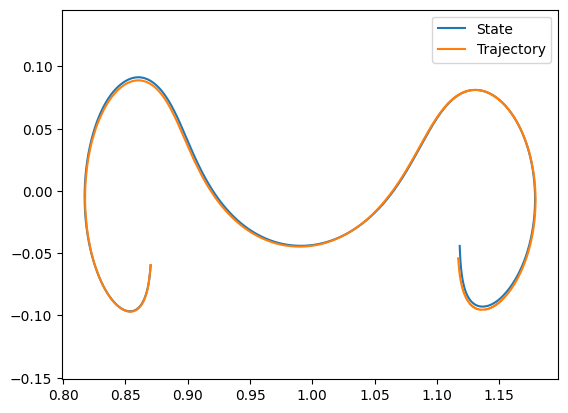

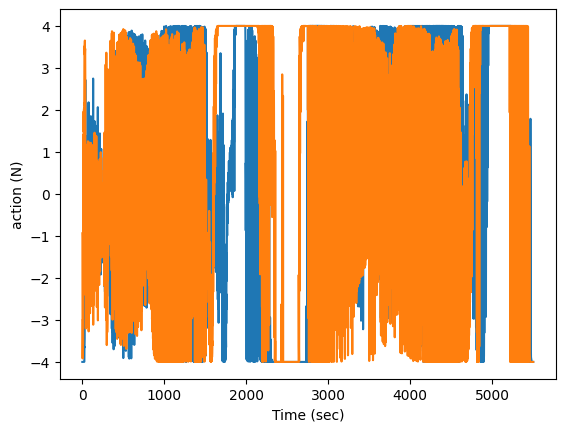

[0.00118363 0.01015117 0.00266989 0.01119451]
idx 0.09998 state 0.015391316779809601
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 12 completed in 754.17 sec
---------------------------------------
|             Epoch |              12 |
|      AverageEpRet |           -49.3 |
|          StdEpRet |             456 |
|          MaxEpRet |             409 |
|          MinEpRet |            -875 |
|             EpLen |        4.98e+03 |
| TotalEnvInteracts |         3.6e+05 |
|      AverageQVals |           -53.9 |
|          StdQVals |             127 |
|          MaxQVals |            62.1 |
|          MinQVals |            -746 |
|            LossPi |            53.6 |
|             LossQ |            48.9 |
|              Time |             754 |
-------------------

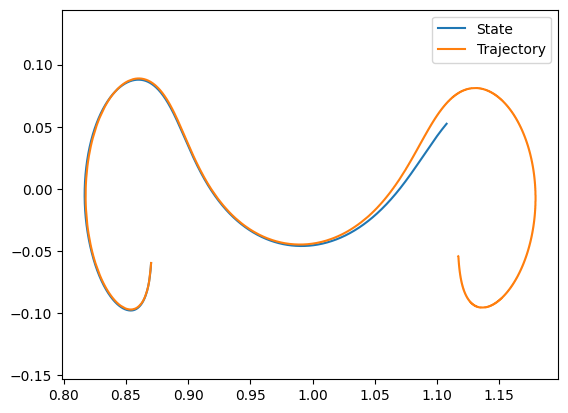

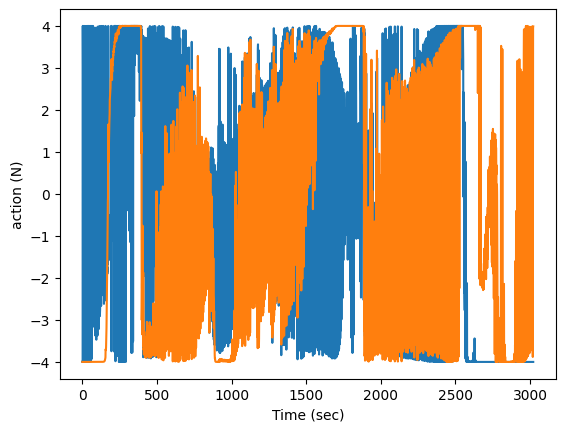

[ 0.00859124 -0.00518875  0.01565323 -0.01347084]
idx 0.05421 state 0.022961263633750863
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 13 completed in 815.37 sec
---------------------------------------
|             Epoch |              13 |
|      AverageEpRet |            -519 |
|          StdEpRet |             598 |
|          MaxEpRet |              41 |
|          MinEpRet |       -1.75e+03 |
|             EpLen |        4.97e+03 |
| TotalEnvInteracts |         3.9e+05 |
|      AverageQVals |             -51 |
|          StdQVals |             123 |
|          MaxQVals |            51.8 |
|          MinQVals |            -760 |
|            LossPi |            50.7 |
|             LossQ |              62 |
|              Time |             815 |
---------------

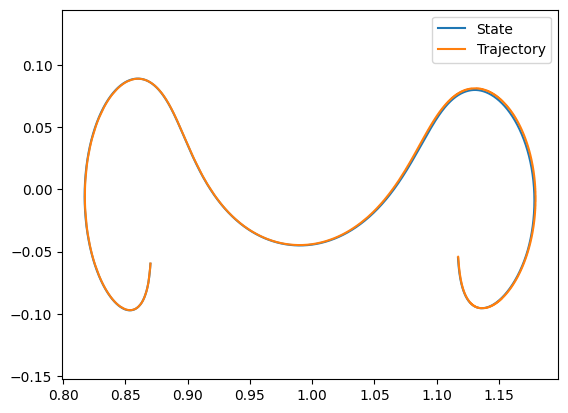

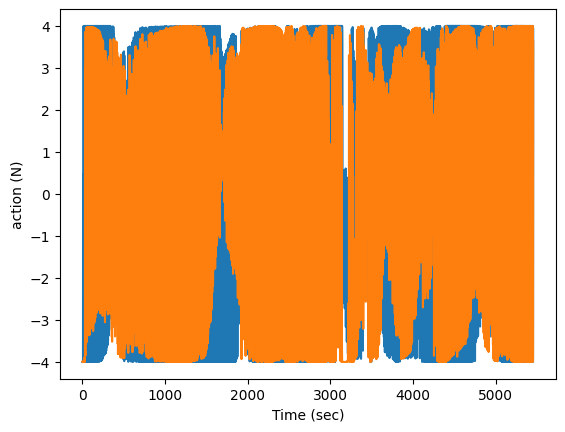

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 14 completed in 878.44 sec
---------------------------------------
|             Epoch |              14 |
|      AverageEpRet |            -287 |
|          StdEpRet |             559 |
|          MaxEpRet |             625 |
|          MinEpRet |            -969 |
|             EpLen |        4.98e+03 |
| TotalEnvInteracts |         4.2e+05 |
|      AverageQVals |             -47 |
|          StdQVals |             121 |
|          MaxQVals |            43.5 |
|          MinQVals |            -765 |
|            LossPi |            46.7 |
|             LossQ |            67.8 |
|              Time |             879 |
---------------------------------------
done 🥺
(9999, 6)


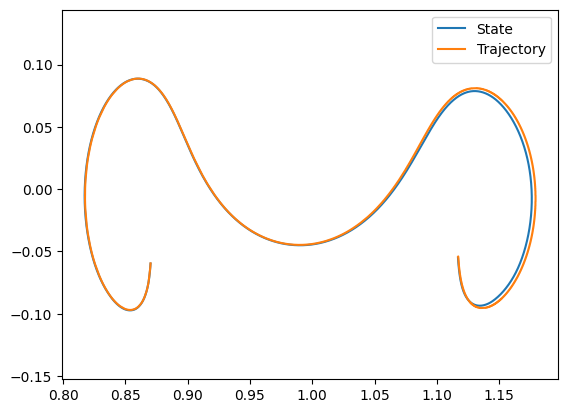

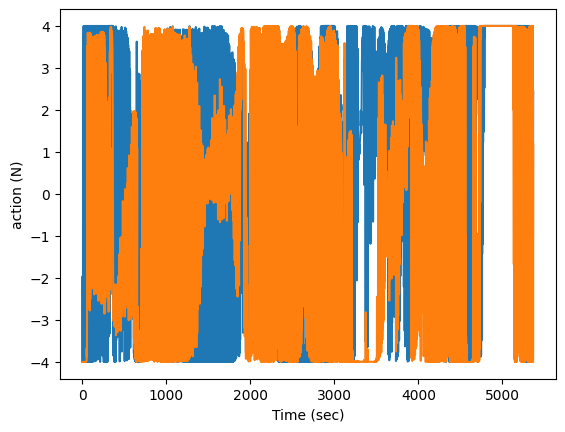

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 15 completed in 940.98 sec
---------------------------------------
|             Epoch |              15 |
|      AverageEpRet |            -154 |
|          StdEpRet |             402 |
|          MaxEpRet |             453 |
|          MinEpRet |            -897 |
|             EpLen |        5.05e+03 |
| TotalEnvInteracts |         4.5e+05 |
|      AverageQVals |           -43.1 |
|          StdQVals |             118 |
|          MaxQVals |            33.6 |
|          MinQVals |            -769 |
|            LossPi |            42.8 |
|             LossQ |            71.5 |
|              Time |             941 |
---------------------------------------
done 🥺
(9999, 6)


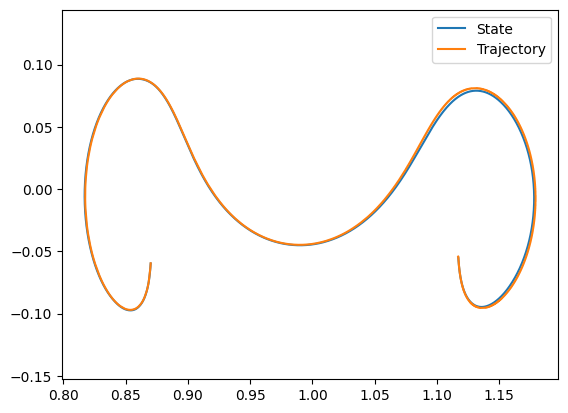

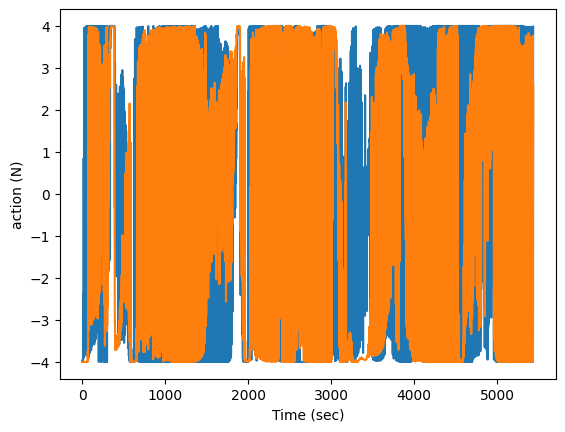

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 16 completed in 1003.07 sec
---------------------------------------
|             Epoch |              16 |
|      AverageEpRet |            -234 |
|          StdEpRet |             360 |
|          MaxEpRet |             471 |
|          MinEpRet |            -666 |
|             EpLen |        4.97e+03 |
| TotalEnvInteracts |         4.8e+05 |
|      AverageQVals |           -39.6 |
|          StdQVals |             115 |
|          MaxQVals |              28 |
|          MinQVals |            -773 |
|            LossPi |            39.3 |
|             LossQ |              92 |
|              Time |           1e+03 |
---------------------------------------
done 🥺
(9999, 6)


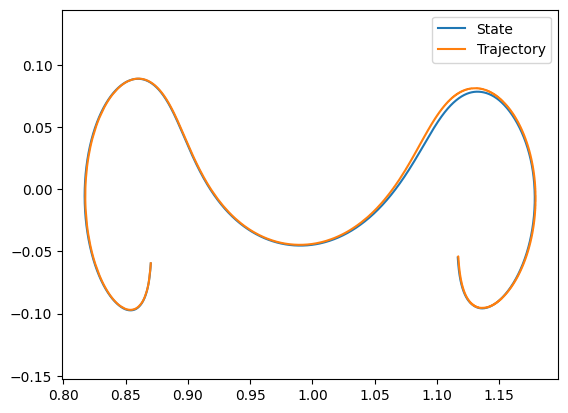

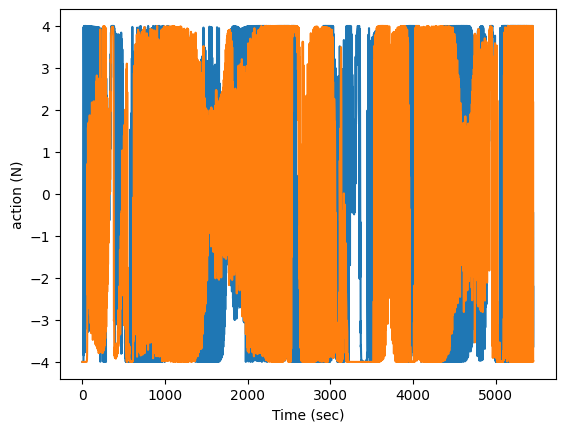

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
[ 0.00756663 -0.00655193  0.02526681  0.00582017]
idx 0.05578 state 0.027793305970008536
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 4.20188904e-03  9.10268173e-03  8.78601934e-03 -9.69866153e-05]
idx 0.09998 state 0.013331100042400906
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
Epoch 17 completed in 1065.33 sec
---------------------------------------
|             Epoch |              17 |
|      AverageEpRet |       -1.46e+03 |
|          StdEpRet |        1.55e+03 |
|          MaxEpRet |             283 |
|          MinEpRet |       -4.15e+03 |
|             EpLen |        4.69e+03 |
| TotalEnvInteracts |         5.1e+05 |
|      AverageQVals |           -37.1 |
|          StdQVals |             113 |
|          MaxQVals |            28.6 |
|          MinQVals |            -776 |
|            LossP

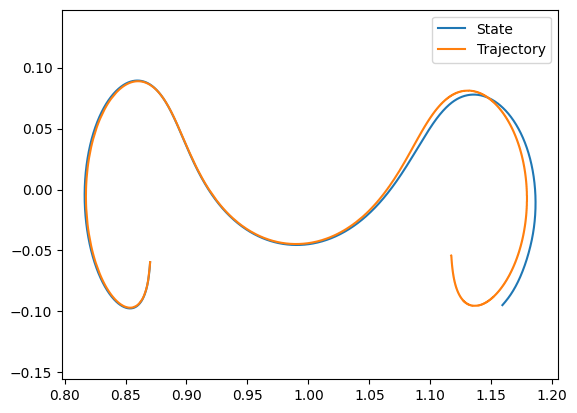

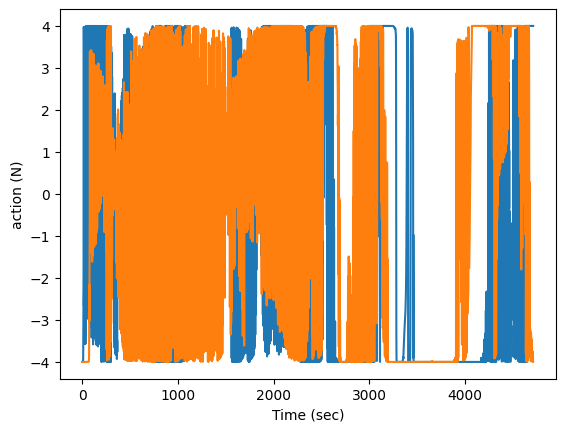

[ 0.00711319 -0.00704512  0.01347242  0.00213682]
idx 0.08629 state 0.01692049387606776
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[ 0.00971836  0.00238928  0.02612006 -0.00132804]
idx 0.07056 state 0.02800314473224077
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
Epoch 18 completed in 1127.22 sec
---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |       -1.36e+03 |
|          StdEpRet |         1.3e+03 |
|          MaxEpRet |            -145 |
|          MinEpRet |       -3.81e+03 |
|             EpLen |        5.06e+03 |
| TotalEnvInteracts |         5.4e+05 |
|      AverageQVals |           -35.5 |
|          StdQVals |             110 |
|          MaxQVals |            57.3 |
|          MinQVals |            -778 |
|            LossPi |            35.

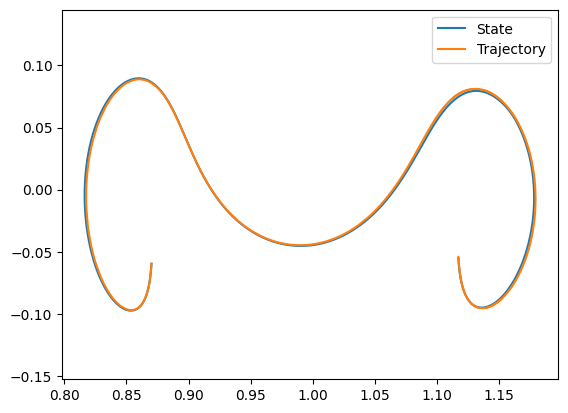

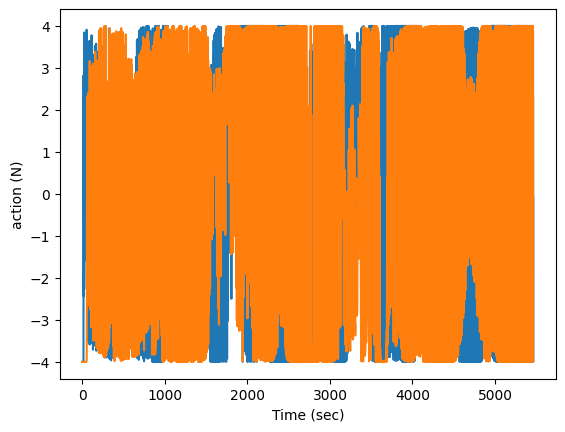

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.00905519  0.00438879  0.02554766 -0.01175526]
idx 0.09997 state 0.029868493064097498
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00157597  0.00994285  0.00343334  0.01399203]
idx 0.09998 state 0.017575798336774494
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00152764  0.00996617  0.00200584  0.01367351]
idx 0.09998 state 0.01710691268118408
too much error 🥲😱
updating  🥰☺️
Epoch 19 completed in 1190.74 sec
---------------------------------------
|             Epoch |              19 |
|      AverageEpRet |       -1.99e+03 |
|          StdEpRet |        1.81e+03 |
|          MaxEpRet |             142 |
|          MinEpRet |       -5.55e+03 |
|             EpLen |        5.33e+03 |
| TotalEnvInteracts |         5.7e+05 |
|      AverageQVals |           -34.3 |
|          StdQVals |             109 |
|          MaxQ

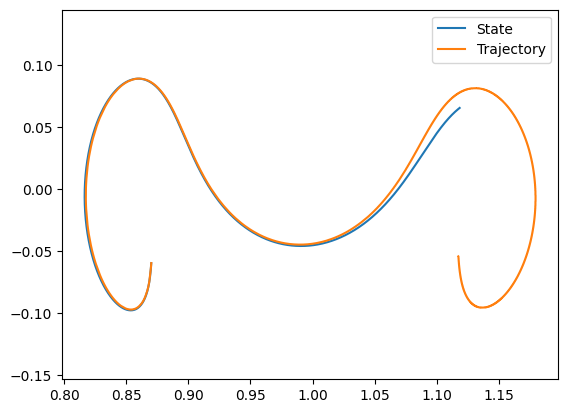

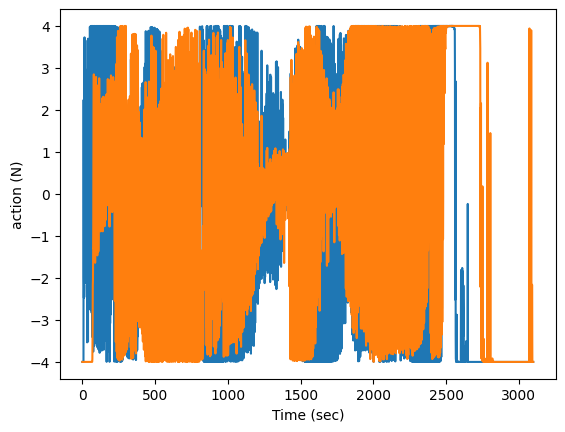

[ 0.00694852 -0.00722663  0.0162662  -0.00083714]
idx 0.05651 state 0.01912579649722133
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00957911  0.00292541  0.02702966 -0.00323121]
idx 0.07035 state 0.0290062223705666
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
Epoch 20 completed in 1251.93 sec
---------------------------------------
|             Epoch |              20 |
|      AverageEpRet |       -1.23e+03 |
|          StdEpRet |        1.13e+03 |
|          MaxEpRet |            -439 |
|          MinEpRet |       -3.74e+03 |
|             EpLen |        4.65e+03 |
| TotalEnvInteracts |           6e+05 |
|      AverageQVals |           -34.1 |
|          StdQVals |             107 |
|          MaxQVals |              21 |
|          MinQVals |            -782 |
|            LossPi |            33.9

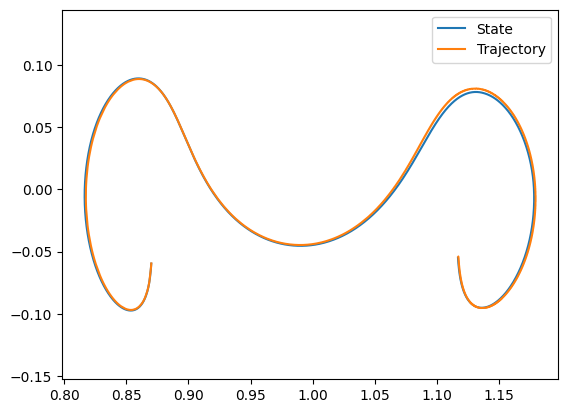

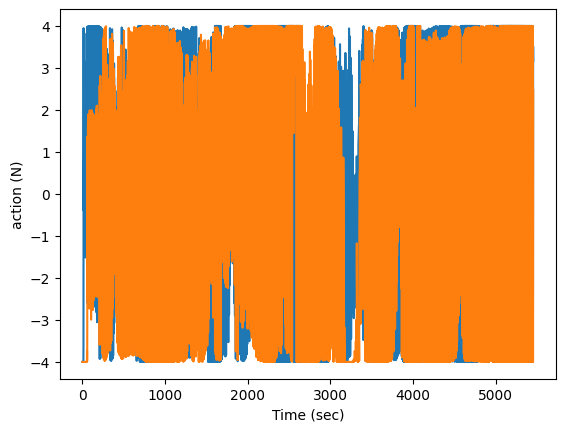

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 21 completed in 1314.46 sec
---------------------------------------
|             Epoch |              21 |
|      AverageEpRet |           -86.7 |
|          StdEpRet |             110 |
|          MaxEpRet |             105 |
|          MinEpRet |            -254 |
|             EpLen |        5.32e+03 |
| TotalEnvInteracts |         6.3e+05 |
|      AverageQVals |           -33.3 |
|          StdQVals |             105 |
|          MaxQVals |            89.6 |
|          MinQVals |            -784 |
|            LossPi |              33 |
|             LossQ |            96.1 |
|              Time |        1.31e+03 |
---------------------------------------
done 🥺
(9999, 6)


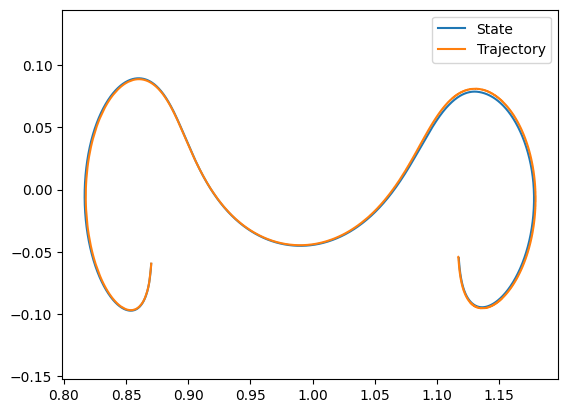

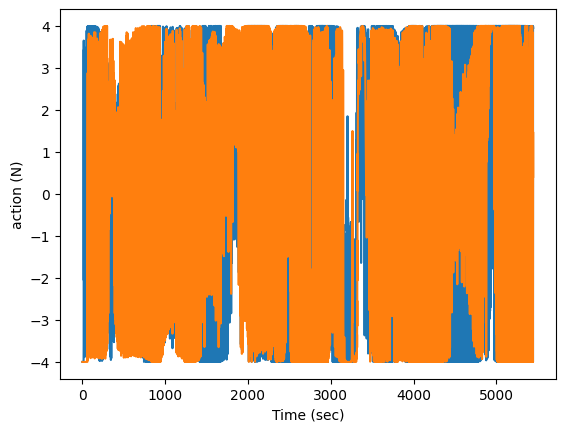

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 22 completed in 1376.59 sec
---------------------------------------
|             Epoch |              22 |
|      AverageEpRet |              17 |
|          StdEpRet |             232 |
|          MaxEpRet |             518 |
|          MinEpRet |            -152 |
|             EpLen |        5.01e+03 |
| TotalEnvInteracts |         6.6e+05 |
|      AverageQVals |           -31.9 |
|          StdQVals |             102 |
|          MaxQVals |             184 |
|          MinQVals |            -786 |
|            LossPi |            31.7 |
|             LossQ |             101 |
|              Time |        1.38e+03 |
---------------------------------------
done 🥺
(9999, 6)


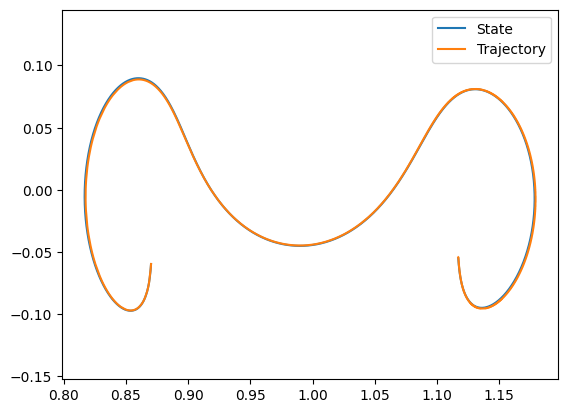

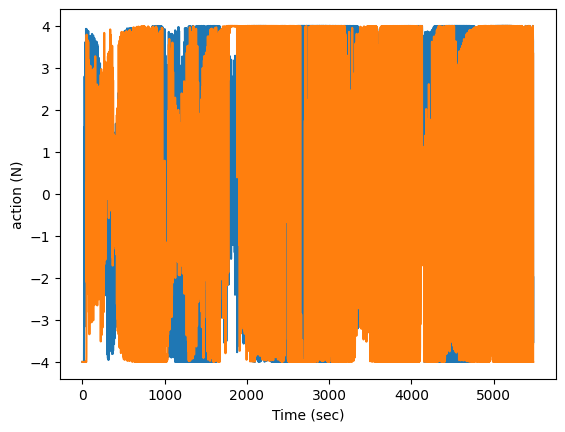

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[0.00077168 0.01000517 0.00350034 0.01300623]
idx 0.09998 state 0.016796223576762817
too much error 🥲😱
updating  🥰☺️
Epoch 23 completed in 1439.07 sec
---------------------------------------
|             Epoch |              23 |
|      AverageEpRet |            -244 |
|          StdEpRet |             540 |
|          MaxEpRet |             477 |
|          MinEpRet |       -1.31e+03 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |         6.9e+05 |
|      AverageQVals |           -30.2 |
|          StdQVals |            99.5 |
|          MaxQVals |             174 |
|          MinQVals |            -787 |
|            LossPi |            29.9 |
|             LossQ |             109 |
|              Time |        1.44e+03 |
------------------

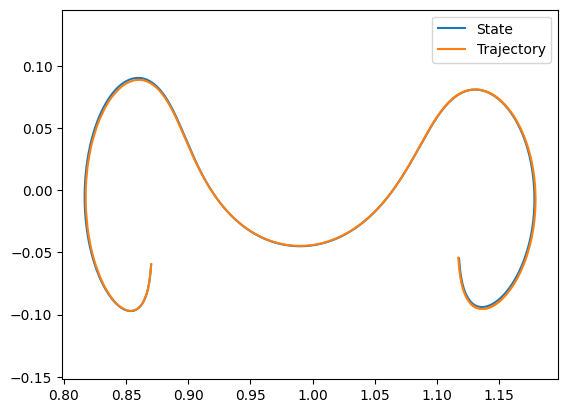

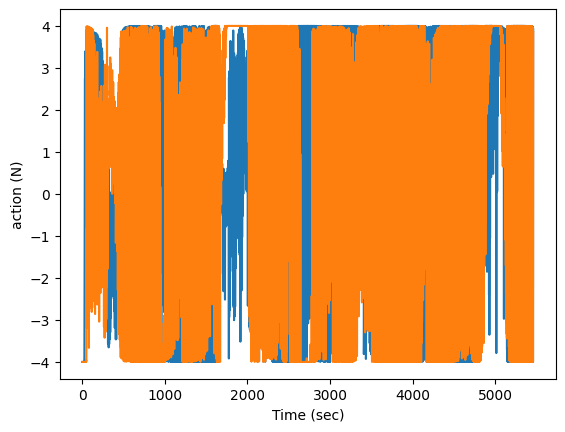

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 24 completed in 1501.93 sec
---------------------------------------
|             Epoch |              24 |
|      AverageEpRet |            -161 |
|          StdEpRet |             224 |
|          MaxEpRet |             331 |
|          MinEpRet |            -298 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |         7.2e+05 |
|      AverageQVals |           -28.7 |
|          StdQVals |            97.5 |
|          MaxQVals |             134 |
|          MinQVals |            -789 |
|            LossPi |            28.5 |
|             LossQ |             110 |
|              Time |         1.5e+03 |
---------------------------------------
done 🥺
(9999, 6)


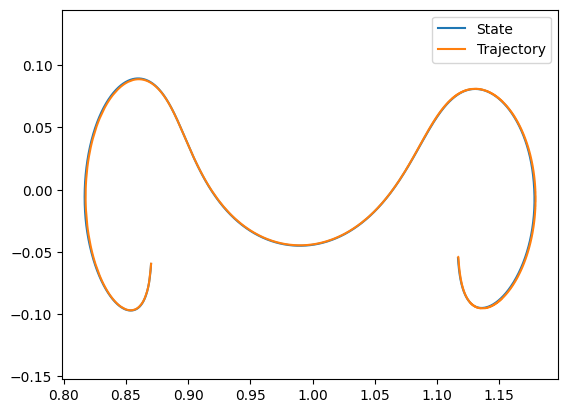

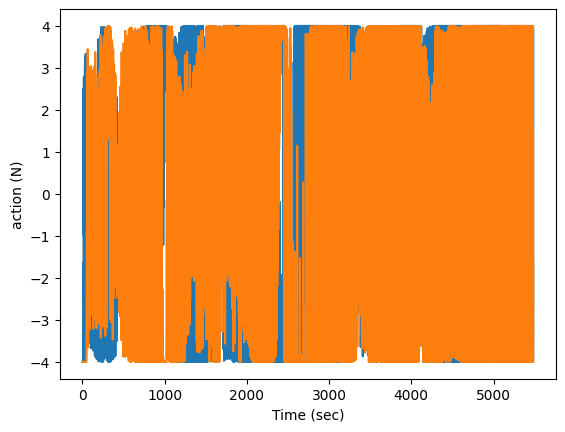

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 25 completed in 1565.31 sec
---------------------------------------
|             Epoch |              25 |
|      AverageEpRet |            -279 |
|          StdEpRet |             287 |
|          MaxEpRet |             350 |
|          MinEpRet |            -498 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |         7.5e+05 |
|      AverageQVals |           -27.5 |
|          StdQVals |            95.7 |
|          MaxQVals |            79.3 |
|          MinQVals |            -791 |
|            LossPi |            27.3 |
|             LossQ |             112 |
|              Time |        1.57e+03 |
---------------------------------------
done 🥺
(9999, 6)


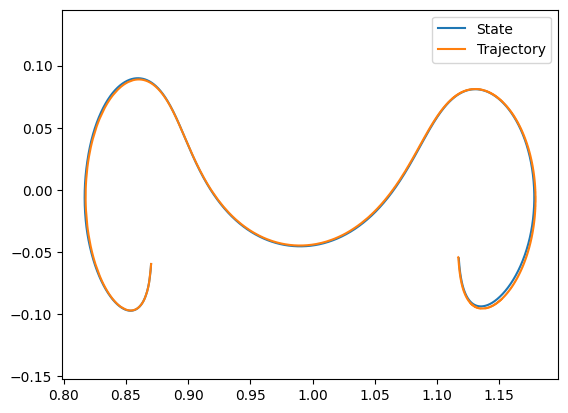

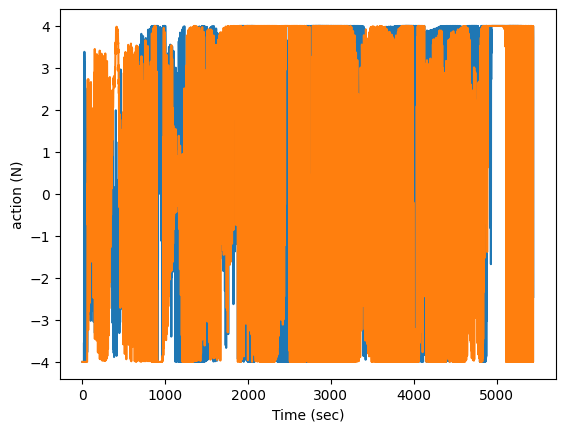

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 26 completed in 1629.01 sec
---------------------------------------
|             Epoch |              26 |
|      AverageEpRet |            -574 |
|          StdEpRet |             465 |
|          MaxEpRet |             299 |
|          MinEpRet |       -1.23e+03 |
|             EpLen |        4.99e+03 |
| TotalEnvInteracts |         7.8e+05 |
|      AverageQVals |           -26.1 |
|          StdQVals |              94 |
|          MaxQVals |              32 |
|          MinQVals |            -793 |
|            LossPi |            25.8 |
|             LossQ |             116 |
|              Time |        1.63e+03 |
---------------------------------------
[-0.00194617  0.00987507  0.00034607  0.0154416 ]
idx 0.09998 state 0.0184

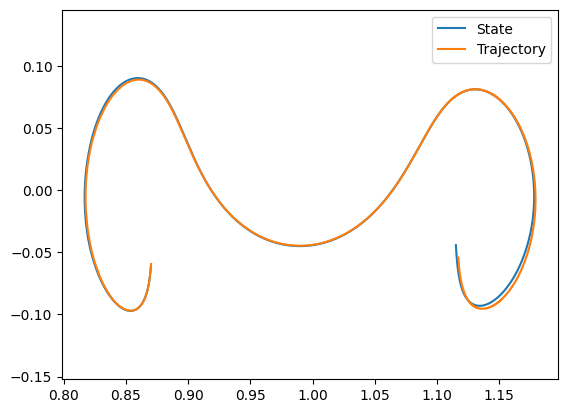

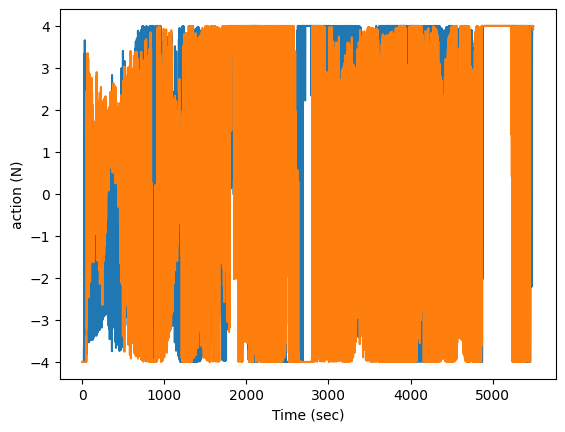

[-0.00195452  0.01004301  0.00034684  0.01562545]
idx 0.09998 state 0.018680392582952187
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-1.83371762e-03  9.85390074e-03  4.72806634e-05  1.50562034e-02]
idx 0.09998 state 0.01808738167239386
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 27 completed in 1693.27 sec
---------------------------------------
|             Epoch |              27 |
|      AverageEpRet |            -768 |
|          StdEpRet |             512 |
|          MaxEpRet |            -375 |
|          MinEpRet |       -1.87e+03 |
|             EpLen |        4.99e+03 |
| TotalEnvInteracts |         8.1e+05 |
|      AverageQVals |           -25.3 |
|          StdQVals |            92.1 |
|          MaxQVals |            26.1 |
|          MinQVals |            -794 |
|            LossPi

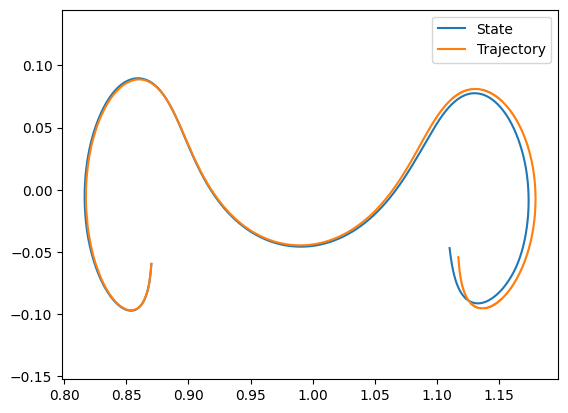

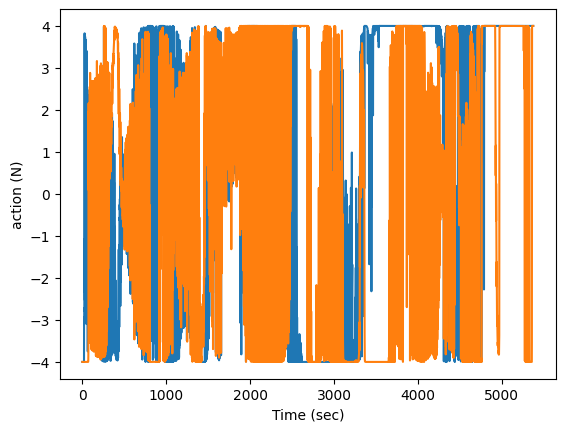

[-0.00708092  0.00740285 -0.0117493   0.02311169]
idx 0.09998 state 0.02787718874705402
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00876029 -0.00484836  0.02125809 -0.01353634]
idx 0.05347 state 0.027118040148591014
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00180586  0.009993    0.00081133  0.01551094]
idx 0.09998 state 0.018557177479349582
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00322288  0.00953185  0.00100073  0.01960816]
idx 0.09998 state 0.022061831512493264
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00493571  0.00875219 -0.00345656  0.02162876]
idx 0.09998 state 0.024097988776603362
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
Epoch 28 completed in 1757.37 sec
---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |       -1.65e+03 |
|          StdEpRet |             927 |
|          MaxEpRet |            -180 |
|          MinE

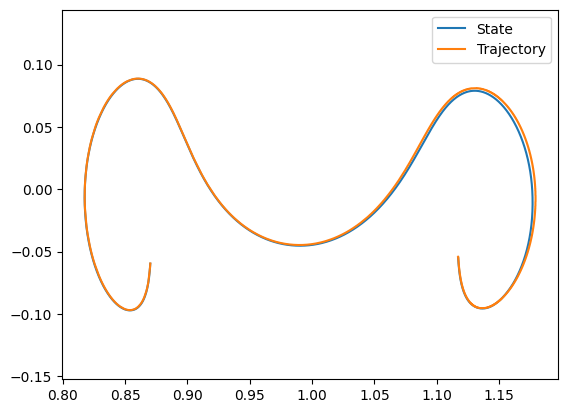

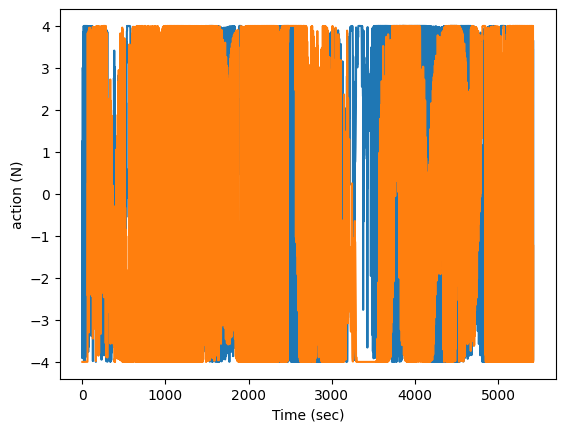

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[ 0.00826694 -0.00565073  0.01822518 -0.01245565]
idx 0.05399 state 0.024239913390992376
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
Epoch 29 completed in 1821.11 sec
---------------------------------------
|             Epoch |              29 |
|      AverageEpRet |            -671 |
|          StdEpRet |             747 |
|          MaxEpRet |            -171 |
|          MinEpRet |       -2.31e+03 |
|             EpLen |        4.99e+03 |
| TotalEnvInteracts |         8.7e+05 |
|      AverageQVals |           -24.8 |
|          StdQVals |            89.5 |
|          MaxQVals |            36.8 |
|          MinQVals |            -797 |
|            LossPi |            24.6 |
|             LossQ |             118 |
|              Time |        1.82e+03 |
--------------

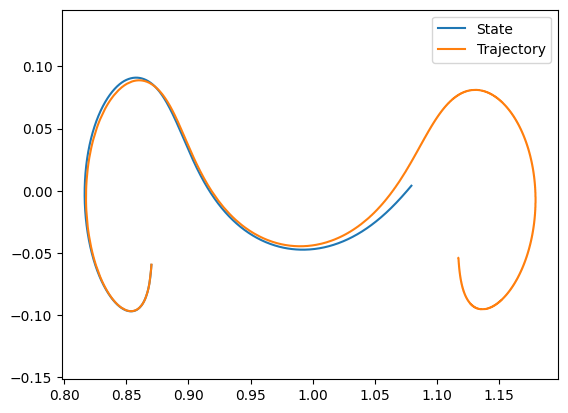

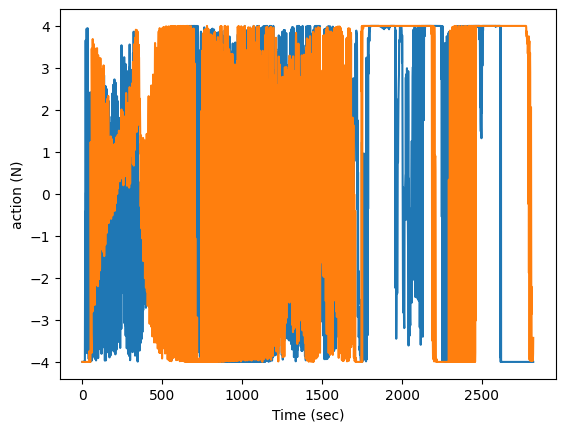

[ 0.00839944 -0.00553489  0.02925874 -0.0295872 ]
idx 0.05014 state 0.04280960346234534
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 30 completed in 1882.34 sec
---------------------------------------
|             Epoch |              30 |
|      AverageEpRet |            -392 |
|          StdEpRet |             745 |
|          MaxEpRet |             295 |
|          MinEpRet |       -1.98e+03 |
|             EpLen |        5.41e+03 |
| TotalEnvInteracts |           9e+05 |
|      AverageQVals |           -24.4 |
|          StdQVals |            88.2 |
|          MaxQVals |              22 |
|          MinQVals |            -799 |
|            LossPi |            24.3 |
|             LossQ |             116 |
|              Time |        1.88e+03 |
---------------

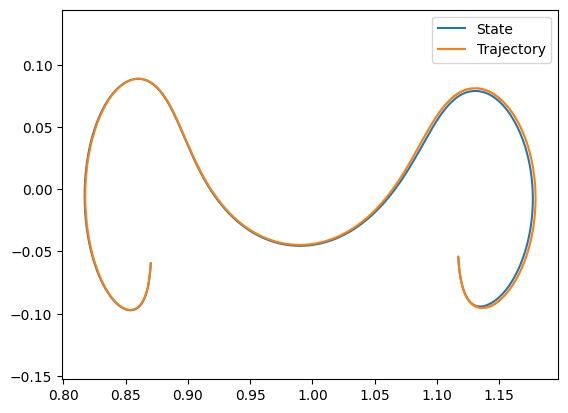

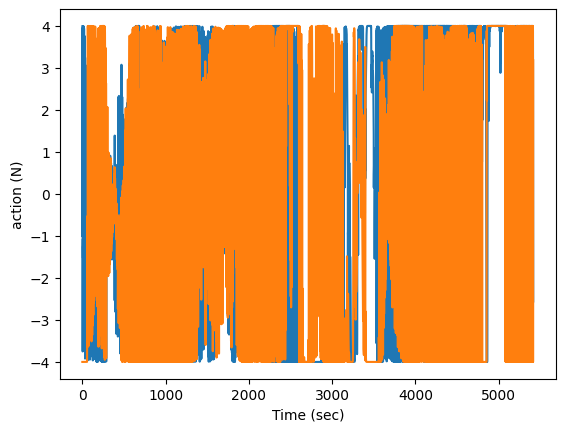

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00443862  0.00901757  0.00421148  0.01840259]
idx 0.09998 state 0.021387144933131177
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00157754  0.01003735  0.00305278  0.01381706]
idx 0.09998 state 0.017420319586203943
too much error 🥲😱
updating  🥰☺️
Epoch 31 completed in 1944.78 sec
---------------------------------------
|             Epoch |              31 |
|      AverageEpRet |       -1.33e+03 |
|          StdEpRet |        1.58e+03 |
|          MaxEpRet |             634 |
|          MinEpRet |       -4.02e+03 |
|             EpLen |        4.98e+03 |
| TotalEnvInteracts |         9.3e+05 |
|      AverageQVals |           -23.7 |
|          StdQVals |            87.2 |
|          MaxQVals |            19.6 |
|          MinQVals |            -800 |
|            LossPi |            2

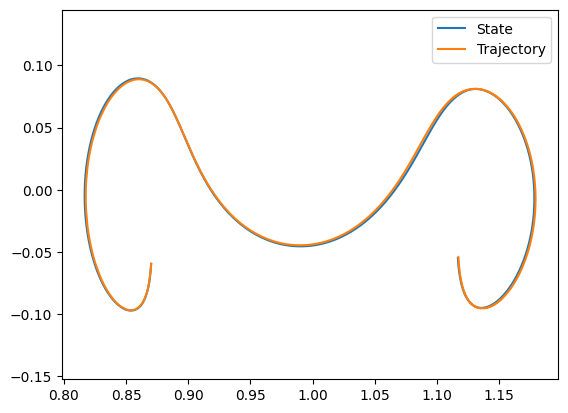

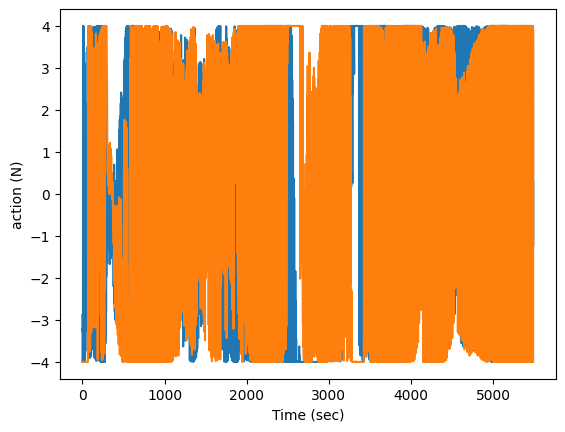

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00511245  0.00861999 -0.00385753  0.02240662]
idx 0.09998 state 0.024847105529991524
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00477189  0.00890679 -0.00260651  0.02227819]
idx 0.09998 state 0.02460108469300058
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 32 completed in 2007.21 sec
---------------------------------------
|             Epoch |              32 |
|      AverageEpRet |       -1.08e+03 |
|          StdEpRet |         1.4e+03 |
|          MaxEpRet |             408 |
|          MinEpRet |       -2.94e+03 |
|             EpLen |        4.97e+03 |
| TotalEnvInteracts |         9.6e+05 |
|      AverageQVals |           -23.1 |
|          StdQVals |            85.9 |
|          MaxQVals |            17.6 |
|          MinQVals |            -801 |
|            LossPi |            22

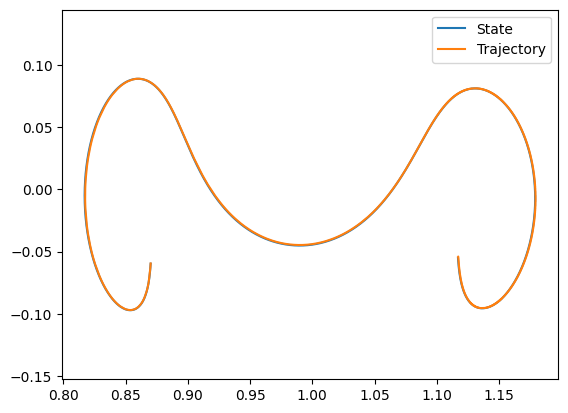

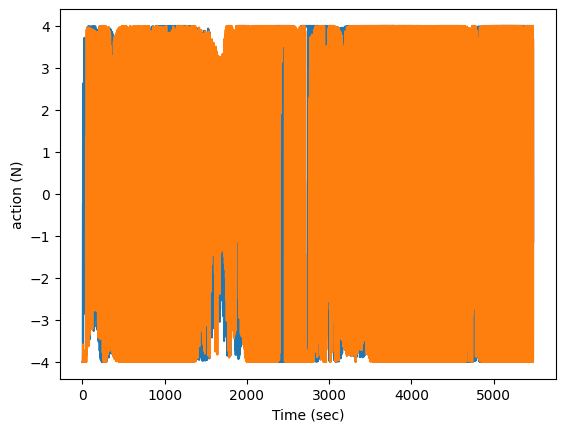

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 33 completed in 2069.47 sec
---------------------------------------
|             Epoch |              33 |
|      AverageEpRet |            -105 |
|          StdEpRet |             468 |
|          MaxEpRet |             611 |
|          MinEpRet |            -771 |
|             EpLen |        5.03e+03 |
| TotalEnvInteracts |         9.9e+05 |
|      AverageQVals |           -22.4 |
|          StdQVals |              85 |
|          MaxQVals |            20.6 |
|          MinQVals |            -802 |
|            LossPi |            22.2 |
|             LossQ |             119 |
|              Time |        2.07e+03 |
---------------------------------------
done 🥺
(9999, 6)


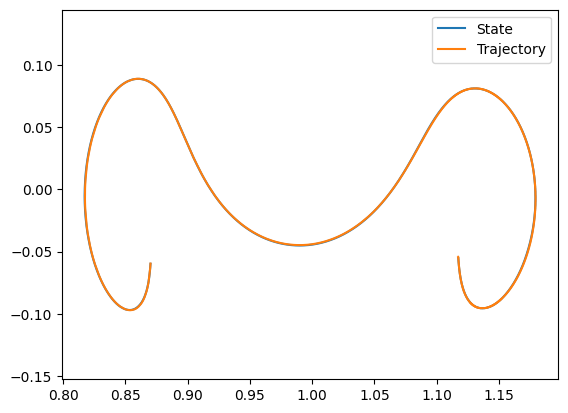

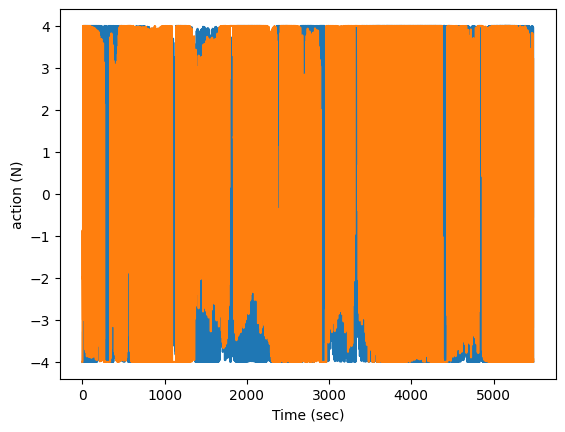

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 34 completed in 2132.41 sec
---------------------------------------
|             Epoch |              34 |
|      AverageEpRet |            -302 |
|          StdEpRet |             662 |
|          MaxEpRet |             639 |
|          MinEpRet |       -1.47e+03 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |        1.02e+06 |
|      AverageQVals |           -21.2 |
|          StdQVals |            82.8 |
|          MaxQVals |            18.7 |
|          MinQVals |            -803 |
|            LossPi |              21 |
|             LossQ |             130 |
|              Time |        2.13e+03 |
---------------------------------------
done 🥺
(9999, 6)


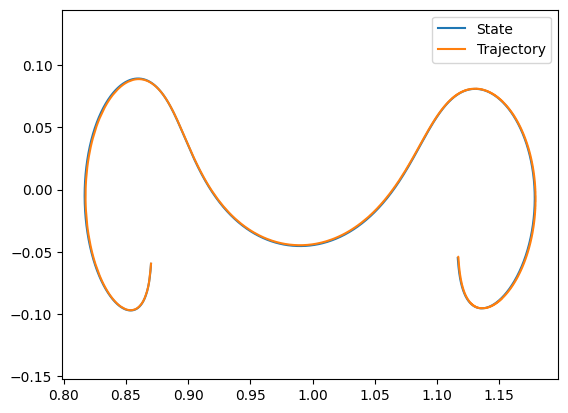

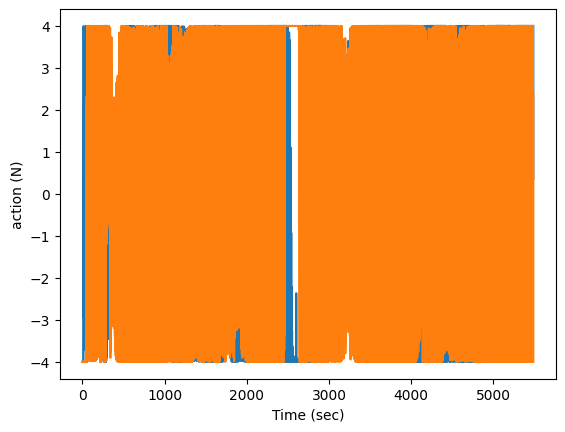

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[-0.00436771  0.00907169 -0.0012441   0.02075775]
idx 0.09998 state 0.023104211380154966
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 35 completed in 2194.62 sec
---------------------------------------
|             Epoch |              35 |
|      AverageEpRet |            -645 |
|          StdEpRet |        1.12e+03 |
|          MaxEpRet |             562 |
|          MinEpRet |       -3.02e+03 |
|             EpLen |        5.02e+03 |
| TotalEnvInteracts |        1.05e+06 |
|      AverageQVals |             -18 |
|          StdQVals |            77.4 |
|          MaxQVals |            26.5 |
|          MinQVals |            -804 |
|            LossPi |            17.8 |
|             LossQ |             130 |
|              Time |        2.19e+03 |
--------------

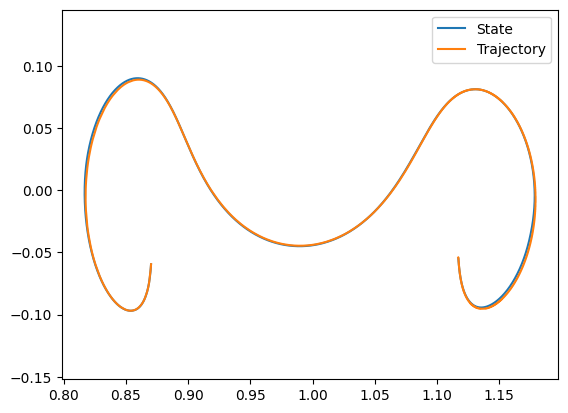

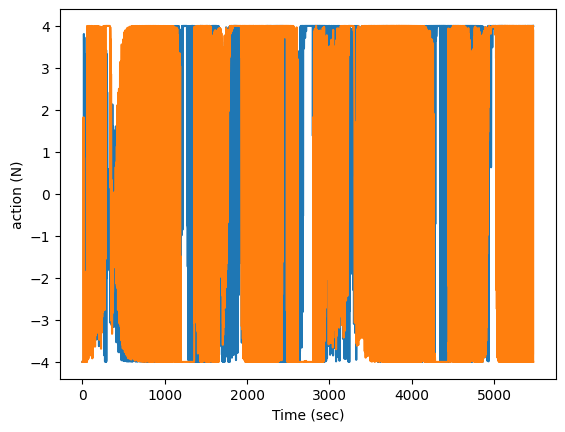

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00388589  0.00929613  0.00120244  0.0182927 ]
idx 0.09998 state 0.020918575315346796
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00215893  0.00987421  0.0015146   0.01253402]
idx 0.09998 state 0.016172716406454072
too much error 🥲😱
updating  🥰☺️
Epoch 36 completed in 2257.48 sec
---------------------------------------
|             Epoch |              36 |
|      AverageEpRet |            -816 |
|          StdEpRet |        1.28e+03 |
|          MaxEpRet |             347 |
|          MinEpRet |       -2.69e+03 |
|             EpLen |        4.98e+03 |
| TotalEnvInteracts |        1.08e+06 |
|      AverageQVals |           -14.4 |
|          StdQVals |            69.4 |
|          MaxQVals |            23.7 |
|          MinQVals |            -805 |
|            LossPi |            1

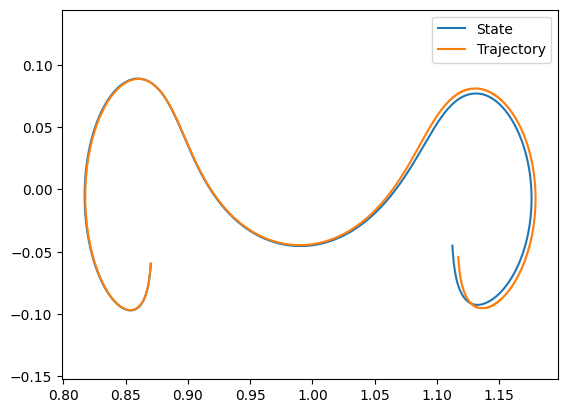

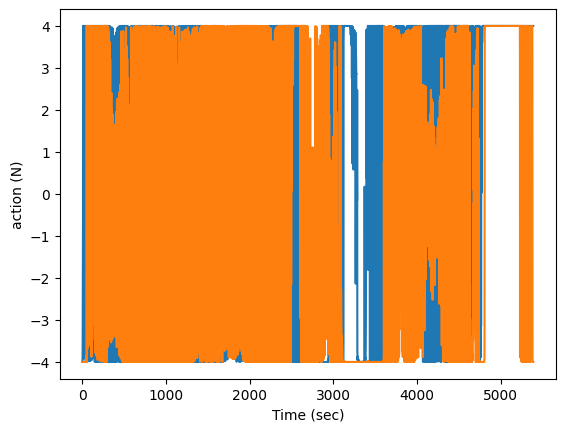

[-0.00471492  0.0091561  -0.00102148  0.02100713]
idx 0.09998 state 0.023418101282089994
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00164826  0.00990588  0.00204482  0.01173938]
idx 0.09998 state 0.015583248282815433
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00186107  0.00987994  0.00256342  0.01312163]
idx 0.09998 state 0.016727975547408205
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 37 completed in 2320.27 sec
---------------------------------------
|             Epoch |              37 |
|      AverageEpRet |            -640 |
|          StdEpRet |        1.01e+03 |
|          MaxEpRet |             419 |
|          MinEpRet |       -2.11e+03 |
|             EpLen |        5.01e+03 |
| TotalEnvInteracts |        1.11e+06 |
|      AverageQVals |           -11.5 |
|          StdQVals |            62.5 |
|          Max

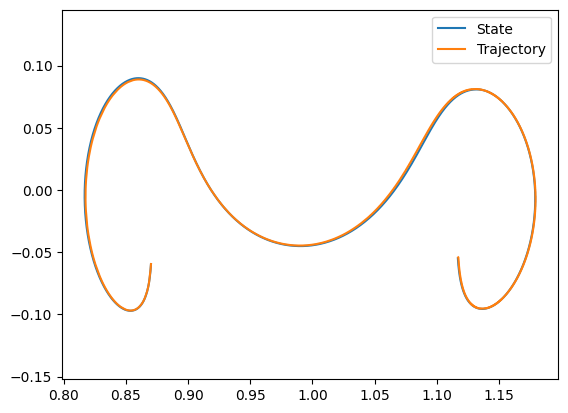

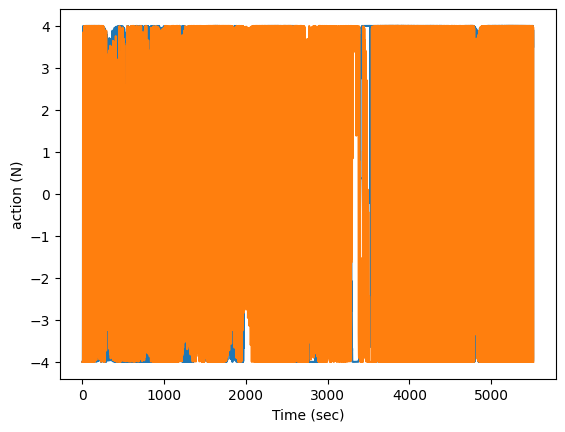

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
[ 0.00721076 -0.00693707  0.01386892 -0.00431693]
idx 0.05622 state 0.01763804653024174
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00158179  0.00993638  0.00267029  0.01128873]
idx 0.09998 state 0.015355766728811582
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
Epoch 38 completed in 2383.39 sec
---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |            -940 |
|          StdEpRet |             838 |
|          MaxEpRet |             529 |
|          MinEpRet |       -2.04e+03 |
|             EpLen |        4.59e+03 |
| TotalEnvInteracts |        1.14e+06 |
|      AverageQVals |           -6.98 |
|          StdQVals |              51 |
|          MaxQVals |             174 |
|          MinQVals |            -788 |
|            LossPi |             6

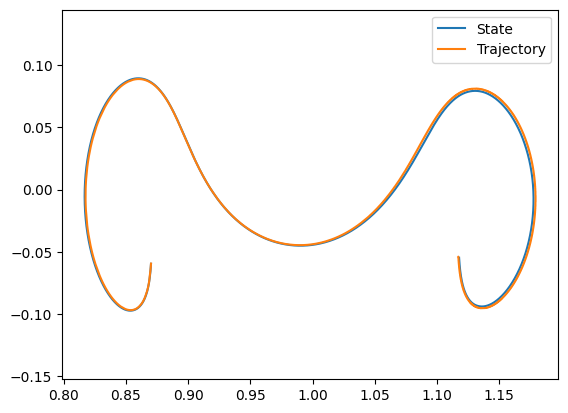

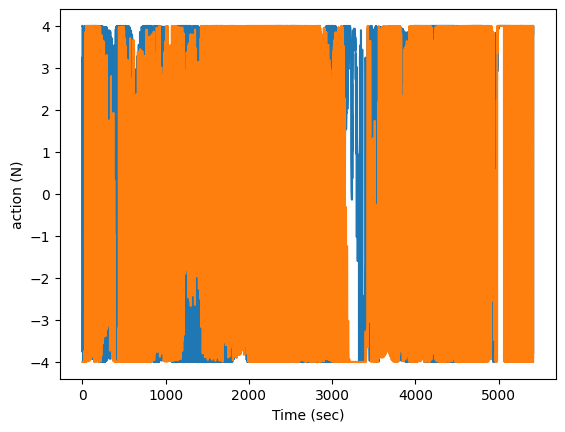

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00222815  0.00983017  0.0035343   0.01592736]
idx 0.09998 state 0.01917730795529192
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 39 completed in 2446.43 sec
---------------------------------------
|             Epoch |              39 |
|      AverageEpRet |            -796 |
|          StdEpRet |             680 |
|          MaxEpRet |            -177 |
|          MinEpRet |       -2.13e+03 |
|             EpLen |        5.38e+03 |
| TotalEnvInteracts |        1.17e+06 |
|      AverageQVals |           -4.31 |
|          StdQVals |            44.8 |
|          MaxQVals |             148 |
|          MinQVals |            -642 |
|            LossPi |            4.15 |
|             LossQ |             146 |
|              Time |        2.45e+03 |
---------------

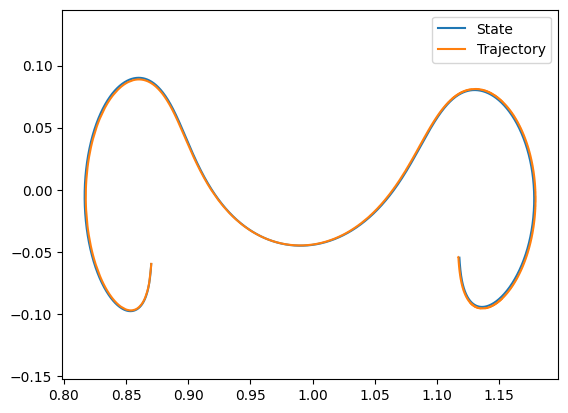

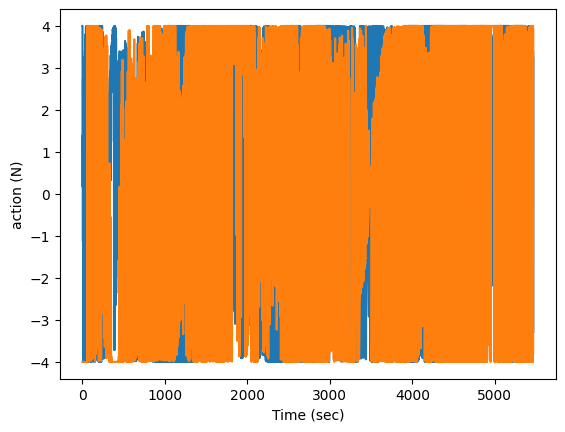

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.0032355   0.00955055  0.0011264   0.01564782]
idx 0.09998 state 0.018649516667974538
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00211866  0.00992047  0.00239763  0.01450497]
idx 0.09998 state 0.017861895852275513
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00175185  0.00990812  0.00212591  0.01216084]
idx 0.09998 state 0.015926250512682694
too much error 🥲😱
updating  🥰☺️
Epoch 40 completed in 2509.11 sec
---------------------------------------
|             Epoch |              40 |
|      AverageEpRet |       -1.26e+03 |
|          StdEpRet |        1.09e+03 |
|          MaxEpRet |             308 |
|          MinEpRet |       -2.72e+03 |
|             EpLen |        5.05e+03 |
| TotalEnvInteracts |         1.2e+06 |
|      AverageQVals |           -3.13 |
|          StdQVals |              42 |
|          Max

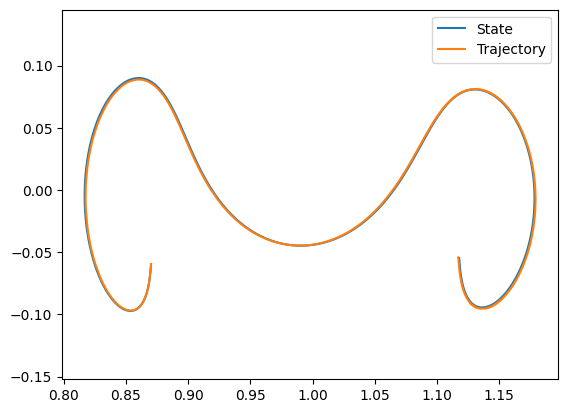

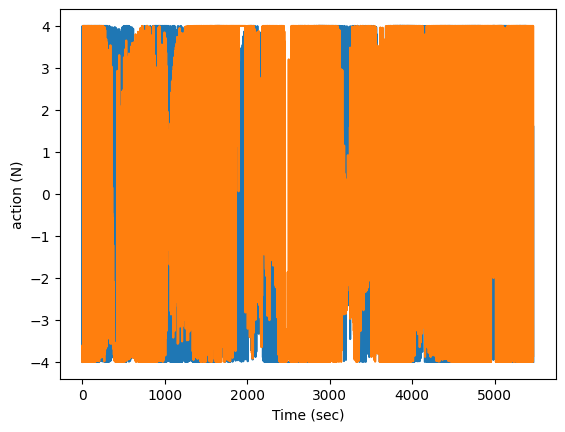

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[ 0.00836697 -0.00549776  0.02711997 -0.00740479]
idx 0.05356 state 0.029842169647865995
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
Epoch 41 completed in 2572.41 sec
---------------------------------------
|             Epoch |              41 |
|      AverageEpRet |            -544 |
|          StdEpRet |             767 |
|          MaxEpRet |             465 |
|          MinEpRet |       -1.95e+03 |
|             EpLen |        4.54e+03 |
| TotalEnvInteracts |        1.23e+06 |
|      AverageQVals |           -2.27 |
|          StdQVals |            38.5 |
|          MaxQVals |             144 |
|          MinQVals |            -616 |
|            LossPi |            2.11 |
|             LossQ |             147 |
|              Time |        2.57e+03 |
--------------

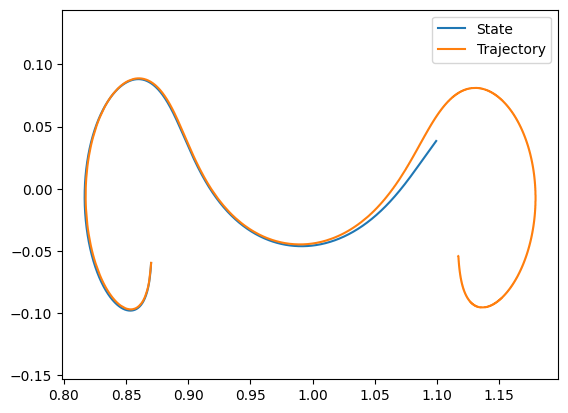

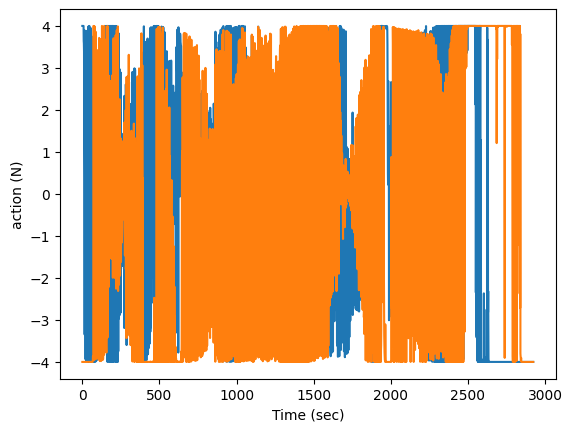

[ 0.00873962 -0.00498608  0.03076833 -0.00938226]
idx 0.05272 state 0.03370398660549162
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
[ 0.00760658 -0.00649352  0.02037736 -0.00212592]
idx 0.05547 state 0.022798734000120013
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
[ 0.00635579 -0.00774054  0.00500351 -0.06049372]
idx 0.04805 state 0.061521031686975806
too much error 🥲😱
updating  🥰☺️
Epoch 42 completed in 2633.62 sec
---------------------------------------
|             Epoch |              42 |
|      AverageEpRet |       -1.03e+03 |
|          StdEpRet |        1.07e+03 |
|          MaxEpRet |             227 |
|          MinEpRet |       -2.79e+03 |
|             EpLen |        4.71e+03 |
| TotalEnvInteracts |        1.26e+06 |
|      AverageQVals |          -0.848 |
|          StdQVals |            35.3 |
|       

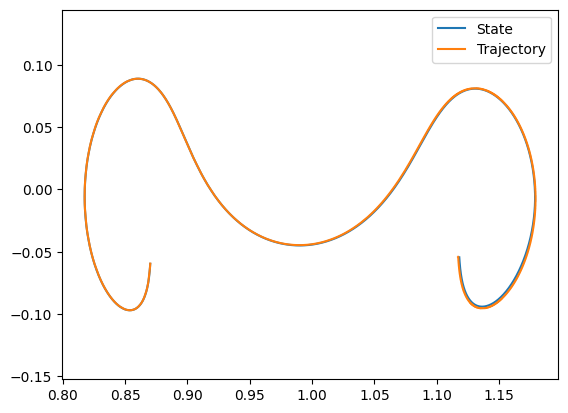

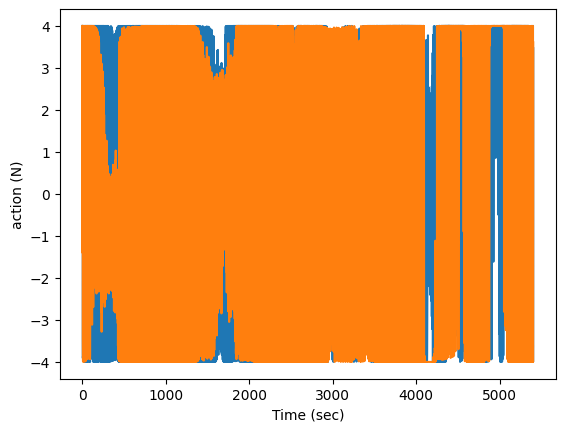

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00200982  0.00986845  0.00202761  0.01207934]
idx 0.09998 state 0.015857091953664033
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00223973  0.00978281  0.00156141  0.01281393]
idx 0.09998 state 0.016350982636591585
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00298001  0.00965781  0.00147375  0.01325824]
idx 0.09998 state 0.016736389444281657
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00318944  0.00954167  0.00148697  0.0133275 ]
idx 0.09998 state 0.016764530360070036
too much error 🥲😱
updating  🥰☺️
[ 0.00894157 -0.0045765   0.03155659 -0.01731045]
idx 0.05106 state 0.03736798691333673
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
Epoch 43 completed in 2696.48 sec
---------------------------------------
|             Epoch |              43 |
|      AverageEpRet |       -1.16e+03 |
|          StdEpRet |             899 |
|          MaxEpRet |             845 |
|          MinE

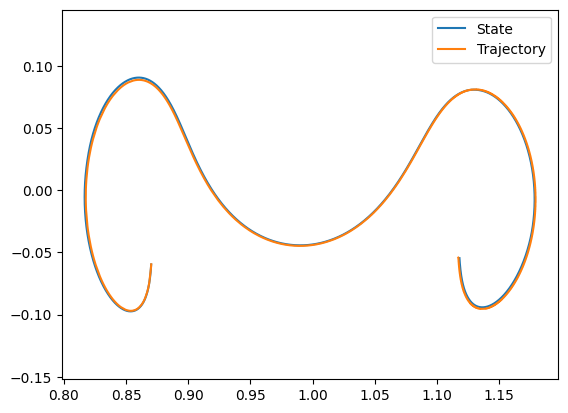

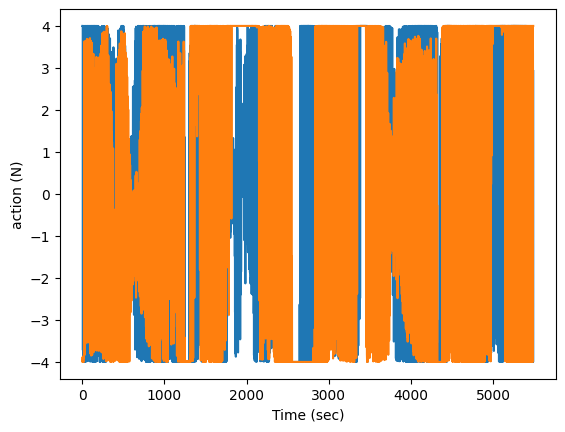

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.0022625   0.00989886  0.001899    0.01333412]
idx 0.09998 state 0.01686746606854848
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00182772  0.00986455  0.00161929  0.01394497]
idx 0.09998 state 0.017254974416936998
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00188041  0.00993663  0.00192533  0.01260784]
idx 0.09998 state 0.01627688965289118
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00161523  0.00999029  0.00243594  0.01389756]
idx 0.09998 state 0.01736349273503168
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
Epoch 44 completed in 2759.58 sec
---------------------------------------
|             Epoch |              44 |
|      AverageEpRet |            -867 |
|          StdEpRet |             606 |
|          MaxEpRet |             5.8 |
|          MinEpRet |       -1.53e+03 |
|             EpLen |        5.41e+03 |
| TotalEnvInteracts |        1.32e+06

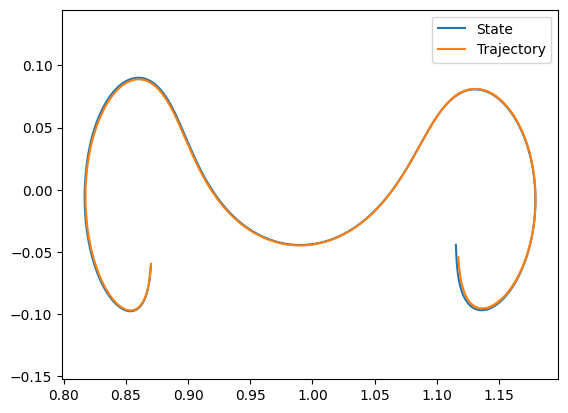

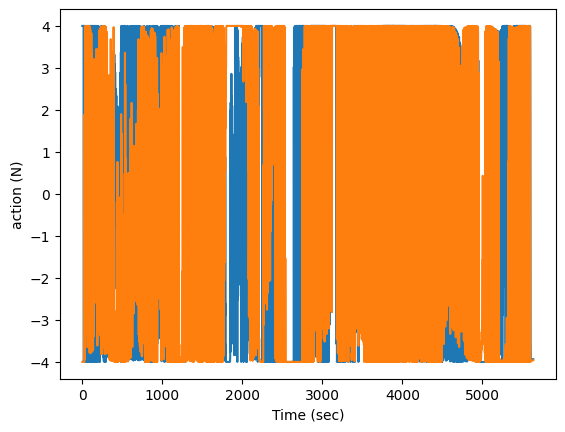

[-0.0019546   0.01009951  0.00217477  0.01247078]
idx 0.09998 state 0.016311671631960012
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00831072  0.00571422 -0.01005749  0.01868292]
idx 0.09998 state 0.023493088247687265
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00526351 -0.00850667 -0.01020865 -0.05622122]
idx 0.04773 state 0.058009571892838
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
Epoch 45 completed in 2822.54 sec
---------------------------------------
|             Epoch |              45 |
|      AverageEpRet |       -1.19e+03 |
|          StdEpRet |        1.68e+03 |
|          MaxEpRet |             280 |
|          MinEpRet |       -4.09e+03 |
|             EpLen |        4.43e+03 |
| TotalEnvInteracts |        1.35e+06 |
|      AverageQVals |           0.914 |
|          StdQVals |              35 |
|          MaxQVa

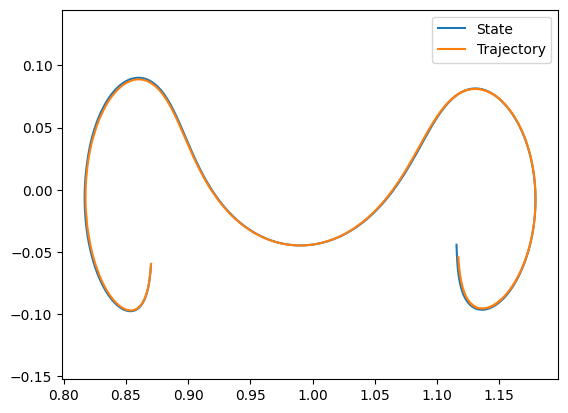

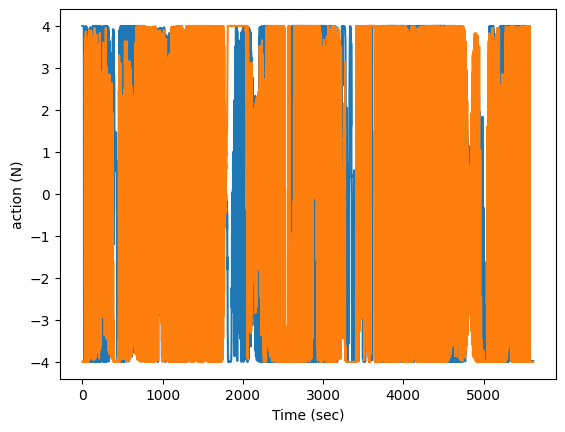

[-0.00145402  0.0101839   0.00271707  0.01268565]
idx 0.09998 state 0.016556994279626584
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00151858  0.01002917  0.00157335  0.01245164]
idx 0.09998 state 0.01613719645325234
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[0.0007952  0.01006477 0.00479247 0.01352659]
idx 0.09998 state 0.01754617909886586
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[0.00068433 0.01005596 0.00461615 0.01330512]
idx 0.09998 state 0.017318366014015138
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00167883  0.00995183  0.00260574  0.01218051]
idx 0.09998 state 0.016031598676459605
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 46 completed in 2885.63 sec
---------------------------------------
|             Epoch |              46 |
|      AverageEpRet |       -1.37e+03 |
|          StdEpRet |             925 |
|          MaxEpRet |           -87.7 |
|          MinEpRet |   

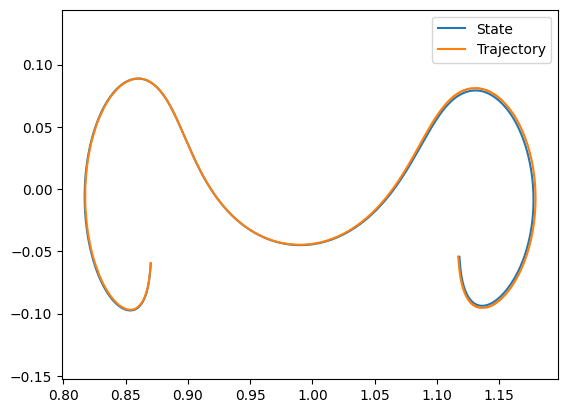

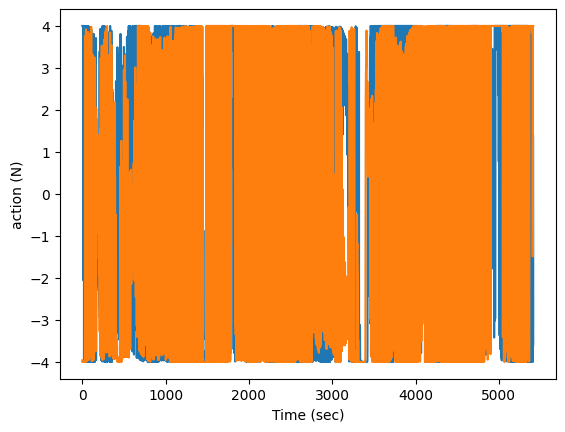

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 47 completed in 2948.21 sec
---------------------------------------
|             Epoch |              47 |
|      AverageEpRet |             314 |
|          StdEpRet |             260 |
|          MaxEpRet |             746 |
|          MinEpRet |           -84.3 |
|             EpLen |        4.97e+03 |
| TotalEnvInteracts |        1.41e+06 |
|      AverageQVals |            1.41 |
|          StdQVals |            35.9 |
|          MaxQVals |             113 |
|          MinQVals |            -572 |
|            LossPi |           -1.57 |
|             LossQ |             149 |
|              Time |        2.95e+03 |
---------------------------------------
done 🥺
(9999, 6)


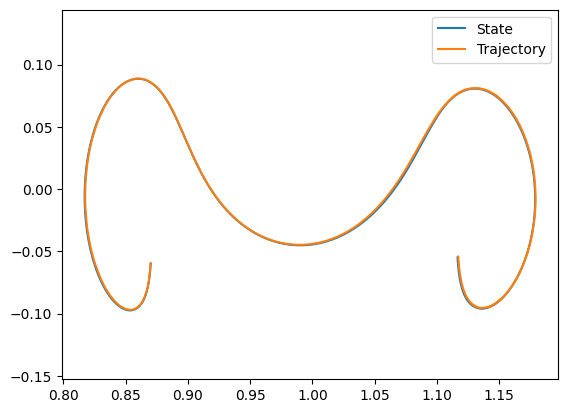

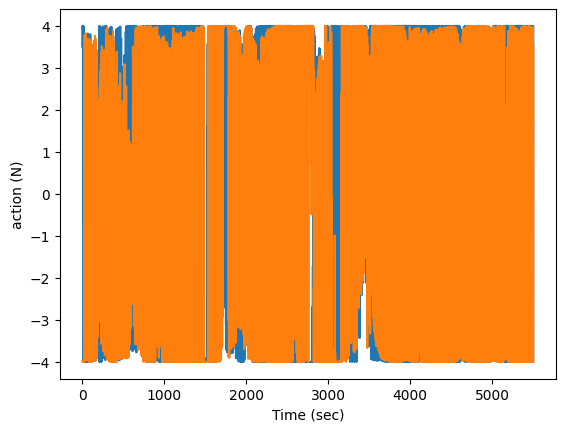

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 48 completed in 3012.19 sec
---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             570 |
|          StdEpRet |             109 |
|          MaxEpRet |             686 |
|          MinEpRet |             421 |
|             EpLen |        5.01e+03 |
| TotalEnvInteracts |        1.44e+06 |
|      AverageQVals |            1.52 |
|          StdQVals |            36.3 |
|          MaxQVals |             121 |
|          MinQVals |            -566 |
|            LossPi |           -1.68 |
|             LossQ |             142 |
|              Time |        3.01e+03 |
---------------------------------------
done 🥺
(9999, 6)


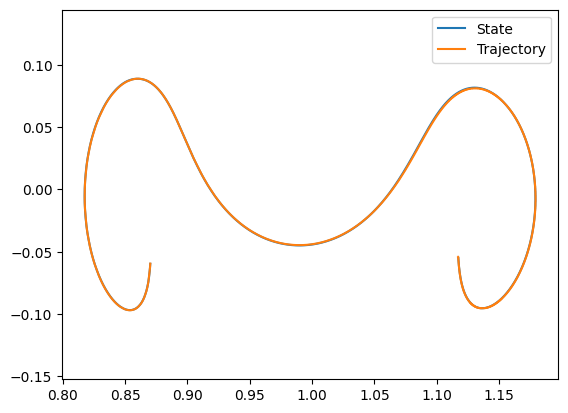

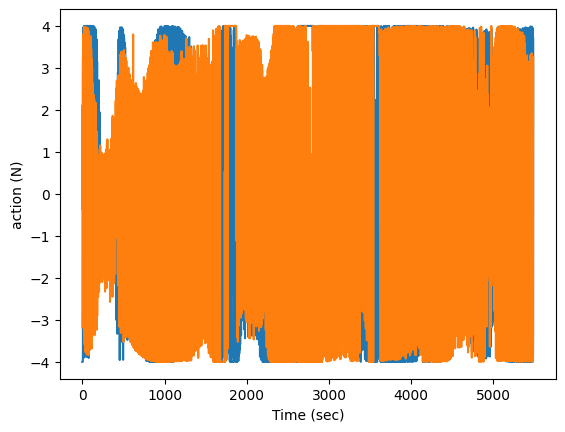

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 49 completed in 3074.79 sec
---------------------------------------
|             Epoch |              49 |
|      AverageEpRet |             603 |
|          StdEpRet |             126 |
|          MaxEpRet |             783 |
|          MinEpRet |             461 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |        1.47e+06 |
|      AverageQVals |            1.67 |
|          StdQVals |            36.3 |
|          MaxQVals |             131 |
|          MinQVals |            -559 |
|            LossPi |           -1.84 |
|             LossQ |             147 |
|              Time |        3.07e+03 |
---------------------------------------
done 🥺
(9999, 6)


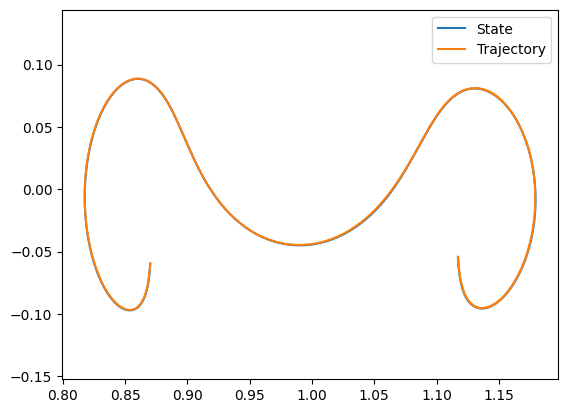

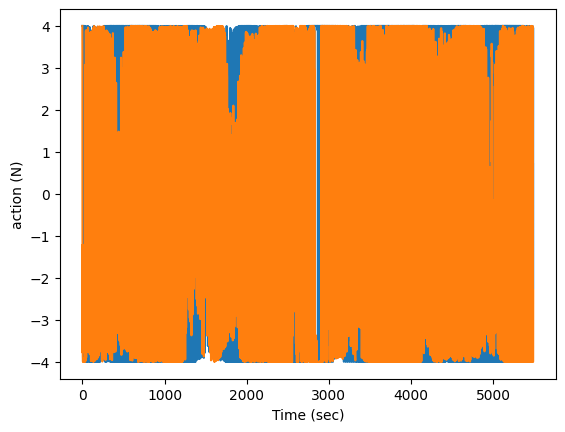

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 50 completed in 3137.60 sec
---------------------------------------
|             Epoch |              50 |
|      AverageEpRet |             477 |
|          StdEpRet |             150 |
|          MaxEpRet |             733 |
|          MinEpRet |             264 |
|             EpLen |        5.01e+03 |
| TotalEnvInteracts |         1.5e+06 |
|      AverageQVals |            2.89 |
|          StdQVals |            36.1 |
|          MaxQVals |             186 |
|          MinQVals |            -549 |
|            LossPi |           -3.08 |
|             LossQ |             149 |
|              Time |        3.14e+03 |
---------------------------------------
done 🥺
(9999, 6)


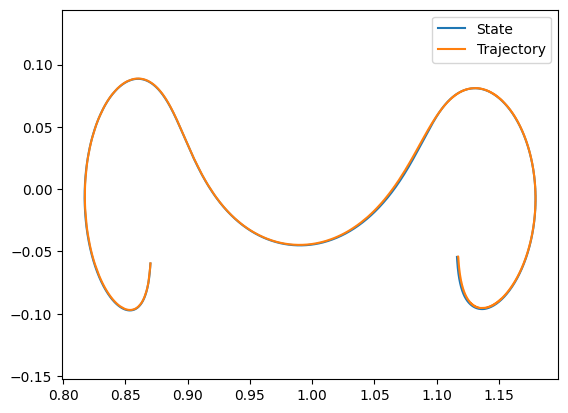

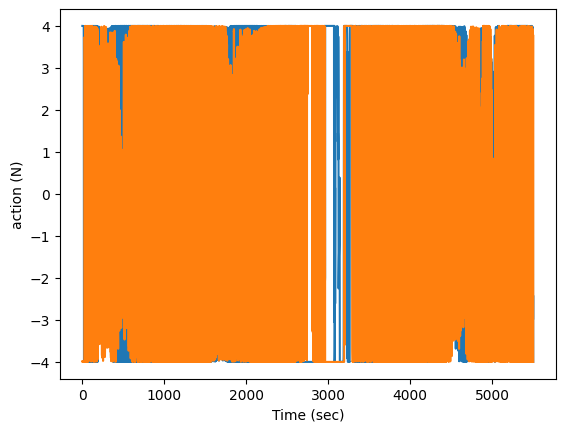

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 51 completed in 3200.43 sec
---------------------------------------
|             Epoch |              51 |
|      AverageEpRet |             227 |
|          StdEpRet |             315 |
|          MaxEpRet |             630 |
|          MinEpRet |            -371 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |        1.53e+06 |
|      AverageQVals |            4.68 |
|          StdQVals |            34.6 |
|          MaxQVals |            92.3 |
|          MinQVals |            -566 |
|            LossPi |           -4.86 |
|             LossQ |             145 |
|              Time |         3.2e+03 |
---------------------------------------
done 🥺
(9999, 6)


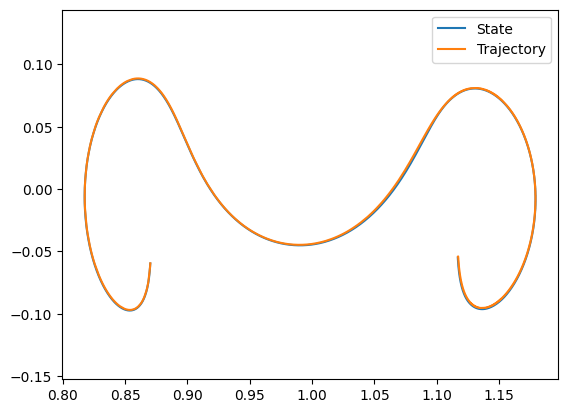

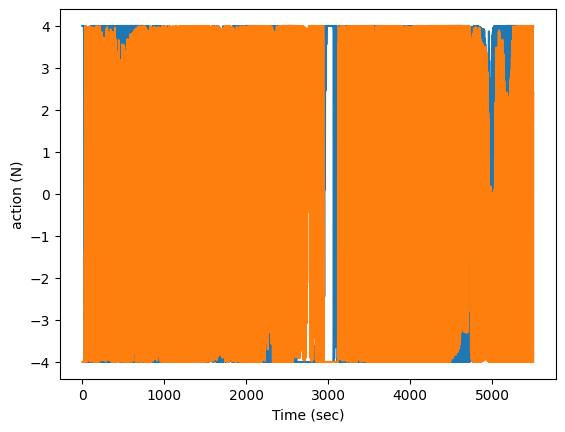

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 52 completed in 3263.29 sec
---------------------------------------
|             Epoch |              52 |
|      AverageEpRet |            77.6 |
|          StdEpRet |             284 |
|          MaxEpRet |             693 |
|          MinEpRet |            -116 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |        1.56e+06 |
|      AverageQVals |             5.6 |
|          StdQVals |            33.1 |
|          MaxQVals |            80.8 |
|          MinQVals |            -570 |
|            LossPi |           -5.79 |
|             LossQ |             145 |
|              Time |        3.26e+03 |
---------------------------------------
done 🥺
(9999, 6)


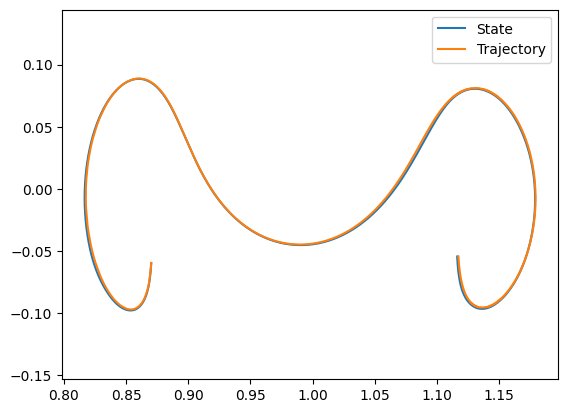

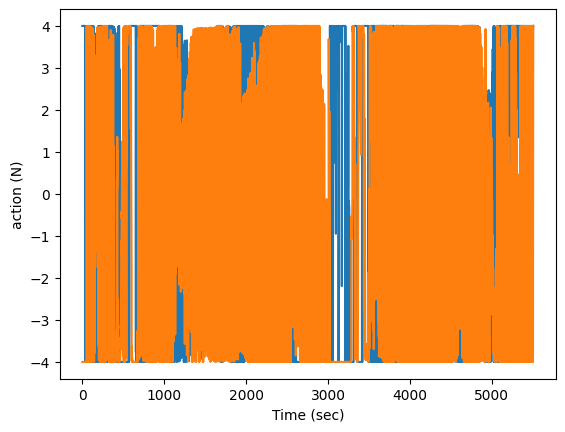

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 53 completed in 3326.06 sec
---------------------------------------
|             Epoch |              53 |
|      AverageEpRet |             130 |
|          StdEpRet |             208 |
|          MaxEpRet |             530 |
|          MinEpRet |            -125 |
|             EpLen |        4.98e+03 |
| TotalEnvInteracts |        1.59e+06 |
|      AverageQVals |            7.19 |
|          StdQVals |            30.7 |
|          MaxQVals |            78.6 |
|          MinQVals |            -594 |
|            LossPi |           -7.37 |
|             LossQ |             153 |
|              Time |        3.33e+03 |
---------------------------------------
done 🥺
(9999, 6)


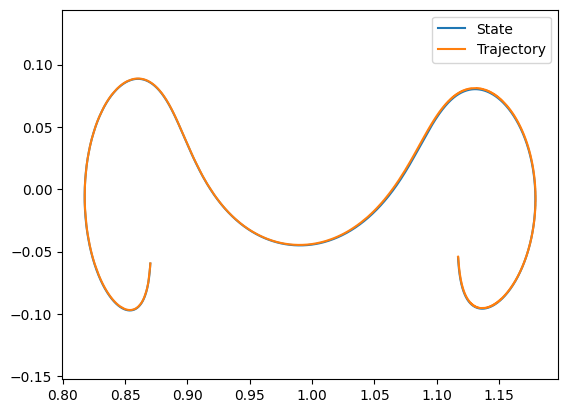

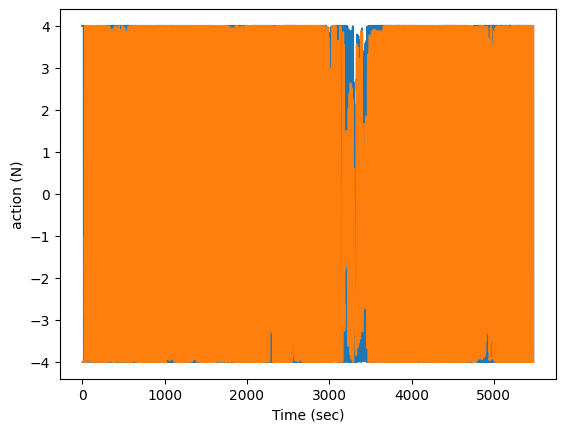

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 54 completed in 3388.54 sec
---------------------------------------
|             Epoch |              54 |
|      AverageEpRet |           -96.5 |
|          StdEpRet |             553 |
|          MaxEpRet |             752 |
|          MinEpRet |       -1.13e+03 |
|             EpLen |        4.95e+03 |
| TotalEnvInteracts |        1.62e+06 |
|      AverageQVals |            8.35 |
|          StdQVals |            30.1 |
|          MaxQVals |            79.3 |
|          MinQVals |            -591 |
|            LossPi |           -8.54 |
|             LossQ |             152 |
|              Time |        3.39e+03 |
---------------------------------------
done 🥺
(9999, 6)


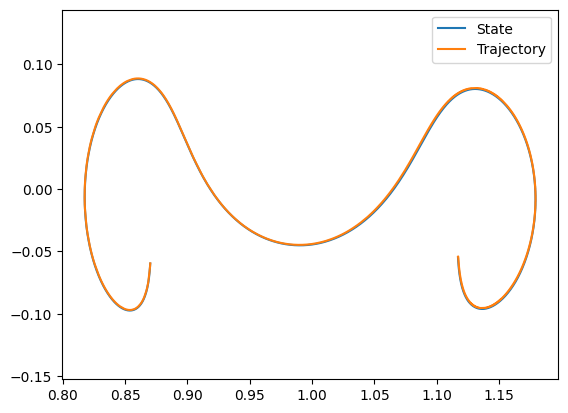

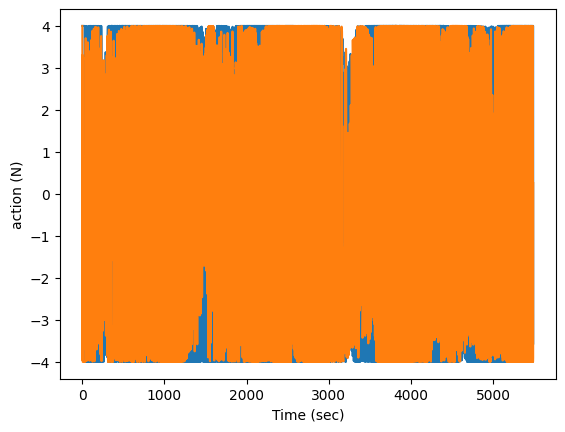

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 55 completed in 3450.96 sec
---------------------------------------
|             Epoch |              55 |
|      AverageEpRet |             245 |
|          StdEpRet |             213 |
|          MaxEpRet |             624 |
|          MinEpRet |           -41.9 |
|             EpLen |        5.05e+03 |
| TotalEnvInteracts |        1.65e+06 |
|      AverageQVals |             8.5 |
|          StdQVals |            29.9 |
|          MaxQVals |            78.9 |
|          MinQVals |            -568 |
|            LossPi |           -8.68 |
|             LossQ |             152 |
|              Time |        3.45e+03 |
---------------------------------------
done 🥺
(9999, 6)


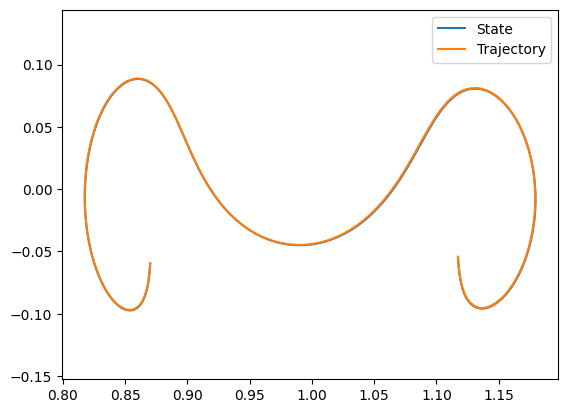

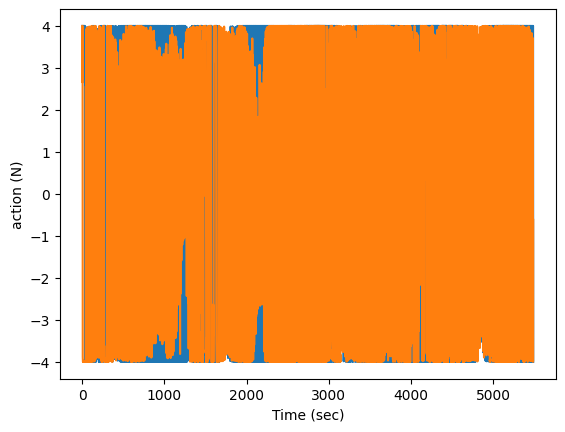

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 56 completed in 3513.57 sec
---------------------------------------
|             Epoch |              56 |
|      AverageEpRet |             330 |
|          StdEpRet |             196 |
|          MaxEpRet |             693 |
|          MinEpRet |             153 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |        1.68e+06 |
|      AverageQVals |            8.53 |
|          StdQVals |            29.8 |
|          MaxQVals |            82.1 |
|          MinQVals |            -582 |
|            LossPi |           -8.71 |
|             LossQ |             142 |
|              Time |        3.51e+03 |
---------------------------------------
done 🥺
(9999, 6)


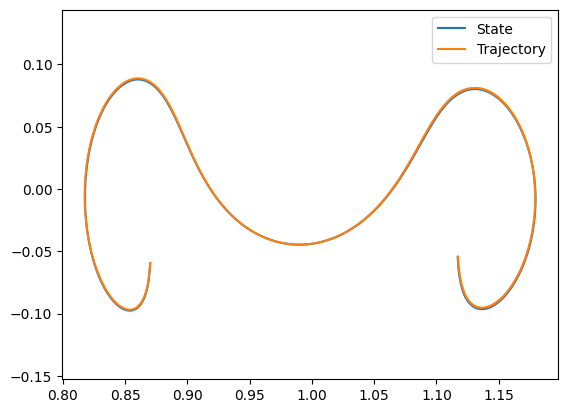

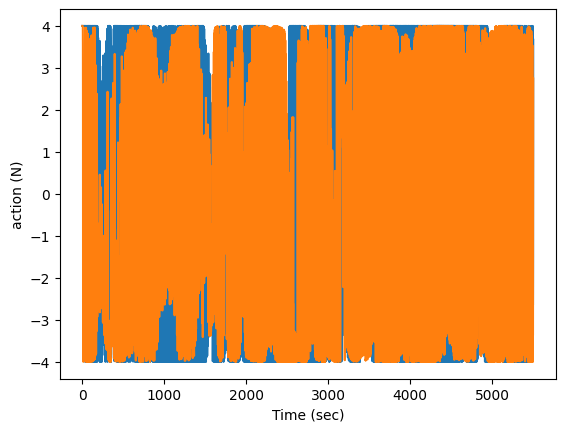

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
[ 0.00879119 -0.00483193  0.03114874 -0.00876926]
idx 0.05282 state 0.03387884682017029
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00138064  0.00996396  0.00720571  0.01669455]
idx 0.09998 state 0.020780206624427828
too much error 🥲😱
updating  🥰☺️
[ 0.00886907 -0.00463697  0.03218307 -0.0113488 ]
idx 0.05194 state 0.0355627227680261
too much error 🥲😱
updating  🥰☺️
Epoch 57 completed in 3576.49 sec
---------------------------------------
|             Epoch |              57 |
|      AverageEpRet |            -505 |
|          StdEpRet |             927 |
|          MaxEpRet |             595 |
|          MinEpRet |       -1.83e+03 |
|             EpLen |        4.32e+03 |
| TotalEnvInteracts |        1.71e+06 |
|      AverageQVals |            8.05 |
|          StdQVals |            29.9 |
|         

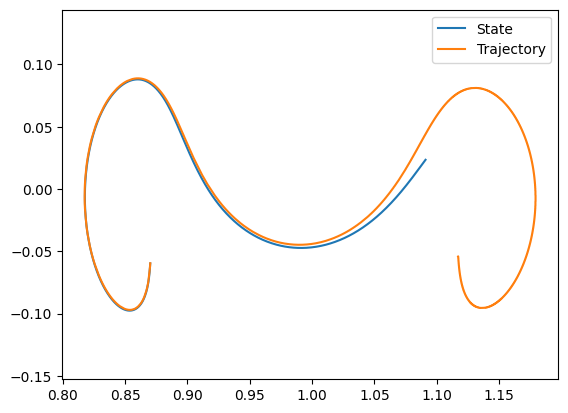

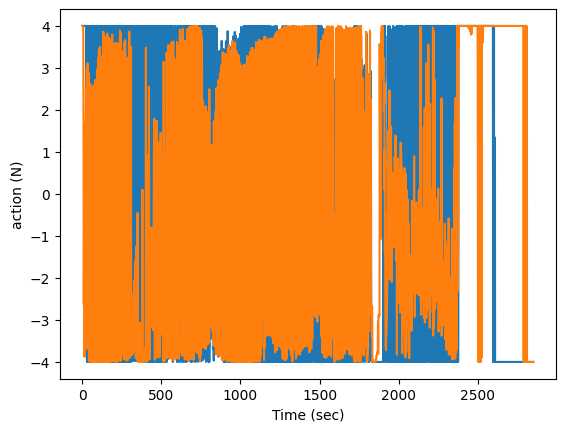

[ 0.00889786 -0.004676    0.03097532 -0.0156182 ]
idx 0.05144 state 0.03611696861272441
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
[ 0.00853122 -0.00524171  0.03021054 -0.00665852]
idx 0.05309 state 0.03251568885193268
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00792371 -0.00611681  0.02125243 -0.00332564]
idx 0.05509 state 0.02372606603961374
too much error 🥲😱
updating  🥰☺️
[ 0.00864154 -0.00507547  0.03132032 -0.01099414]
idx 0.05235 state 0.034673767265323736
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
[ 0.00879387 -0.00481272  0.03293689 -0.01243901]
idx 0.05194 state 0.03660685526471526
too much error 🥲😱
updating  🥰☺️
Epoch 58 completed in 3637.96 sec
---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |       -1.05e+03 |
|          StdEpRet |             773 |
|          MaxEpRet |            71.8 |
|   

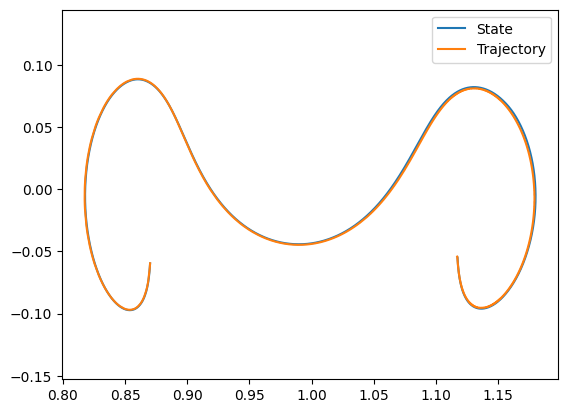

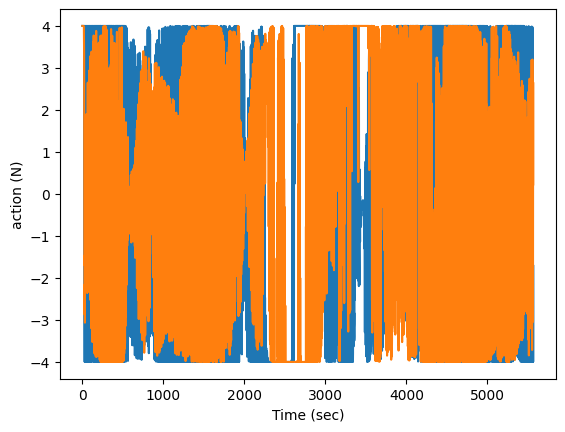

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00232403  0.00986389  0.00439883  0.01807835]
idx 0.09998 state 0.021186642782203478
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00189217  0.00987735  0.00391177  0.01763717]
idx 0.09998 state 0.020676417120992965
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00223478  0.00976185  0.00470582  0.01676464]
idx 0.09998 state 0.0200869546130088
too much error 🥲😱
updating  🥰☺️
Epoch 59 completed in 3701.32 sec
---------------------------------------
|             Epoch |              59 |
|      AverageEpRet |            -696 |
|          StdEpRet |             896 |
|          MaxEpRet |             647 |
|          MinEpRet |       -1.78e+03 |
|             EpLen |        4.96e+03 |
| TotalEnvInteracts |        1.77e+06 |
|      AverageQVals |            7.89 |
|          StdQVals |            33.2 |
|          MaxQV

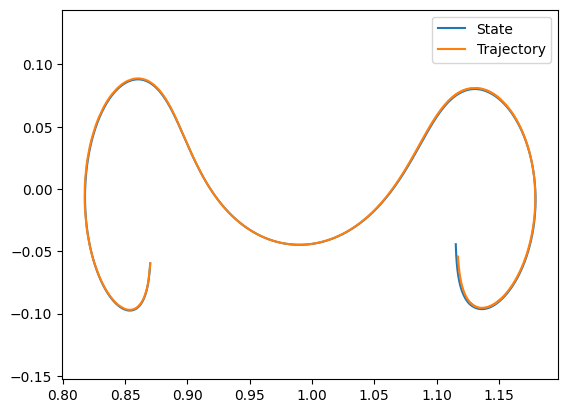

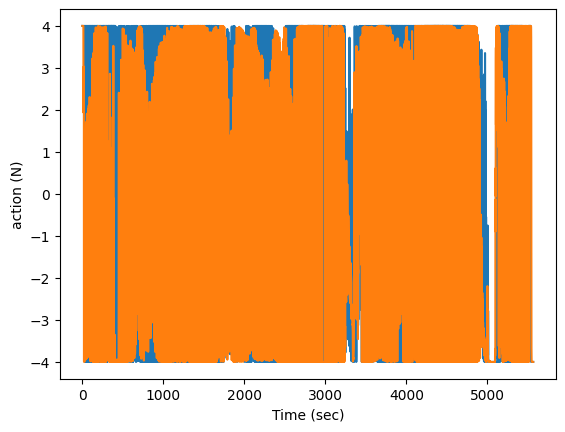

[-0.00173822  0.01002352  0.00301472  0.01592024]
idx 0.09998 state 0.019132043241155854
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00838886 -0.00546845 -0.02965702 -0.00813133]
idx 0.06693 state 0.032340902535409305
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00251175  0.00969076  0.00535978  0.01763246]
idx 0.09998 state 0.020972618685195787
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
Epoch 60 completed in 3764.14 sec
---------------------------------------
|             Epoch |              60 |
|      AverageEpRet |       -1.17e+03 |
|          StdEpRet |        1.29e+03 |
|          MaxEpRet |            -229 |
|          MinEpRet |       -3.81e+03 |
|             EpLen |        4.69e+03 |
| TotalEnvInteracts |         1.8e+06 |
|      AverageQVals |            7.35 |
|          StdQVals |            33.8 |
|          Max

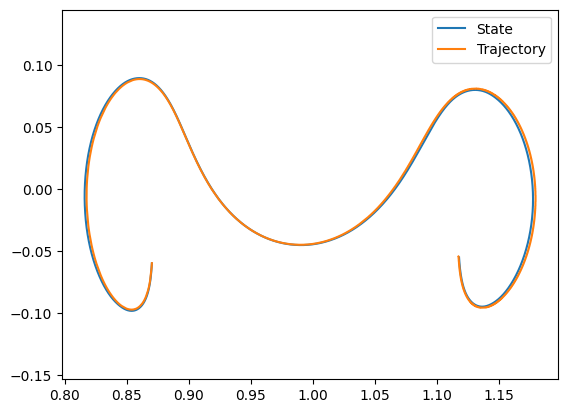

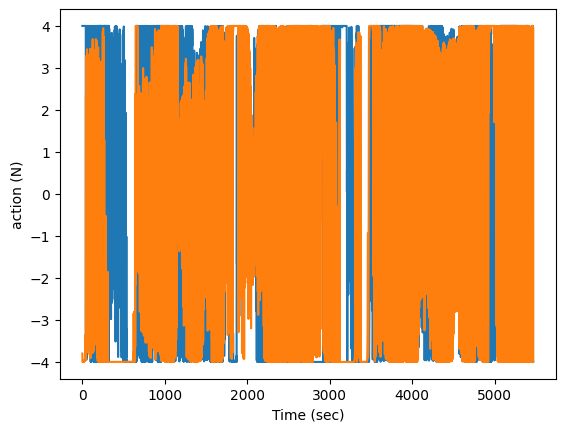

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00198039  0.00993143  0.00479039  0.01586276]
idx 0.09998 state 0.019419839490442712
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
[-0.00622134 -0.00787902 -0.03797139 -0.03019108]
idx 0.06392 state 0.049538994797850615
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00502139 -0.00865962 -0.04107705 -0.04323912]
idx 0.06293 state 0.06047436564295061
too much error 🥲😱
Epoch 61 completed in 3827.10 sec
---------------------------------------
|             Epoch |              61 |
|      AverageEpRet |       -1.58e+03 |
|          StdEpRet |        1.71e+03 |
|          MaxEpRet |           -39.2 |
|          MinEpRet |       -4.37e+03 |
|             EpLen |         4.8e+03 |
| TotalEnvInteracts |        1.83e+06 |
|      AverageQVals |            6.84 |
|          StdQVals |            33.6 |
|       

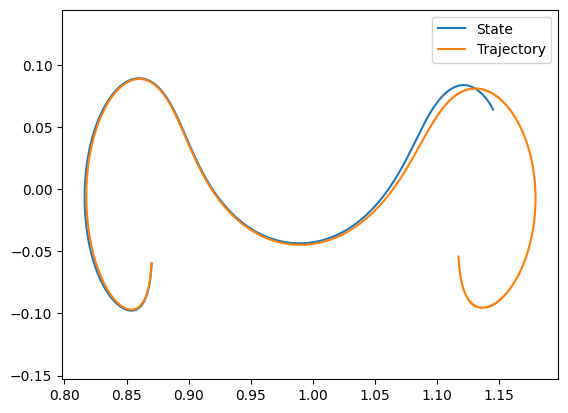

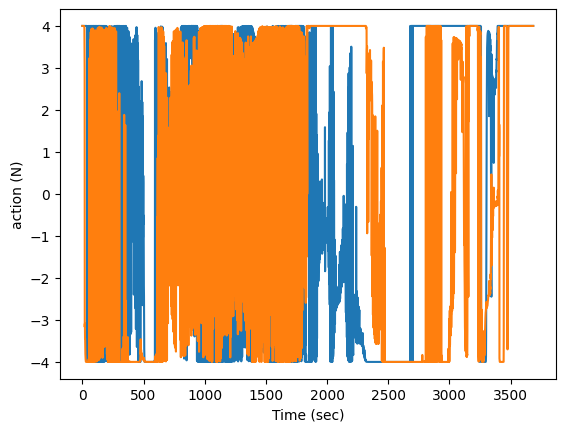

[-0.00660703 -0.00758416 -0.03340243 -0.02451901]
idx 0.06445 state 0.04263890765012492
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00759707 -0.00652435 -0.03421326 -0.01466058]
idx 0.06535 state 0.03854558767430965
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00450501 -0.00895244 -0.04772706 -0.04397412]
idx 0.06259 state 0.06566609954613868
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00517767 -0.00858272 -0.04573053 -0.03665266]
idx 0.06307 state 0.059457299786337854
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00839685  0.00544755 -0.01617344  0.00159485]
idx 0.05456 state 0.01908681595057533
too much error 🥲😱
updating  🥰☺️
[-0.00234116 -0.00975763 -0.05583306 -0.05956132]
idx 0.06147 state 0.082253107676139
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00851864 -0.00528126  0.03077415 -0.03303451]
idx 0.04974 state 0.04624701123364437
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
Epoch 62 completed in 3888.73 sec
--------

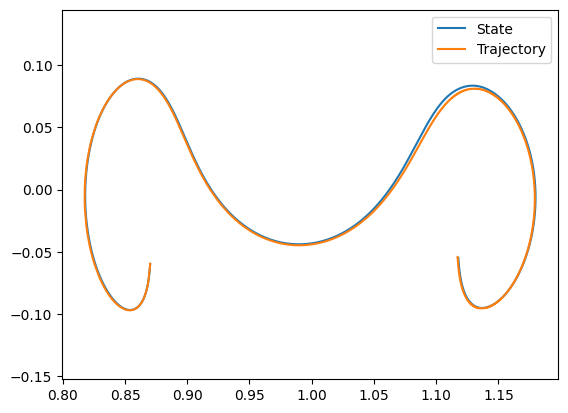

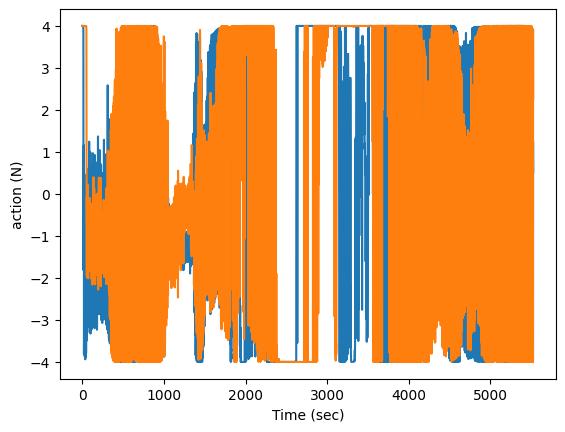

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[ 0.00853609 -0.00526689  0.02660652 -0.03536863]
idx 0.04966 state 0.04538118490860852
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.0020886   0.0097884   0.00115553  0.01304365]
idx 0.09998 state 0.016481725807686122
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
Epoch 63 completed in 3951.62 sec
---------------------------------------
|             Epoch |              63 |
|      AverageEpRet |            -738 |
|          StdEpRet |             744 |
|          MaxEpRet |            57.9 |
|          MinEpRet |       -2.03e+03 |
|             EpLen |        4.81e+03 |
| TotalEnvInteracts |        1.89e+06 |
|      AverageQVals |            6.86 |
|          StdQVals |            41.7 |
|          MaxQVals |             112 |
|          MinQVals |            -594 |
|            LossPi |           -7.

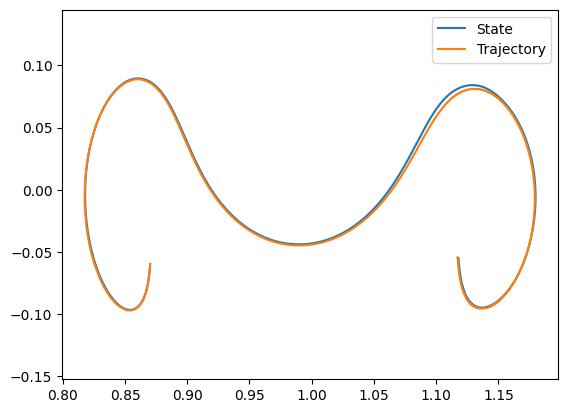

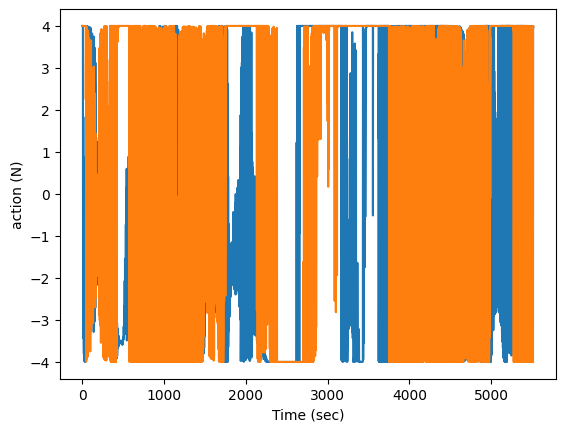

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 64 completed in 4014.45 sec
---------------------------------------
|             Epoch |              64 |
|      AverageEpRet |            -236 |
|          StdEpRet |             519 |
|          MaxEpRet |             221 |
|          MinEpRet |       -1.06e+03 |
|             EpLen |        5.46e+03 |
| TotalEnvInteracts |        1.92e+06 |
|      AverageQVals |            9.86 |
|          StdQVals |            44.1 |
|          MaxQVals |             100 |
|          MinQVals |            -609 |
|            LossPi |           -10.1 |
|             LossQ |             140 |
|              Time |        4.01e+03 |
---------------------------------------
done 🥺
(9999, 6)


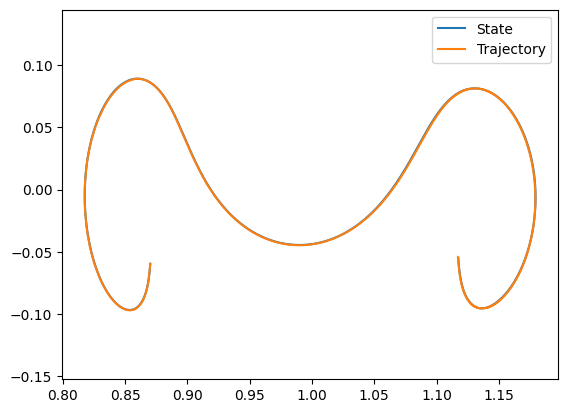

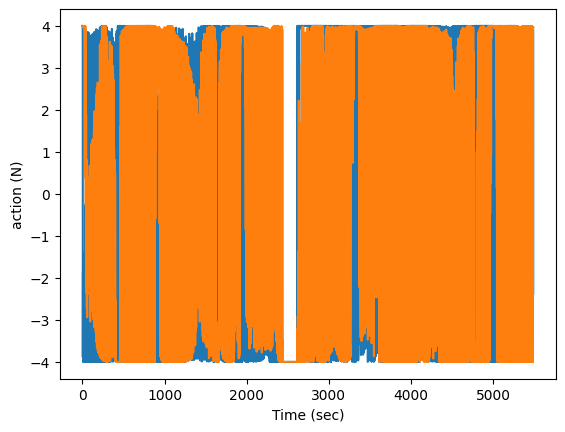

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 65 completed in 4076.88 sec
---------------------------------------
|             Epoch |              65 |
|      AverageEpRet |             191 |
|          StdEpRet |             178 |
|          MaxEpRet |             498 |
|          MinEpRet |           -45.5 |
|             EpLen |        4.97e+03 |
| TotalEnvInteracts |        1.95e+06 |
|      AverageQVals |            11.5 |
|          StdQVals |            44.4 |
|          MaxQVals |            88.1 |
|          MinQVals |            -607 |
|            LossPi |           -11.7 |
|             LossQ |             142 |
|              Time |        4.08e+03 |
---------------------------------------
done 🥺
(9999, 6)


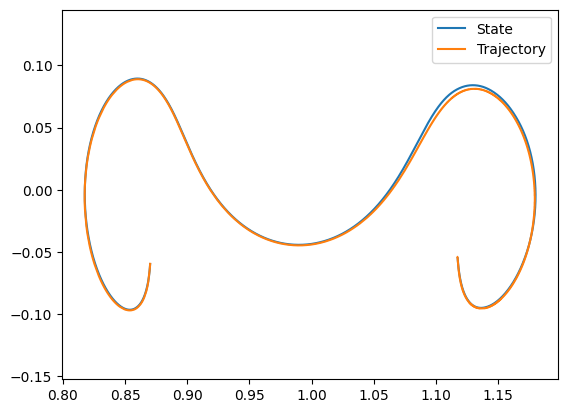

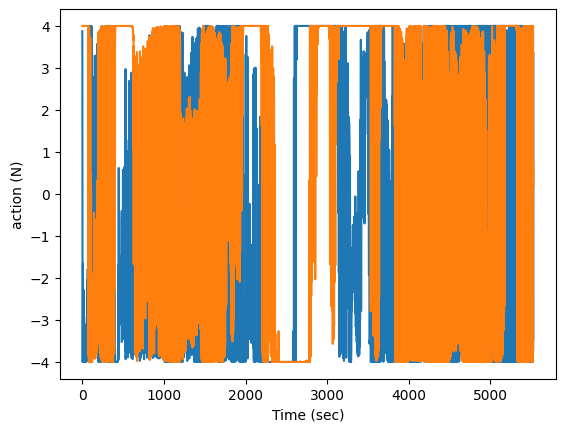

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 66 completed in 4139.73 sec
---------------------------------------
|             Epoch |              66 |
|      AverageEpRet |            6.91 |
|          StdEpRet |             183 |
|          MaxEpRet |             307 |
|          MinEpRet |            -225 |
|             EpLen |        5.01e+03 |
| TotalEnvInteracts |        1.98e+06 |
|      AverageQVals |            11.3 |
|          StdQVals |            44.3 |
|          MaxQVals |            88.9 |
|          MinQVals |            -608 |
|            LossPi |           -11.5 |
|             LossQ |             144 |
|              Time |        4.14e+03 |
---------------------------------------
done 🥺
(9999, 6)


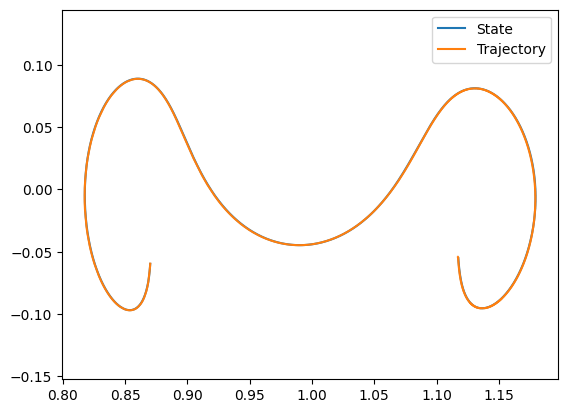

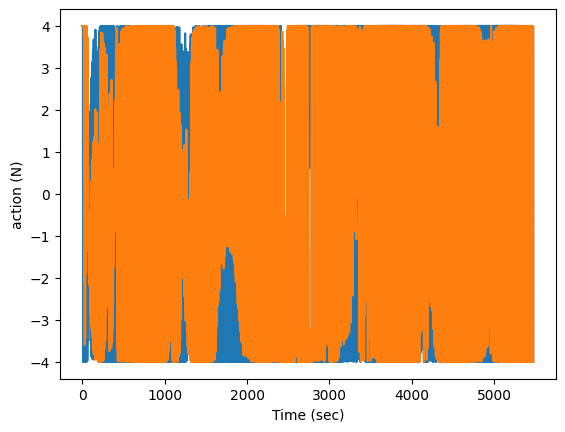

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 67 completed in 4202.41 sec
---------------------------------------
|             Epoch |              67 |
|      AverageEpRet |            12.1 |
|          StdEpRet |             369 |
|          MaxEpRet |             622 |
|          MinEpRet |            -536 |
|             EpLen |        5.01e+03 |
| TotalEnvInteracts |        2.01e+06 |
|      AverageQVals |            10.4 |
|          StdQVals |            44.2 |
|          MaxQVals |             107 |
|          MinQVals |            -611 |
|            LossPi |           -10.5 |
|             LossQ |             145 |
|              Time |         4.2e+03 |
---------------------------------------
done 🥺
(9999, 6)


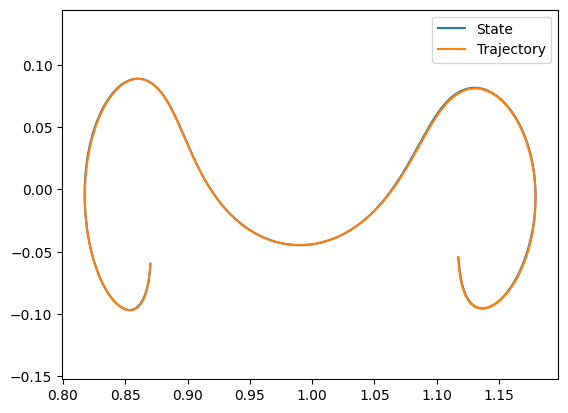

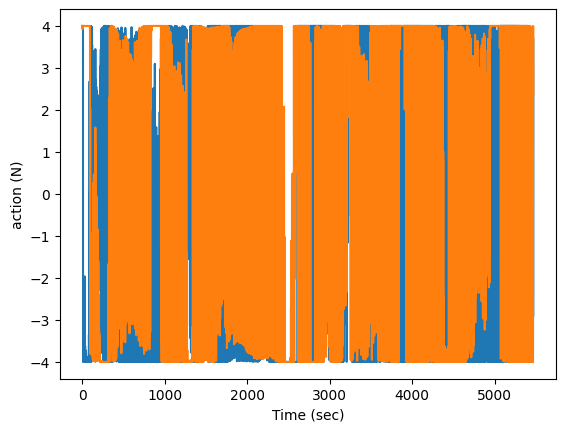

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 68 completed in 4266.11 sec
---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             112 |
|          StdEpRet |             163 |
|          MaxEpRet |             414 |
|          MinEpRet |            -103 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |        2.04e+06 |
|      AverageQVals |            9.34 |
|          StdQVals |            43.3 |
|          MaxQVals |             102 |
|          MinQVals |            -618 |
|            LossPi |           -9.51 |
|             LossQ |             138 |
|              Time |        4.27e+03 |
---------------------------------------
done 🥺
(9999, 6)


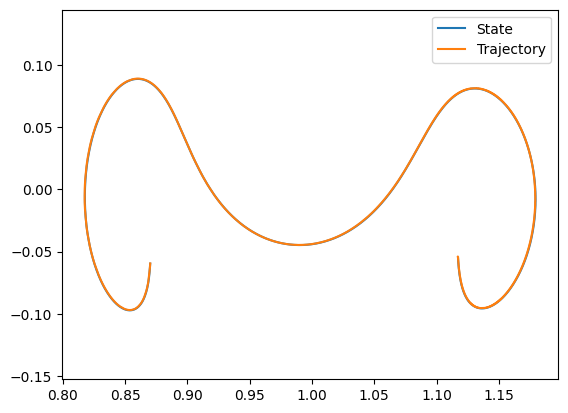

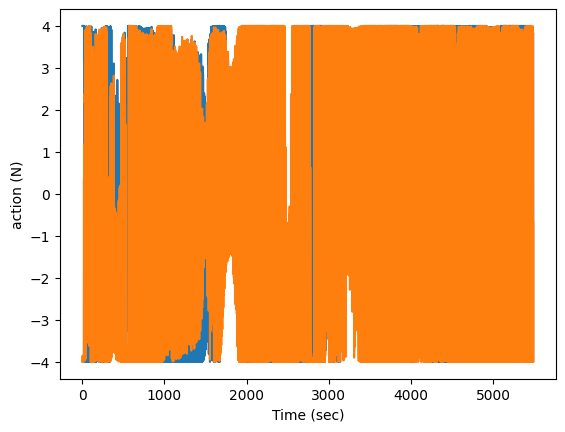

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 69 completed in 4328.91 sec
---------------------------------------
|             Epoch |              69 |
|      AverageEpRet |            41.8 |
|          StdEpRet |             292 |
|          MaxEpRet |             672 |
|          MinEpRet |            -218 |
|             EpLen |        4.99e+03 |
| TotalEnvInteracts |        2.07e+06 |
|      AverageQVals |            8.69 |
|          StdQVals |            42.9 |
|          MaxQVals |            96.1 |
|          MinQVals |            -623 |
|            LossPi |           -8.85 |
|             LossQ |             146 |
|              Time |        4.33e+03 |
---------------------------------------
done 🥺
(9999, 6)


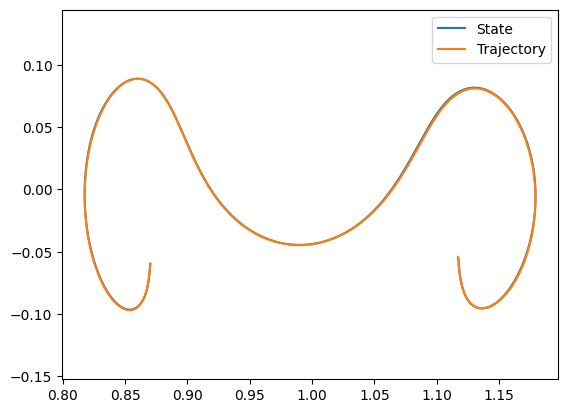

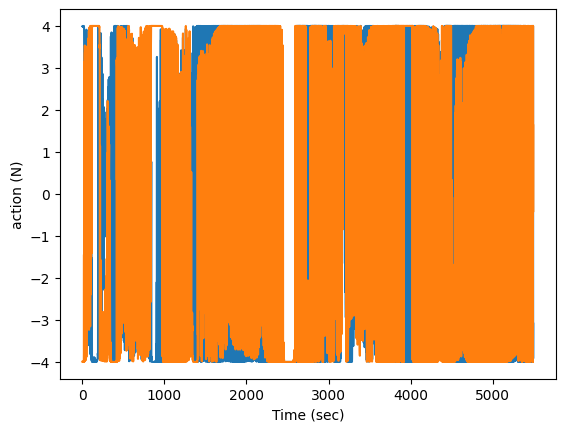

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 70 completed in 4391.63 sec
---------------------------------------
|             Epoch |              70 |
|      AverageEpRet |           -34.3 |
|          StdEpRet |             265 |
|          MaxEpRet |             473 |
|          MinEpRet |            -392 |
|             EpLen |        4.98e+03 |
| TotalEnvInteracts |         2.1e+06 |
|      AverageQVals |            8.36 |
|          StdQVals |            42.7 |
|          MaxQVals |             112 |
|          MinQVals |            -626 |
|            LossPi |           -8.52 |
|             LossQ |             149 |
|              Time |        4.39e+03 |
---------------------------------------
done 🥺
(9999, 6)


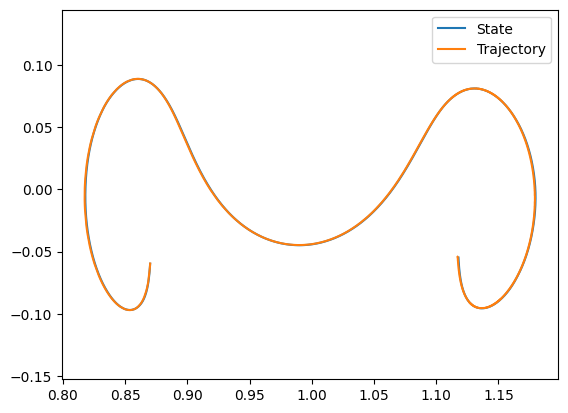

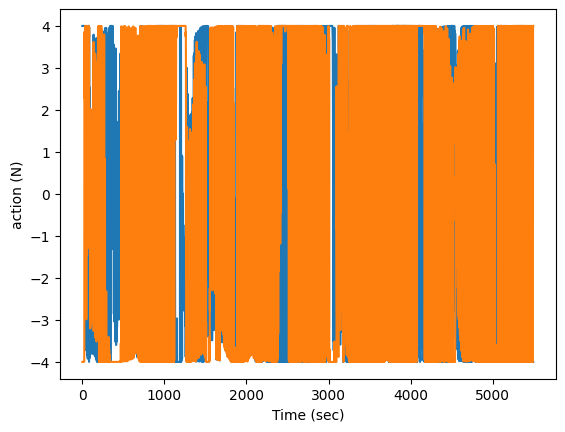

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 71 completed in 4454.10 sec
---------------------------------------
|             Epoch |              71 |
|      AverageEpRet |            -609 |
|          StdEpRet |        1.12e+03 |
|          MaxEpRet |             287 |
|          MinEpRet |       -3.04e+03 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |        2.13e+06 |
|      AverageQVals |            8.16 |
|          StdQVals |            42.3 |
|          MaxQVals |            97.3 |
|          MinQVals |            -625 |
|            LossPi |           -8.33 |
|             LossQ |             147 |
|              Time |        4.45e+03 |
---------------------------------------
done 🥺
(9999, 6)


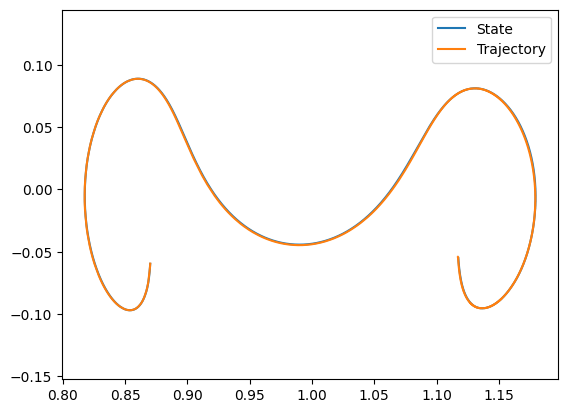

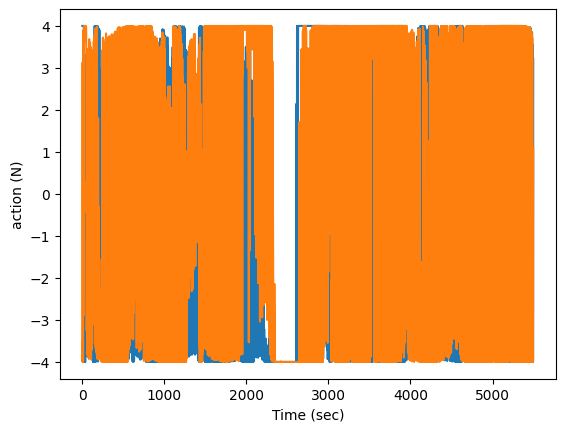

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 72 completed in 4517.03 sec
---------------------------------------
|             Epoch |              72 |
|      AverageEpRet |            -489 |
|          StdEpRet |             513 |
|          MaxEpRet |             398 |
|          MinEpRet |       -1.09e+03 |
|             EpLen |        5.03e+03 |
| TotalEnvInteracts |        2.16e+06 |
|      AverageQVals |            8.31 |
|          StdQVals |              42 |
|          MaxQVals |            94.9 |
|          MinQVals |            -622 |
|            LossPi |           -8.48 |
|             LossQ |             150 |
|              Time |        4.52e+03 |
---------------------------------------
done 🥺
(9999, 6)


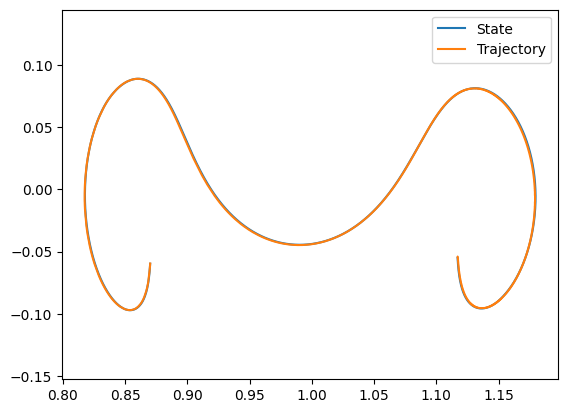

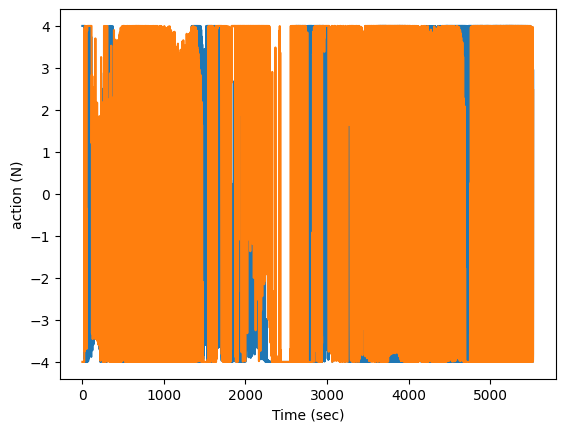

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 73 completed in 4580.38 sec
---------------------------------------
|             Epoch |              73 |
|      AverageEpRet |            -326 |
|          StdEpRet |             291 |
|          MaxEpRet |             191 |
|          MinEpRet |            -652 |
|             EpLen |        4.99e+03 |
| TotalEnvInteracts |        2.19e+06 |
|      AverageQVals |             8.2 |
|          StdQVals |            41.7 |
|          MaxQVals |             154 |
|          MinQVals |            -631 |
|            LossPi |           -8.36 |
|             LossQ |             148 |
|              Time |        4.58e+03 |
---------------------------------------
done 🥺
(9999, 6)


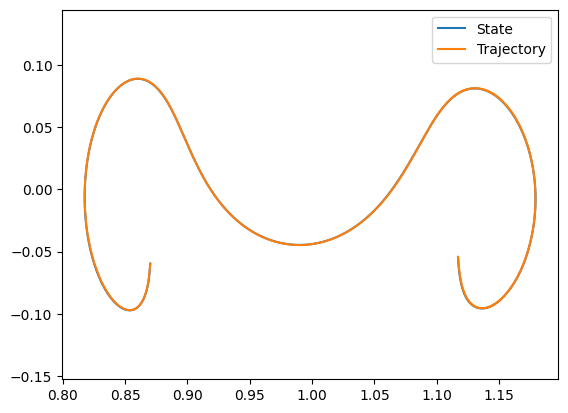

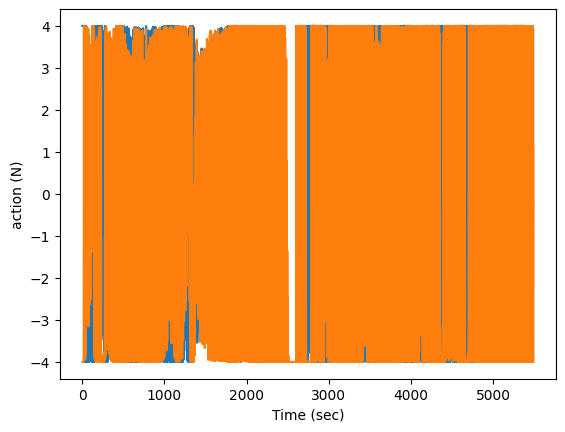

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 74 completed in 4643.01 sec
---------------------------------------
|             Epoch |              74 |
|      AverageEpRet |              27 |
|          StdEpRet |             306 |
|          MaxEpRet |             683 |
|          MinEpRet |            -268 |
|             EpLen |        5.01e+03 |
| TotalEnvInteracts |        2.22e+06 |
|      AverageQVals |            8.11 |
|          StdQVals |            40.9 |
|          MaxQVals |             193 |
|          MinQVals |            -654 |
|            LossPi |           -8.27 |
|             LossQ |             150 |
|              Time |        4.64e+03 |
---------------------------------------
done 🥺
(9999, 6)


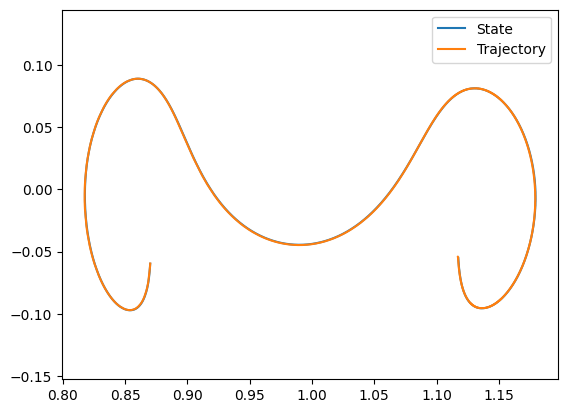

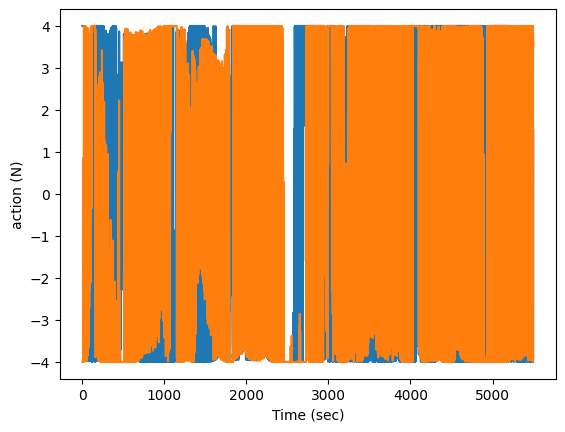

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 75 completed in 4705.37 sec
---------------------------------------
|             Epoch |              75 |
|      AverageEpRet |            -219 |
|          StdEpRet |             365 |
|          MaxEpRet |             467 |
|          MinEpRet |            -608 |
|             EpLen |        4.98e+03 |
| TotalEnvInteracts |        2.25e+06 |
|      AverageQVals |            8.36 |
|          StdQVals |            39.9 |
|          MaxQVals |             219 |
|          MinQVals |            -667 |
|            LossPi |           -8.53 |
|             LossQ |             152 |
|              Time |        4.71e+03 |
---------------------------------------
[-0.00188809  0.00984307  0.00432615  0.01303201]
idx 0.09998 state 0.0169

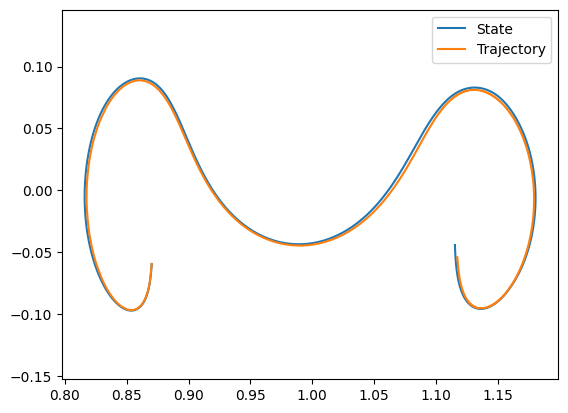

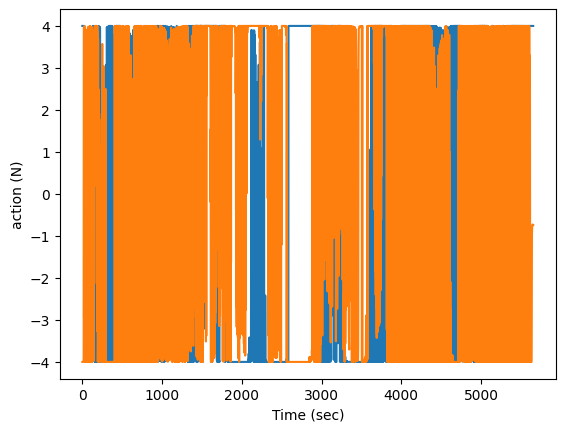

[-0.00189246  0.0100086   0.00440169  0.01320767]
idx 0.09998 state 0.01725024188072027
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[ 0.00864754 -0.00506168  0.01772302 -0.02068577]
idx 0.05326 state 0.029024250964993708
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.0016507   0.00996483  0.00490939  0.01335101]
idx 0.09998 state 0.01744632487018848
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
Epoch 76 completed in 4767.97 sec
---------------------------------------
|             Epoch |              76 |
|      AverageEpRet |       -1.25e+03 |
|          StdEpRet |        1.36e+03 |
|          MaxEpRet |             337 |
|          MinEpRet |       -3.94e+03 |
|             EpLen |         4.6e+03 |
| TotalEnvInteracts |        2.28e+06 |
|      AverageQVals |            8.39 |
|          StdQVals |            38.8 |
|          MaxQV

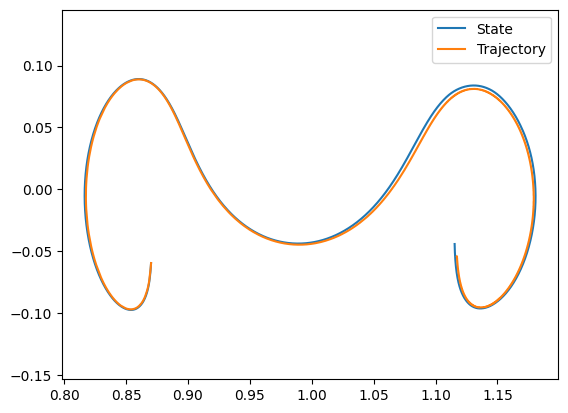

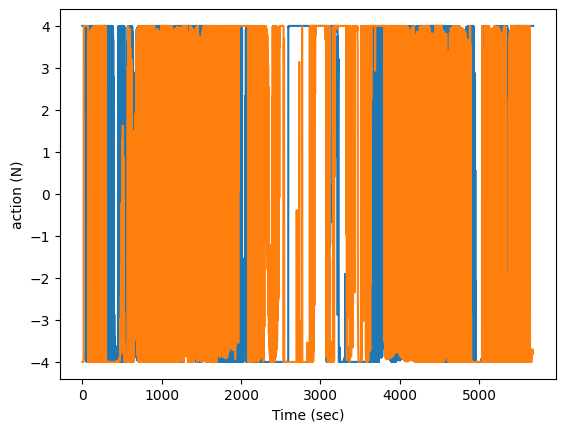

[-0.00181227  0.01013483  0.00540892  0.01345516]
idx 0.09998 state 0.017784736116568594
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00194077  0.00982397  0.00444256  0.01345169]
idx 0.09998 state 0.017348238509996266
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00788625 -0.00619912  0.02569937 -0.03911526]
idx 0.0494 state 0.04786526144463529
too much error 🥲😱
updating  🥰☺️
[ 0.00843824 -0.00542276  0.02446711 -0.03624115]
idx 0.0496 state 0.04486279479133329
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00149707  0.01001822  0.00532435  0.01293943]
idx 0.09998 state 0.017273779935668417
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00164476  0.00995435  0.00450267  0.01320593]
idx 0.09998 state 0.017218161349545888
too much error 🥲😱
updating  🥰☺️
[ 0.00766592 -0.00644135  0.02272513 -0.0420283 ]
idx 0.0492 state 0.04881667003240614
too much error 🥲😱
updating  🥰☺️
[ 0.0076646  -0.00645653  0.02266042 -0.04178264]
idx 0.04923

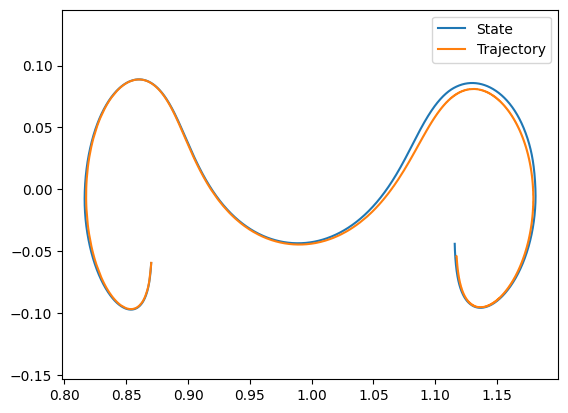

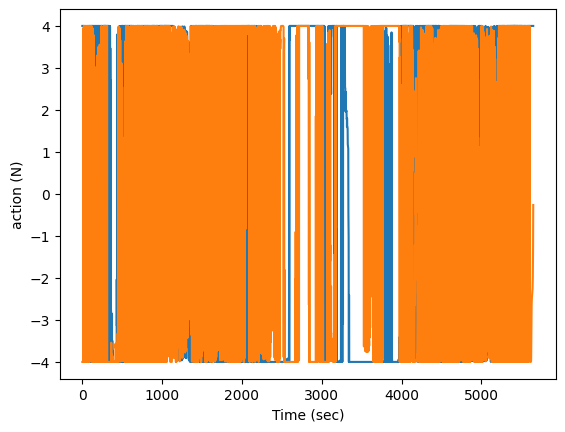

[-0.00148882  0.01016757  0.00497211  0.01350271]
idx 0.09998 state 0.017681663099998655
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00826249 -0.00570048  0.03302818 -0.02101765]
idx 0.05064 state 0.04041492505079816
too much error 🥲😱
updating  🥰☺️
[ 0.00800066 -0.00603616  0.02904894 -0.03356278]
idx 0.04973 state 0.04550546001834932
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00895692 -0.00458386  0.02959643 -0.02669442]
idx 0.0503 state 0.041106922139371026
too much error 🥲😱
updating  🥰☺️
[ 0.00867668 -0.00500811  0.03324305 -0.01016277]
idx 0.05169 state 0.03617662170419486
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 78 completed in 4893.89 sec
---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |            -989 |
|          StdEpRet |        1.06e+03 |
|          MaxEpRet |             288 |
|   

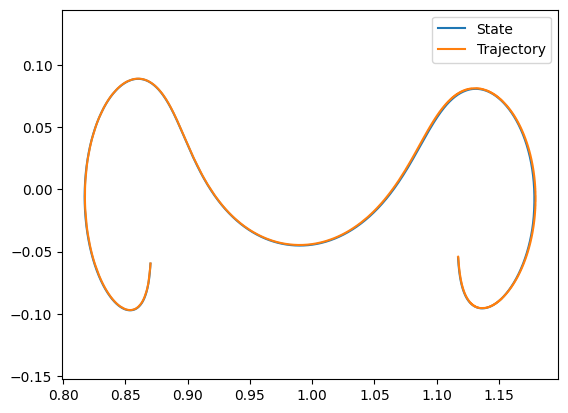

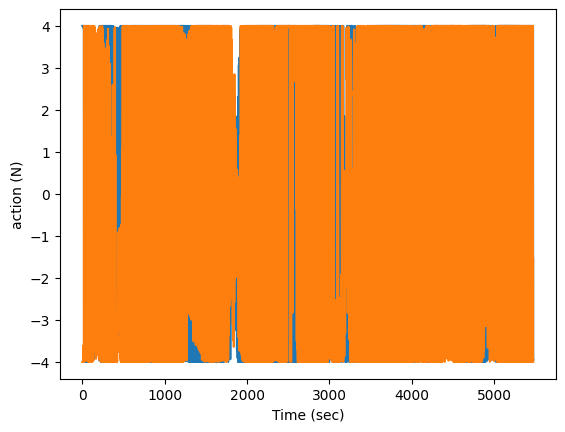

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00198033  0.00992407  0.00911886  0.01279883]
idx 0.09998 state 0.018691507488297135
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 79 completed in 4956.23 sec
---------------------------------------
|             Epoch |              79 |
|      AverageEpRet |            -389 |
|          StdEpRet |        1.66e+03 |
|          MaxEpRet |             797 |
|          MinEpRet |       -4.06e+03 |
|             EpLen |        4.99e+03 |
| TotalEnvInteracts |        2.37e+06 |
|      AverageQVals |            7.27 |
|          StdQVals |            42.1 |
|          MaxQVals |             211 |
|          MinQVals |            -628 |
|            LossPi |           -7.42 |
|             LossQ |             169 |
|              Time |        4.96e+03 |
--------------

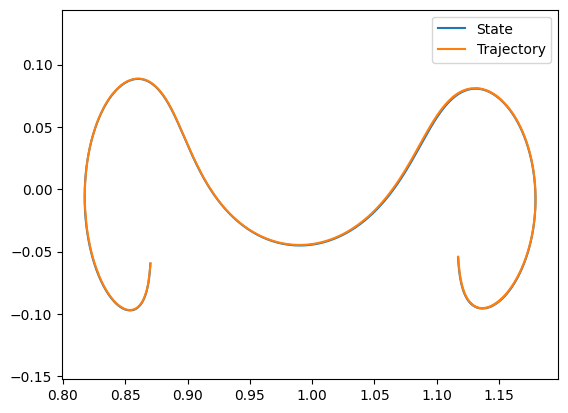

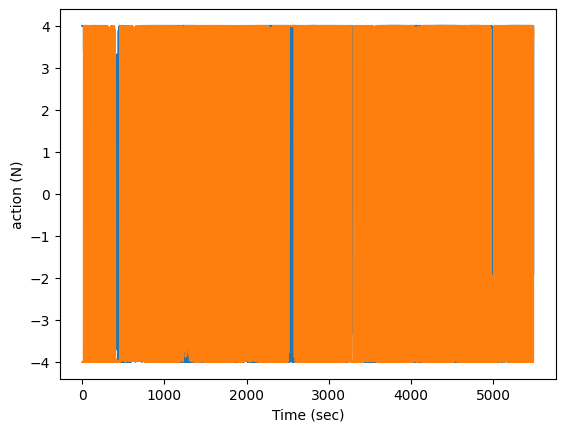

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 80 completed in 5019.14 sec
---------------------------------------
|             Epoch |              80 |
|      AverageEpRet |             318 |
|          StdEpRet |             259 |
|          MaxEpRet |             792 |
|          MinEpRet |            16.2 |
|             EpLen |        4.97e+03 |
| TotalEnvInteracts |         2.4e+06 |
|      AverageQVals |            7.28 |
|          StdQVals |            41.8 |
|          MaxQVals |             187 |
|          MinQVals |            -622 |
|            LossPi |           -7.43 |
|             LossQ |             161 |
|              Time |        5.02e+03 |
---------------------------------------
done 🥺
(9999, 6)


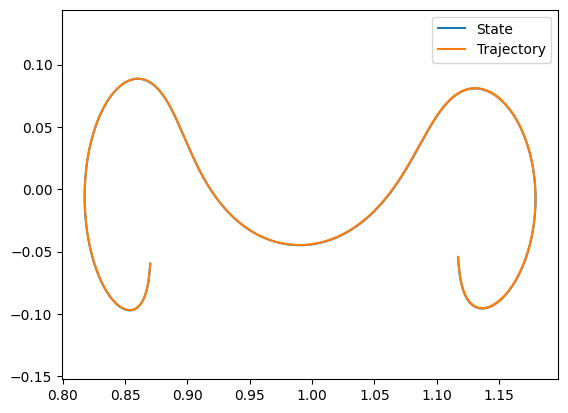

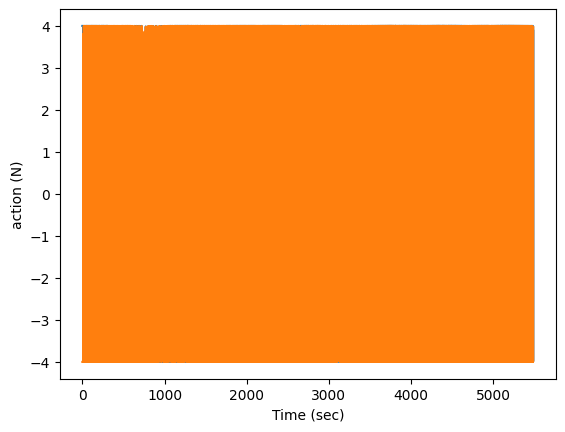

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 81 completed in 5081.85 sec
---------------------------------------
|             Epoch |              81 |
|      AverageEpRet |             546 |
|          StdEpRet |             136 |
|          MaxEpRet |             818 |
|          MinEpRet |             407 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |        2.43e+06 |
|      AverageQVals |            7.21 |
|          StdQVals |            41.9 |
|          MaxQVals |             148 |
|          MinQVals |            -648 |
|            LossPi |           -7.35 |
|             LossQ |             169 |
|              Time |        5.08e+03 |
---------------------------------------
done 🥺
(9999, 6)


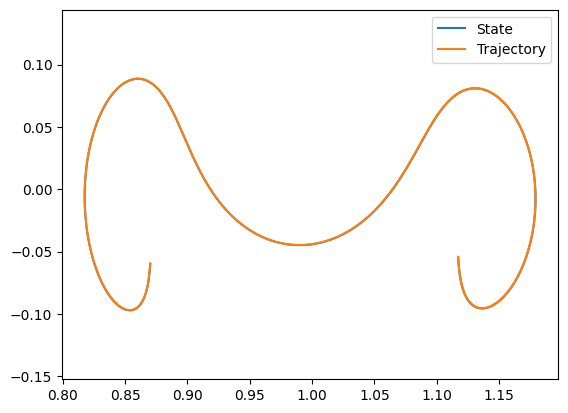

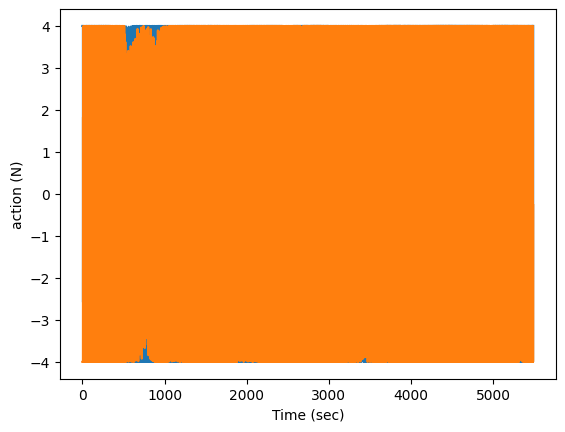

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 82 completed in 5145.13 sec
---------------------------------------
|             Epoch |              82 |
|      AverageEpRet |             674 |
|          StdEpRet |              86 |
|          MaxEpRet |             835 |
|          MinEpRet |             571 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |        2.46e+06 |
|      AverageQVals |            6.92 |
|          StdQVals |            42.1 |
|          MaxQVals |             112 |
|          MinQVals |            -646 |
|            LossPi |           -7.06 |
|             LossQ |             159 |
|              Time |        5.15e+03 |
---------------------------------------
done 🥺
(9999, 6)


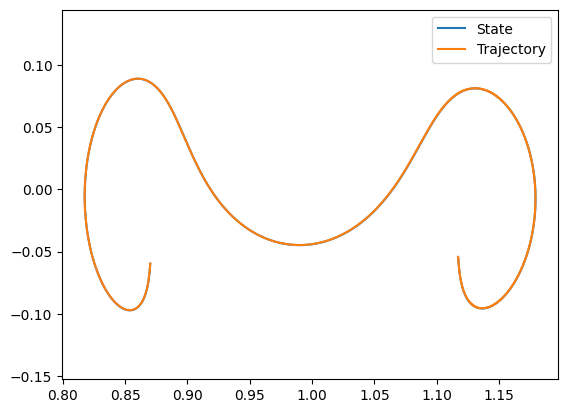

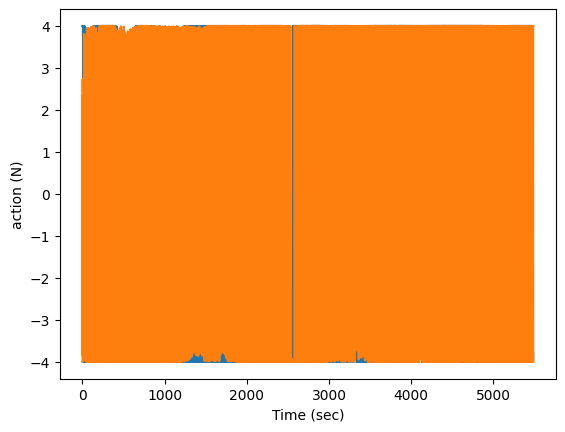

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00278399  0.00975719 -0.01085408  0.01887148]
idx 0.09998 state 0.02401868217901466
too much error 🥲😱
updating  🥰☺️
Epoch 83 completed in 5208.04 sec
---------------------------------------
|             Epoch |              83 |
|      AverageEpRet |            -106 |
|          StdEpRet |        1.75e+03 |
|          MaxEpRet |             857 |
|          MinEpRet |       -4.02e+03 |
|             EpLen |        5.01e+03 |
| TotalEnvInteracts |        2.49e+06 |
|      AverageQVals |            6.96 |
|          StdQVals |            42.3 |
|          MaxQVals |            76.4 |
|          MinQVals |            -651 |
|            LossPi |           -7.13 |
|             LossQ |             163 |
|              Time |        5.21e+03 |
---------------

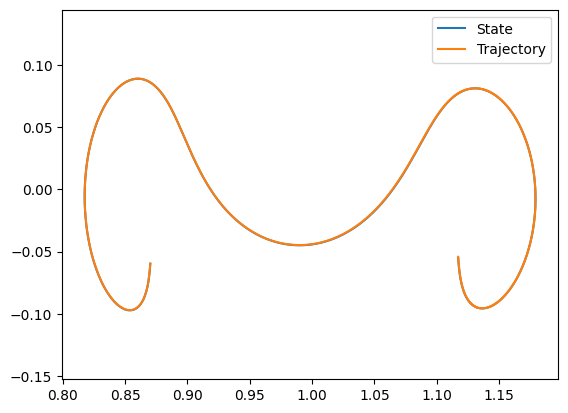

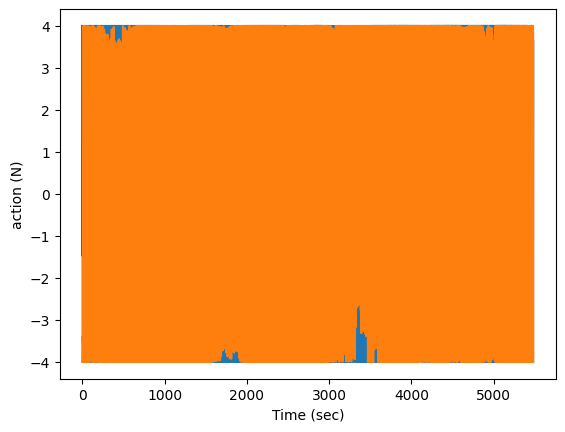

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 84 completed in 5270.88 sec
---------------------------------------
|             Epoch |              84 |
|      AverageEpRet |             440 |
|          StdEpRet |             687 |
|          MaxEpRet |             871 |
|          MinEpRet |       -1.09e+03 |
|             EpLen |        4.99e+03 |
| TotalEnvInteracts |        2.52e+06 |
|      AverageQVals |            7.83 |
|          StdQVals |            43.3 |
|          MaxQVals |            81.1 |
|          MinQVals |            -649 |
|            LossPi |           -8.03 |
|             LossQ |             159 |
|              Time |        5.27e+03 |
---------------------------------------
[-0.0020059   0.00984826  0.00024528  0.02098361]
idx 0.09998 state 0.0232

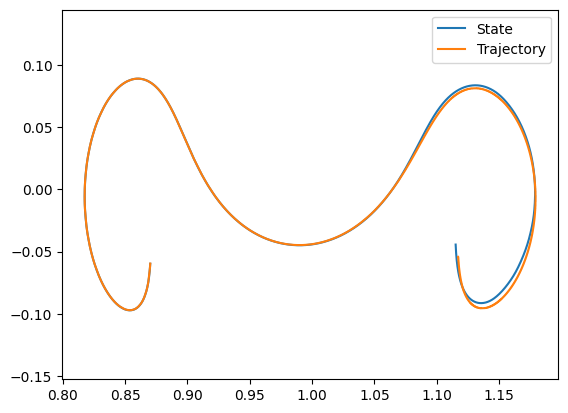

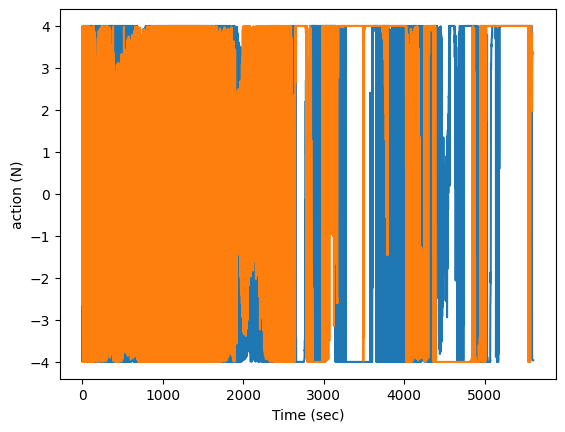

[-0.00201435  0.01002174  0.00025543  0.02116798]
idx 0.09998 state 0.023508325017136487
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[-0.00921588  0.00388209 -0.00603529  0.02496569]
idx 0.08175 state 0.02756289483904607
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00948999  0.00315955 -0.01669536  0.04012855]
idx 0.08048 state 0.044599082055329795
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
Epoch 85 completed in 5333.59 sec
---------------------------------------
|             Epoch |              85 |
|      AverageEpRet |       -1.65e+03 |
|          StdEpRet |        2.21e+03 |
|          MaxEpRet |             569 |
|          MinEpRet |       -5.18e+03 |
|             EpLen |        4.71e+03 |
| TotalEnvInteracts |        2.55e+06 |
|      AverageQVals |            8.25 |
|          StdQVals |            43.8 |
|          MaxQ

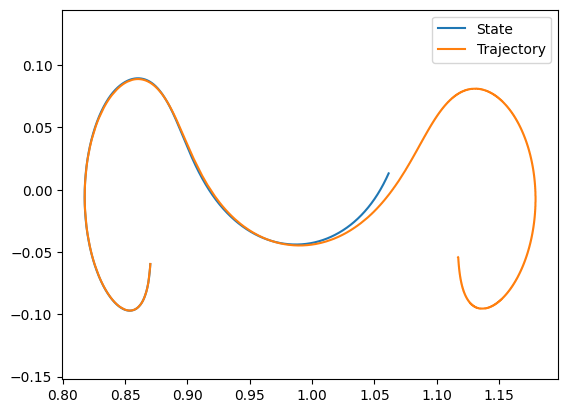

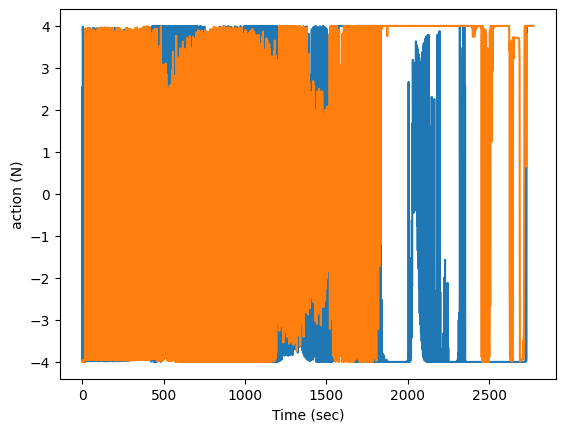

[-0.00854198  0.00540709 -0.03920435  0.05188917]
idx 0.05003 state 0.0658154138448742
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
[-0.00884901  0.00468989 -0.03538027  0.0201729 ]
idx 0.05189 state 0.04194054819079234
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00886238 -0.00469678  0.03806143 -0.01495095]
idx 0.05124 state 0.04210469228234117
too much error 🥲😱
updating  🥰☺️
[-0.00892533  0.00453732 -0.03153966  0.02765269]
idx 0.05111 state 0.043123894359096436
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
Epoch 86 completed in 5394.93 sec
---------------------------------------
|             Epoch |              86 |
|      AverageEpRet |       -1.26e+03 |
|          StdEpRet |        1.61e+03 |
|          MaxEpRet |             617 |
|          MinEpRet |       -2.91e+03 |
|             EpLen |        4.18e+03 |
| TotalEnvInteracts |        2.

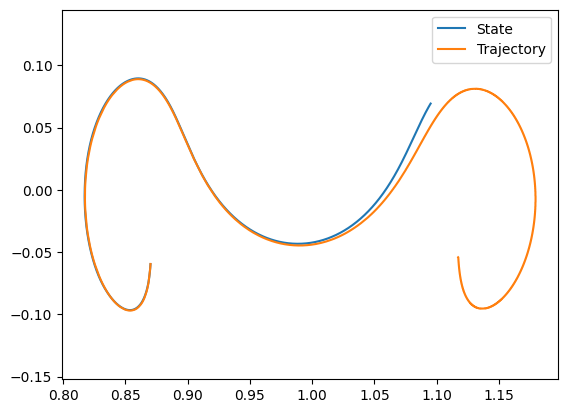

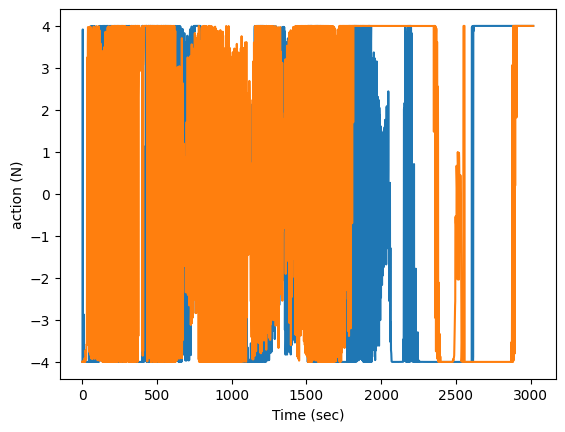

[-0.00765273  0.0064997  -0.01714994 -0.0002198 ]
idx 0.05488 state 0.019874083062565117
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[-0.00817993  0.00576222 -0.03303811  0.01627733]
idx 0.05408 state 0.038165203092810934
too much error 🥲😱
updating  🥰☺️
[-0.00633792  0.0077607  -0.01890356  0.01291462]
idx 0.03031 state 0.02499059359411526
too much error 🥲😱
updating  🥰☺️
[-0.00677674  0.00736595 -0.01943952  0.01463934]
idx 0.02997 state 0.02631323727571247
too much error 🥲😱
Epoch 87 completed in 5455.52 sec
---------------------------------------
|             Epoch |              87 |
|      AverageEpRet |       -1.98e+03 |
|          StdEpRet |             482 |
|          MaxEpRet |       -1.25e+03 |
|          MinEpRet |       -2.75e+03 |
|             EpLen |        4.14e+03 |
| TotalEnvInteracts | 

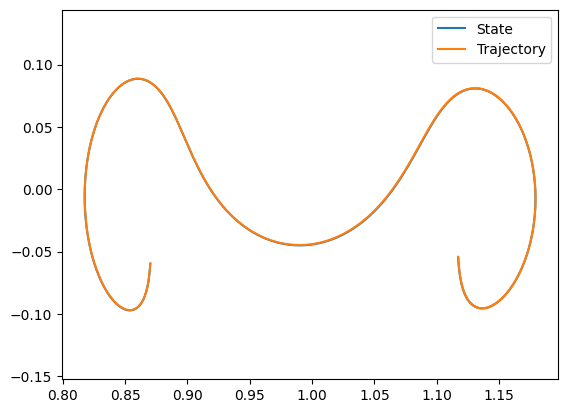

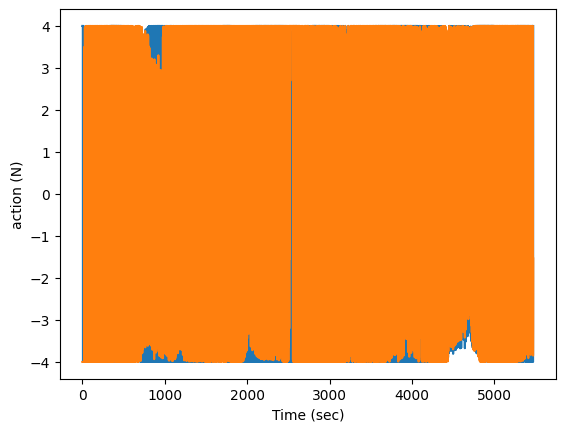

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[ 0.00804144 -0.00595994  0.02672015 -0.00194892]
idx 0.0546 state 0.02859983455824639
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00278774  0.00966444 -0.0049529   0.01848124]
idx 0.09998 state 0.021616210760185814
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[-0.00180885  0.00991398 -0.00152473  0.01804688]
idx 0.09998 state 0.020726162704572674
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
Epoch 88 completed in 5518.47 sec
---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |       -1.36e+03 |
|          StdEpRet |        1.86e+03 |
|          MaxEpRet |             776 |
|          MinEpRet |       -3.43e+03 |
|             EpLen |         4.5e+03 |
| TotalEnvInteracts |        2.64e+06 |
|      AverageQVals |            5.15 |
|          StdQVals |            49.4 |
|          MaxQV

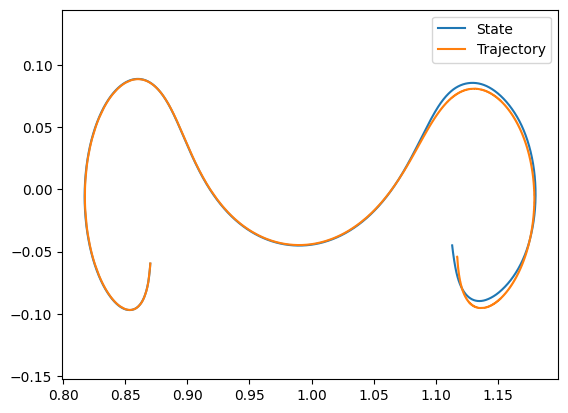

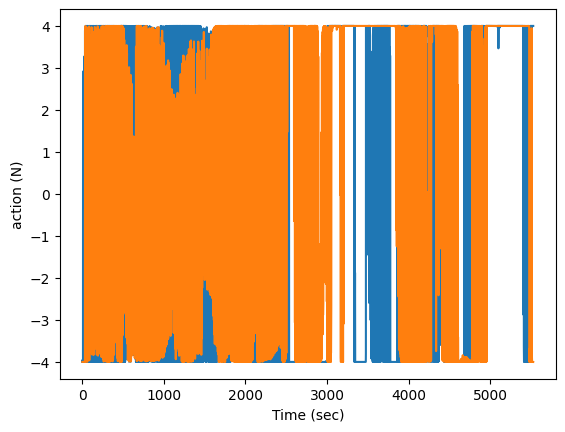

[-0.00407446  0.00934954 -0.01005282  0.02012033]
idx 0.09998 state 0.024696189232718185
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 89 completed in 5581.20 sec
---------------------------------------
|             Epoch |              89 |
|      AverageEpRet |       -1.08e+03 |
|          StdEpRet |             859 |
|          MaxEpRet |             438 |
|          MinEpRet |        -2.3e+03 |
|             EpLen |        5.42e+03 |
| TotalEnvInteracts |        2.67e+06 |
|      AverageQVals |            3.57 |
|          StdQVals |            50.2 |
|          MaxQVals |            79.5 |
|          MinQVals |            -638 |
|            LossPi |           -3.71 |
|             LossQ |             153 |
|              Time |        5.58e+03 |
--------------

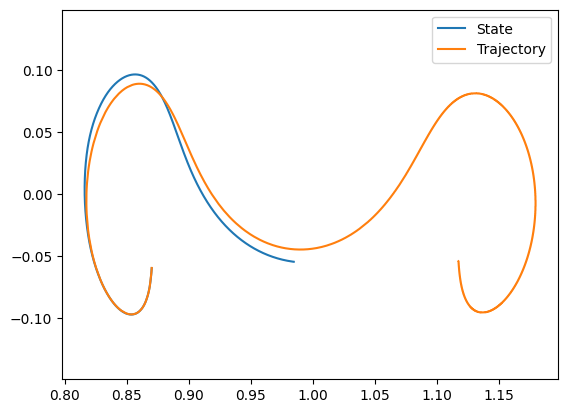

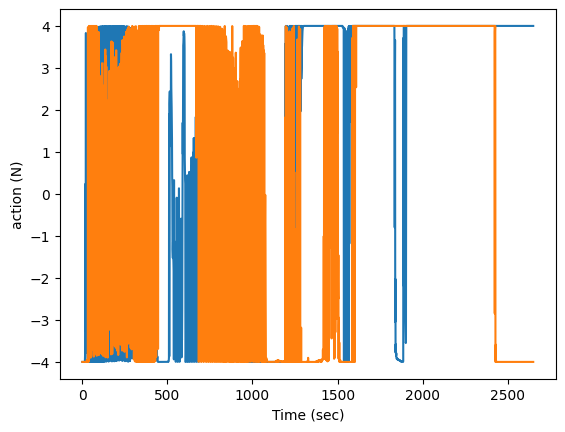

[-0.00054537 -0.01003861 -0.0776923  -0.02594462]
idx 0.04601 state 0.08252446804017137
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 90 completed in 5641.99 sec
---------------------------------------
|             Epoch |              90 |
|      AverageEpRet |       -1.72e+03 |
|          StdEpRet |             882 |
|          MaxEpRet |            -328 |
|          MinEpRet |          -3e+03 |
|             EpLen |        4.98e+03 |
| TotalEnvInteracts |         2.7e+06 |
|      AverageQVals |            2.26 |
|          StdQVals |            50.2 |
|          MaxQVals |            69.1 |
|          MinQVals |            -631 |
|            LossPi |           -2.41 |
|             LossQ |             158 |
|              Time |        5.64e+03 |
---------------

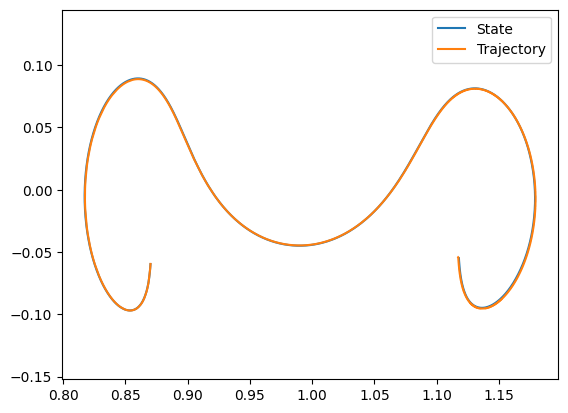

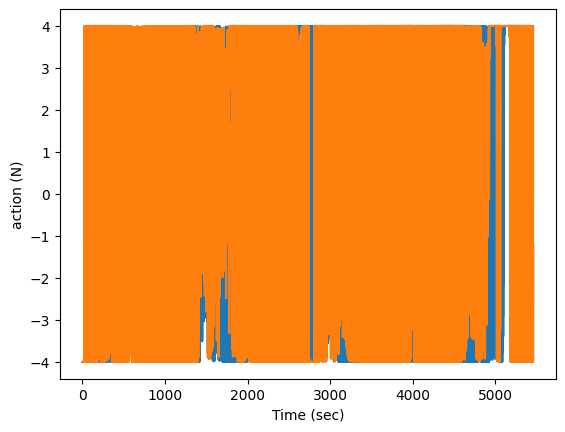

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 91 completed in 5704.44 sec
---------------------------------------
|             Epoch |              91 |
|      AverageEpRet |            -303 |
|          StdEpRet |             803 |
|          MaxEpRet |             538 |
|          MinEpRet |       -1.52e+03 |
|             EpLen |        4.97e+03 |
| TotalEnvInteracts |        2.73e+06 |
|      AverageQVals |            1.52 |
|          StdQVals |            49.3 |
|          MaxQVals |            67.1 |
|          MinQVals |            -631 |
|            LossPi |           -1.66 |
|             LossQ |             153 |
|              Time |         5.7e+03 |
---------------------------------------
done 🥺
(9999, 6)


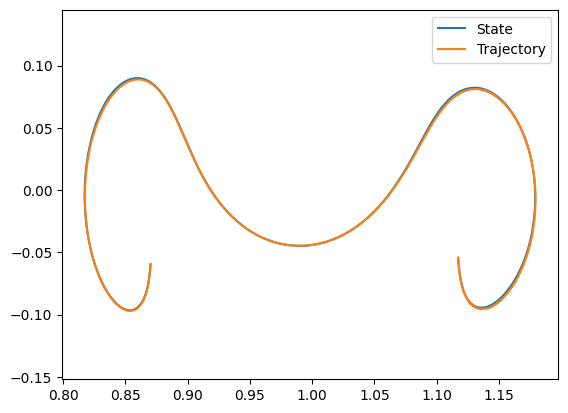

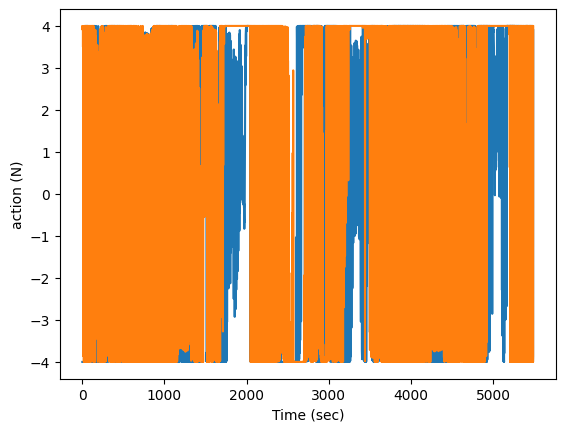

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 92 completed in 5766.70 sec
---------------------------------------
|             Epoch |              92 |
|      AverageEpRet |           -46.8 |
|          StdEpRet |             527 |
|          MaxEpRet |             482 |
|          MinEpRet |       -1.01e+03 |
|             EpLen |        5.04e+03 |
| TotalEnvInteracts |        2.76e+06 |
|      AverageQVals |             1.3 |
|          StdQVals |            47.5 |
|          MaxQVals |              65 |
|          MinQVals |            -627 |
|            LossPi |           -1.44 |
|             LossQ |             155 |
|              Time |        5.77e+03 |
---------------------------------------
done 🥺
(9999, 6)


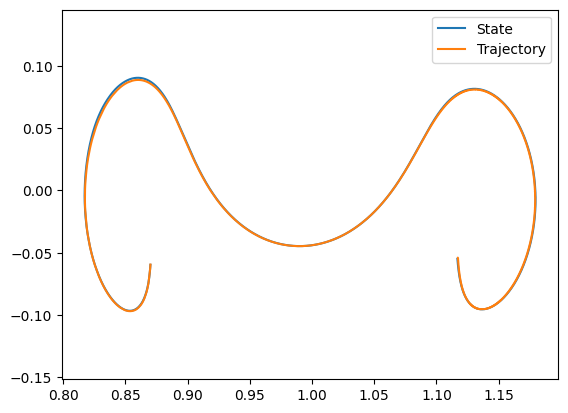

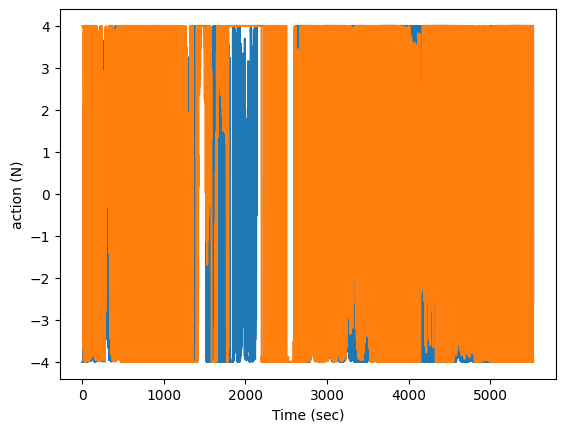

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[0.00060164 0.00998722 0.00030092 0.01580373]
idx 0.09998 state 0.018707087534688784
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
[-0.00818818  0.00575332 -0.01706019  0.04347326]
idx 0.04995 state 0.04776108671845021
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00797338  0.00603578 -0.01119046  0.0070794 ]
idx 0.05507 state 0.016593666044905166
too much error 🥲😱
updating  🥰☺️
[-0.00881719  0.0047847  -0.01608023  0.03184134]
idx 0.05091 state 0.0370551085349139
too much error 🥲😱
updating  🥰☺️
[-0.00810465  0.00591177 -0.01715519  0.04295749]
idx 0.04995 state 0.04733160617381393
too much error 🥲😱
updating  🥰☺️
Epoch 93 completed in 5829.50 sec
---------------------------------------
|             Epoch |              93 |
|      AverageEpRet |       -1.88e+03 |
|          StdEpRet |        1.19e+03 |
|          MaxEpRet |             681 |
|       

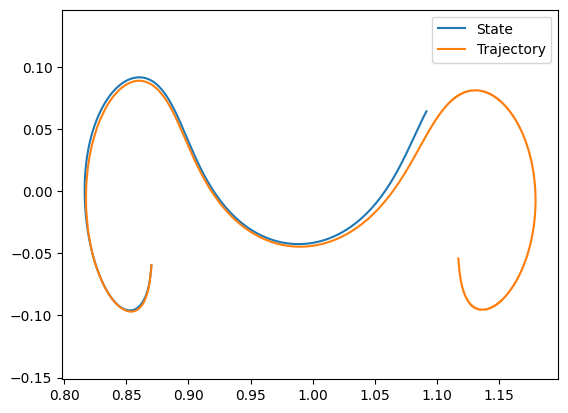

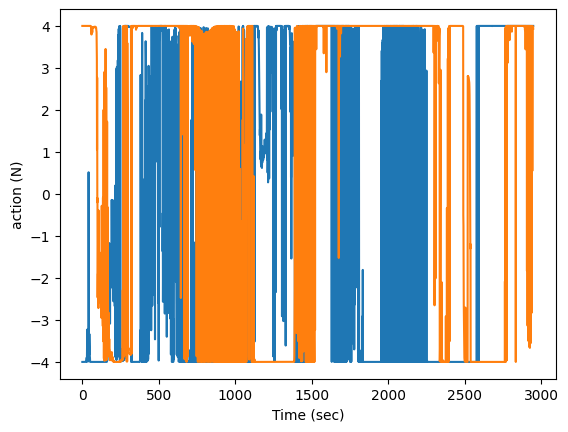

[-0.00820232  0.00577163 -0.01244874  0.01240714]
idx 0.05432 state 0.020236062026202345
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[0.00172775 0.00996608 0.00165487 0.01613352]
idx 0.09998 state 0.01911378784767077
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.008178    0.00576997 -0.015603    0.04607152]
idx 0.04981 state 0.04966096198662527
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[-0.00780889  0.00628627 -0.01560828  0.04702656]
idx 0.04965 state 0.05055306057004349
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[0.00096631 0.01004874 0.00106799 0.01541092]
idx 0.09998 state 0.018453947043182258
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00863848  0.0050448  -0.01522158  0.01994013]
idx 0.05249 state 0.027007010165671214
too much error 🥲😱
updating  🥰☺️
[-0.00829328  0.0056054  -0.01165977  0.04541863]
idx 0.04981 state 0.04794790580683787
too much error 🥲😱
updating  🥰☺️
Epoch 94 completed in 5890.79 sec
------------

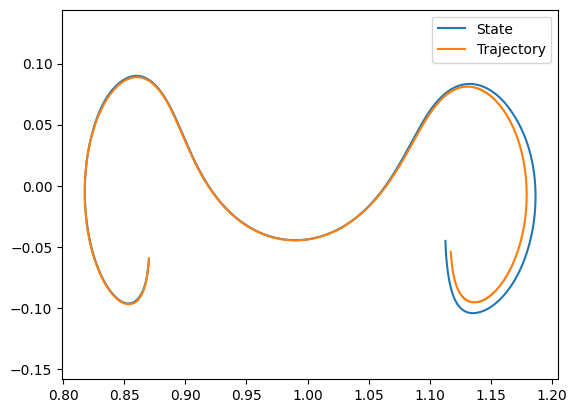

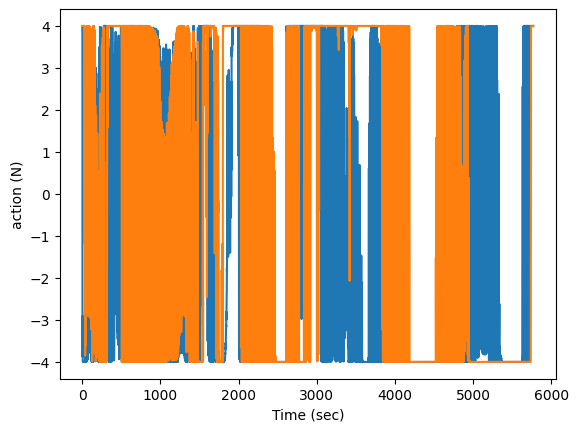

[-0.0043984   0.00916929  0.0037895   0.02283645]
idx 0.09998 state 0.025284101206968446
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00764819  0.00645525 -0.01004861  0.05284511]
idx 0.04932 state 0.05471512686282578
too much error 🥲😱
updating  🥰☺️
[-0.00772817  0.00636315 -0.01400902  0.05675359]
idx 0.04919 state 0.05930798368575995
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00892198  0.00455278 -0.01904559  0.02791934]
idx 0.05173 state 0.035249877979999525
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[0.00140217 0.00993109 0.00079956 0.01660525]
idx 0.09998 state 0.01941561543692124
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[0.00067213 0.01014144 0.00139771 0.01506664]
idx 0.09998 state 0.018227941079455186
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-1.00033368e-02  1.65641674e-05 -1.44195137e-02  5.97793467e-03]
idx 0.07564 state 0.018539824646672715
too much error 🥲😱
updating  🥰☺️
[-0.00543086  0.00840066  0.00262117  0.03143928]
idx 0.03091 st

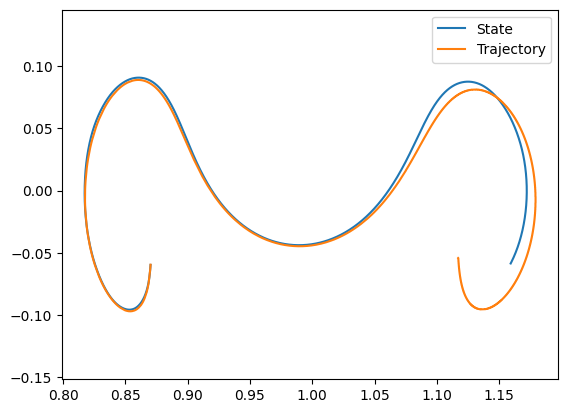

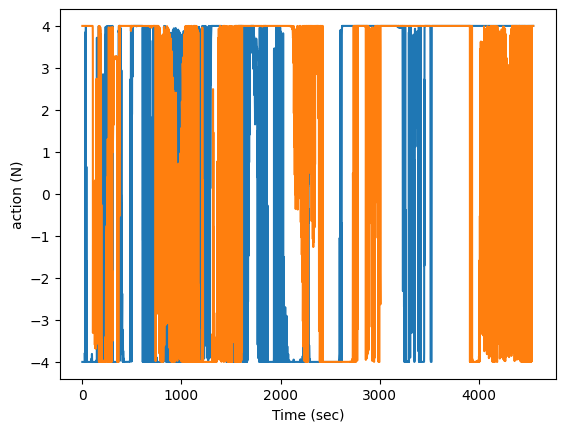

[-0.00904067  0.00430606 -0.00520047  0.0115463 ]
idx 0.08165 state 0.016144272702310496
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
[-0.0099233  -0.00125863 -0.01821364  0.00801874]
idx 0.07322 state 0.022273139218594983
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
Epoch 96 completed in 6015.87 sec
---------------------------------------
|             Epoch |              96 |
|      AverageEpRet |       -1.97e+03 |
|          StdEpRet |        1.31e+03 |
|          MaxEpRet |       -1.03e+03 |
|          MinEpRet |       -4.81e+03 |
|             EpLen |        4.62e+03 |
| TotalEnvInteracts |        2.88e+06 |
|      AverageQVals |          -0.232 |
|          StdQVals |            44.6 |
|          MaxQVals |            48.3 |
|          MinQVals |            -575 |
|            LossPi |           0.

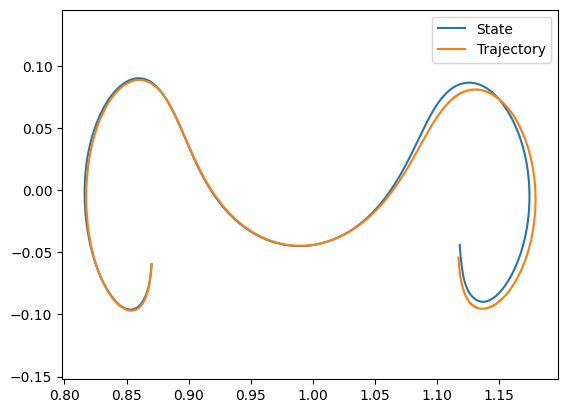

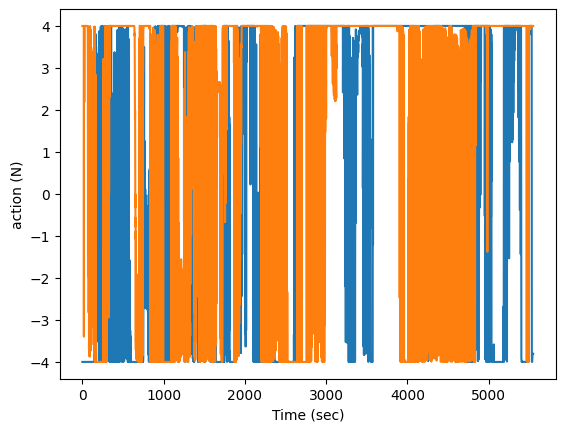

[ 0.00108571  0.01019603 -0.00079271  0.01466422]
idx 0.09998 state 0.017911041712282576
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 97 completed in 6078.25 sec
---------------------------------------
|             Epoch |              97 |
|      AverageEpRet |        -1.5e+03 |
|          StdEpRet |             578 |
|          MaxEpRet |            -568 |
|          MinEpRet |       -2.05e+03 |
|             EpLen |        5.26e+03 |
| TotalEnvInteracts |        2.91e+06 |
|      AverageQVals |           -1.94 |
|          StdQVals |            46.1 |
|          MaxQVals |              44 |
|          MinQVals |            -585 |
|            LossPi |             1.8 |
|             LossQ |             153 |
|              Time |        6.08e+03 |
--------------

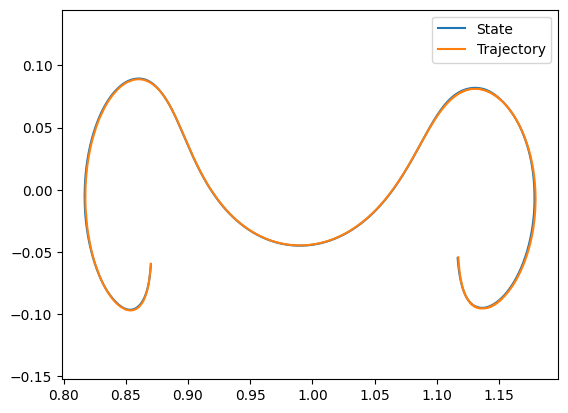

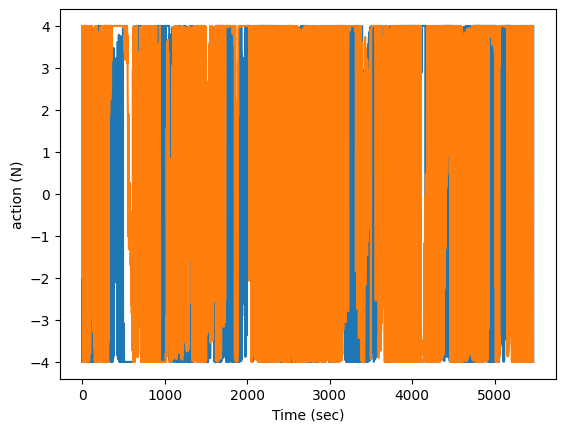

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 98 completed in 6140.62 sec
---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |            -594 |
|          StdEpRet |             599 |
|          MaxEpRet |             512 |
|          MinEpRet |       -1.25e+03 |
|             EpLen |        4.99e+03 |
| TotalEnvInteracts |        2.94e+06 |
|      AverageQVals |            -2.8 |
|          StdQVals |            46.6 |
|          MaxQVals |            49.4 |
|          MinQVals |            -584 |
|            LossPi |            2.68 |
|             LossQ |             160 |
|              Time |        6.14e+03 |
---------------------------------------
done 🥺
(9999, 6)


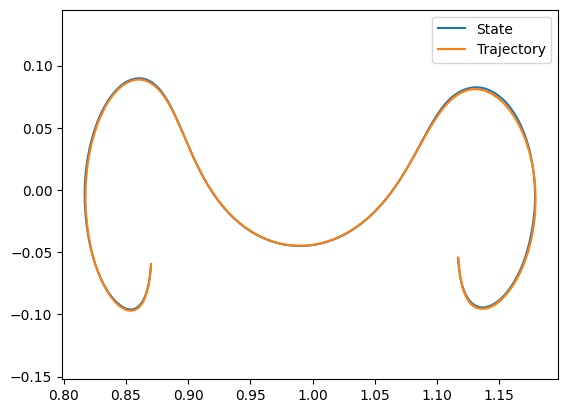

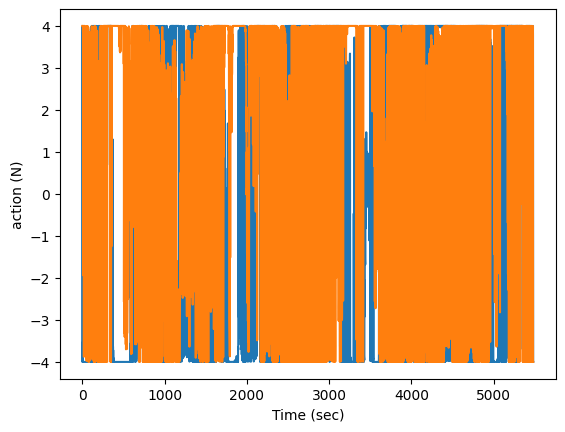

done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 99 completed in 6202.99 sec
---------------------------------------
|             Epoch |              99 |
|      AverageEpRet |            -367 |
|          StdEpRet |             473 |
|          MaxEpRet |             198 |
|          MinEpRet |          -1e+03 |
|             EpLen |        4.98e+03 |
| TotalEnvInteracts |        2.97e+06 |
|      AverageQVals |            -3.7 |
|          StdQVals |            46.8 |
|          MaxQVals |            54.7 |
|          MinQVals |            -636 |
|            LossPi |            3.57 |
|             LossQ |             150 |
|              Time |         6.2e+03 |
---------------------------------------
[-0.00912381 -0.00415677 -0.02638273 -0.0001422 ]
idx 0.06891 state 0.0282

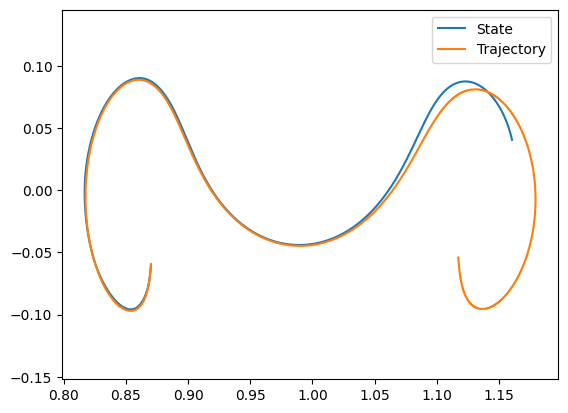

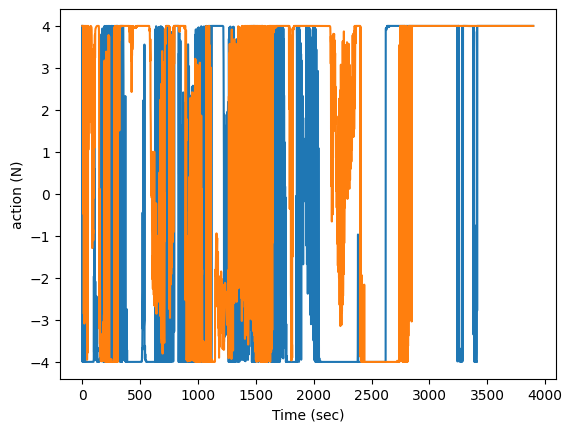

[-9.19338452e-03 -4.06799510e-03 -2.63109813e-02 -2.55465568e-05]
idx 0.06894 state 0.02816620835973512
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
updating  🥰☺️
done 🥺
updating  🥰☺️
Epoch 100 completed in 6264.84 sec
---------------------------------------
|             Epoch |             100 |
|      AverageEpRet |            -498 |
|          StdEpRet |             545 |
|          MaxEpRet |           -66.5 |
|          MinEpRet |       -1.41e+03 |
|             EpLen |        5.05e+03 |
| TotalEnvInteracts |           3e+06 |
|      AverageQVals |           -4.38 |
|          StdQVals |            46.9 |
|          MaxQVals |            42.4 |
|          MinQVals |            -637 |
|            LossPi |            4.25 |
|             LossQ |             157 |
|              Time |        6.26e+03 

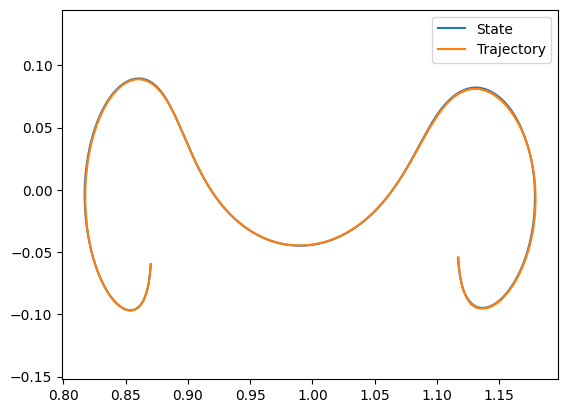

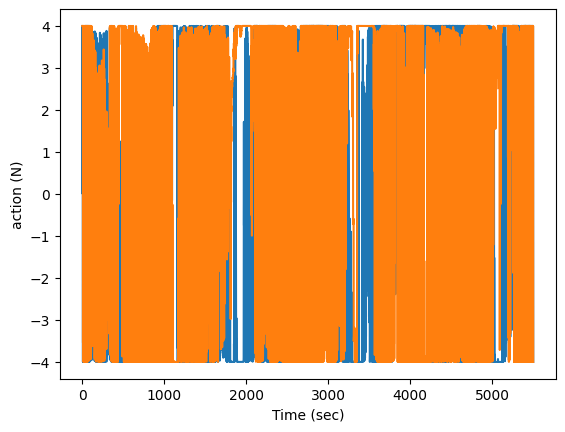

In [ ]:
ddpg.train(epochs_=100)

done 🥺
(9999, 6)


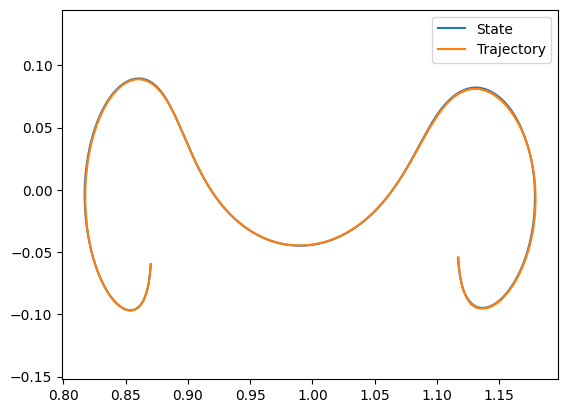

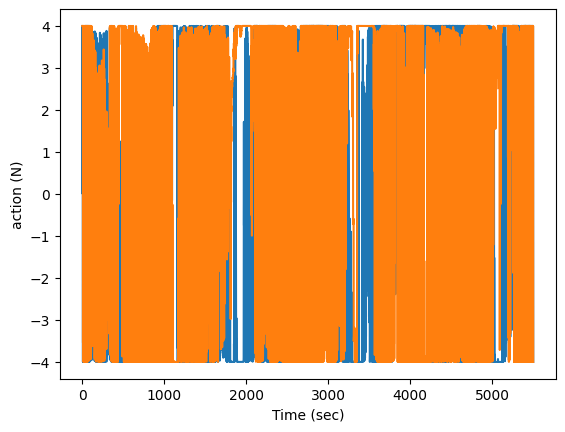

In [ ]:
ddpg.test()

In [ ]:
print(reward_array)

In [ ]:
rewards = np.array(reward_array)

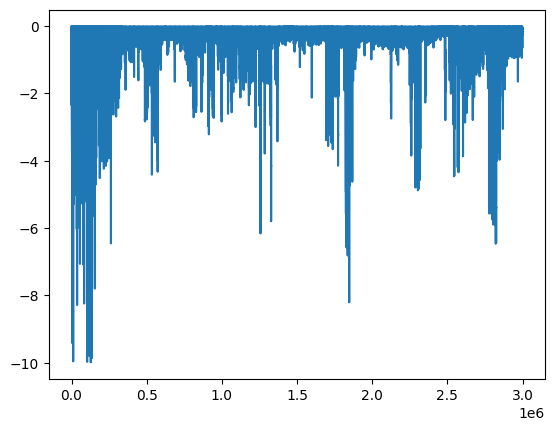

In [ ]:
rewards_ = rewards[(rewards != 1000) & (rewards > -10)]
plt.plot(rewards_)

In [ ]:
# ddpg.train(epochs_=500)
states = np.array(states_array)
# separate figure for each state
for i in range(states.shape[1]):
    plt.plot(states[:,i])
    plt.show()


done 🥺
(9999, 6)


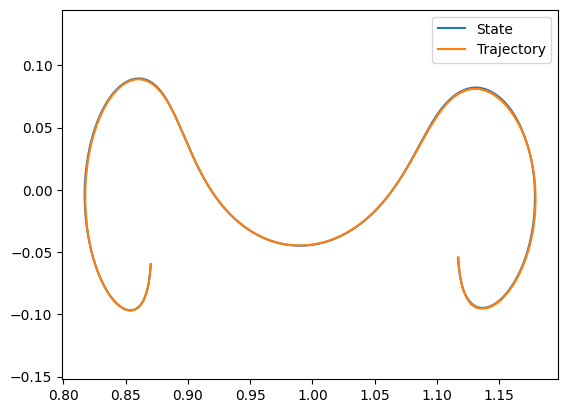

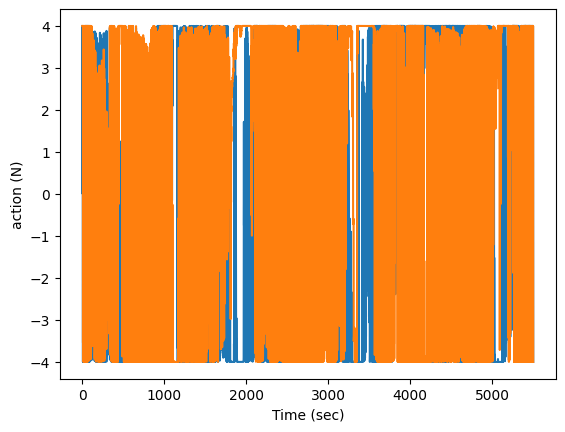

In [ ]:
ddpg.test()

In [ ]:
ddpg.save()

Model saved successfully! 🥰😎


In [ ]:
if True:
    try:
        # noinspection PyUnresolvedReferences
        import google.colab
        # download created models
        if os.path.isfile("DDPG_TBP_results.tar.gz"):
            os.remove("DDPG_TBP_results.tar.gz")
        !tar cvfz DDPG_TBP_results.tar.gz model/
        # noinspection PyUnresolvedReferences
        from google.colab import files
        files.download('DDPG_TBP_results.tar.gz')
        print(colorize("Done! 🥰😎", 'blue', bold=True))
    except Exception as e:
        print(e, end=' ----> ')
        print(colorize("Something Wrong 🧐😩, or maybe you used your Mac 😱🥲", 'red', bold=True))
else:
    print(colorize("You are in test mode! 🥰😎", 'blue', bold=True))

model/
model/q_cpu.pth
model/actor_cpu.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done! 🥰😎
